# Conversation-Connect
### Identifying patients for Serious Illness Conversations

> Corey Chivers, PhD <corey.chivers@pennmedicine.upenn.edu> <br>
> Copyright (c) 2019 University of Pennsylvania Health System, MIT License

Predict risk of 6 month mortality for a general population of Penn Medicine Oncology adult patients to improve access to advanced care planning for those most likely to benefit.

In [1]:
%pylab inline

import pandas as pd

pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

Populating the interactive namespace from numpy and matplotlib


# Cohort

In [4]:
q = """
select id.identity_id as EMPI, 
 PE.PAT_ENC_CSN_ID AS CSN
 ,p.PAT_ID
 ,PE.APPT_TIME
 ,cd.DEPARTMENT_NAME
 ,cd.SPECIALTY,cd.EXTERNAL_NAME
 ,cs.EXTERNAL_NAME as PROVIDER_NAME
 ,PROV_TYPE
 ,p.DEATH_DATE
 ,p.BIRTH_DATE
 ,p.SEX_C
from PAT_ENC pe
LEFT JOIN PATIENT p
  ON pe.PAT_ID = p.PAT_ID
INNER JOIN IDENTITY_ID ID
  ON  pe.PAT_ID = ID.PAT_ID
  AND ID.IDENTITY_TYPE_ID = 105
inner join CLARITY_DEP cd
  on pe.DEPARTMENT_ID = cd.DEPARTMENT_ID
  and pe.CONTACT_DATE >='2016-02-01'
  and pe.CONTACT_DATE < '2016-07-01'
inner JOIN ZC_DISP_ENC_TYPE ZDET
  ON PE.ENC_TYPE_C = ZDET.DISP_ENC_TYPE_C
INNER JOIN ZC_APPT_STATUS ZAS
  ON PE.APPT_STATUS_C = ZAS.APPT_STATUS_C
left join clarity_ser cs
  on pe.VISIT_PROV_ID = cs.PROV_ID
where cd.specialty in ('Oncology','Hematology/Oncology')
 AND ZDET.NAME IN ('Office Visit','Appointment')
AND ZAS.NAME ='Completed'
"""

enc_data = SQLquery2df(q,conn)
enc_data.shape

(62380, 12)

In [1]:
#enc_data.head()

In [6]:
enc_data['EMPI'].nunique()

26527

In [7]:
enc_data['DEATH_DATE'] = pd.to_datetime(enc_data['DEATH_DATE'])

In [8]:
enc_data.dtypes

APPT_TIME          datetime64[ns]
BIRTH_DATE         datetime64[ns]
CSN                        object
DEATH_DATE         datetime64[ns]
DEPARTMENT_NAME            object
EMPI                       object
EXTERNAL_NAME              object
PAT_ID                     object
PROVIDER_NAME              object
PROV_TYPE                  object
SEX_C                      object
SPECIALTY                  object
dtype: object

In [9]:
idb_already_dead = (enc_data['DEATH_DATE'] < enc_data['APPT_TIME']) & pd.notnull(enc_data['DEATH_DATE'])
enc_data = enc_data[~idb_already_dead]
enc_data.shape

(62377, 12)

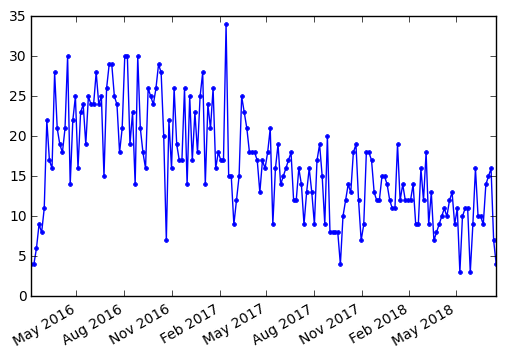

In [10]:
deaths = enc_data[pd.notnull(enc_data['DEATH_DATE'])].drop_duplicates('EMPI').copy()
deaths['count'] = 1

ts = deaths.set_index('DEATH_DATE').resample('5d',how=sum).fillna(0)
fig, ax = plt.subplots(1,1)
ax.plot_date(ts.index,ts['count'],'.-')
fig.autofmt_xdate()

In [11]:
deaths['count'].sum(),deaths['count'].sum()*1.0/enc_data['EMPI'].nunique()

(2936, 0.1106880301602262)

# Labs

In [12]:
q = """
SELECT
  ii.IDENTITY_ID as EMPI,
  o.PAT_ID,
  o.RESULT_TIME,
  z7.NAME ORDER_PRIORITY,
  cc.NAME,
  cc.EXTERNAL_NAME,
  cc.BASE_NAME,
  cc.COMMON_NAME,
  cc.LOINC_CODE,
  o_r.ORD_NUM_VALUE,
  o_r.REFERENCE_LOW,
  o_r.REFERENCE_HIGH,
  z10.NAME RESULT_FLAG,
  o_r.RESULT_IN_RANGE_YN
from (
    select distinct(p.PAT_ID)
    from PAT_ENC pe
    LEFT JOIN PATIENT p
      ON pe.PAT_ID = p.PAT_ID
    INNER JOIN IDENTITY_ID ID
      ON  pe.PAT_ID = ID.PAT_ID
      AND ID.IDENTITY_TYPE_ID = 105
    inner join CLARITY_DEP cd
      on pe.DEPARTMENT_ID = cd.DEPARTMENT_ID
      and pe.CONTACT_DATE >='2016-02-01'
      and pe.CONTACT_DATE < '2016-07-01'
    inner JOIN ZC_DISP_ENC_TYPE ZDET
      ON PE.ENC_TYPE_C = ZDET.DISP_ENC_TYPE_C
    INNER JOIN ZC_APPT_STATUS ZAS
      ON PE.APPT_STATUS_C = ZAS.APPT_STATUS_C
    left join clarity_ser cs
      on pe.VISIT_PROV_ID = cs.PROV_ID
    where cd.specialty in ('Oncology','Hematology/Oncology')
     AND ZDET.NAME IN ('Office Visit','Appointment')
    AND ZAS.NAME ='Completed'
) cohort
  left join ORDER_PROC o on o.PAT_ID = cohort.PAT_ID
  left join PATIENT p on p.PAT_ID = o.PAT_ID
  left join IDENTITY_ID ii on ii.PAT_ID = p.PAT_ID
    and IDENTITY_TYPE_ID = 105
  inner join ORDER_RESULTS o_r on o_r.ORDER_PROC_ID = o.ORDER_PROC_ID
  left join CLARITY_COMPONENT cc on cc.COMPONENT_ID = o_r.COMPONENT_ID
  left join ZC_ORDER_CLASS z1 on z1.ORDER_CLASS_C = o.ORDER_CLASS_C
  left join ZC_ORDER_TYPE z2 on z2.ORDER_TYPE_C = o.ORDER_TYPE_C
  left join ZC_LAB_STATUS z3 on z3.LAB_STATUS_C = o.LAB_STATUS_C
  left join ZC_ORDER_STATUS z4 on z4.ORDER_STATUS_C = o.ORDER_STATUS_C
  left join ZC_REASON_FOR_CANC z5 on z5.REASON_FOR_CANC_C = o.REASON_FOR_CANC_C
  left join ZC_RADIOLOGY_STS z6 on z6.RADIOLOGY_STATUS_C = o.RADIOLOGY_STATUS_C
  left join ZC_ORDER_PRIORITY z7 on z7.ORDER_PRIORITY_C = o.ORDER_PRIORITY_C
  left join ZC_SPECIMEN_TYPE z8 on z8.SPECIMEN_TYPE_C = o.SPECIMEN_TYPE_C
  left join ZC_SPECIMEN_SOURCE z9 on z9.SPECIMEN_SOURCE_C = o.SPECIMEN_SOURCE_C
  left join ZC_RESULT_FLAG z10 on z10.RESULT_FLAG_C = o_r.RESULT_FLAG_C
  left join ZC_RESULT_STATUS z11 on z11.RESULT_STATUS_C = o_r.RESULT_STATUS_C
  left join ZC_LAB_STATUS z12 on z12.LAB_STATUS_C = o_r.LAB_STATUS_C
  left join ZC_LAB_DATA_TYPE z13 on z13.LAB_DATA_TYPE_C = o_r.DATA_TYPE_C
  left join ZC_RES_DATA_TYPE z14 on z14.RES_DATA_TYPE_C = o_r.DATA_TYPE_C
WHERE z11.NAME = 'Final'
  AND o_r.ORD_NUM_VALUE != 9999999 AND o_r.ORD_NUM_VALUE is not NULL
  AND o_r.RESULT_TIME >= '2015-07-01' 
  AND o_r.RESULT_TIME <= '2016-07-01'
"""

lab_data = SQLquery2df(q,conn)
lab_data.shape

(8131978, 14)

In [13]:
top_lab_names = lab_data['EXTERNAL_NAME'].value_counts().head(100)
top_lab_names

MCV                               203050
RDW                               202949
MCH                               202893
MCHC                              202263
Hemoglobin                        202026
Hematocrit                        201113
Platelets                         199660
Red Blood Cells                   193984
Creatinine                        193977
White Blood Cells                 193295
Sodium                            185049
Urea Nitrogen                     182987
Chloride                          182553
Potassium                         181477
Anion Gap                         179919
Carbon Dioxide                    179734
Glucose                           179451
Calcium                           178244
ALT                               135121
AST                               135090
Bilirubin, Total                  134303
Alkaline Phosphatase              129036
# Eosinophils                     126298
# Basophils                       126289
# Monocytes     

In [14]:
lab_data = lab_data[lab_data['EXTERNAL_NAME'].isin(top_lab_names.index)]
lab_data.shape

(7204012, 14)

In [2]:
#lab_data.head()

In [16]:
lab_data['count'] = 1

In [17]:
rnd_idx = list(lab_data.index)
np.random.shuffle(rnd_idx)
ld = lab_data.loc[rnd_idx[:100000],:]

MCV RDW MCH MCHC Hemoglobin Hematocrit Platelets Red Blood Cells Creatinine White Blood Cells Sodium Urea Nitrogen Chloride Potassium Anion Gap Carbon Dioxide Glucose Calcium ALT AST Bilirubin, Total Alkaline Phosphatase # Eosinophils # Basophils # Monocytes # Lymphocytes % Monocytes % Lymphocytes # Neutrophils % Eosinophils % Basophils % Neutrophils Albumin Protein, Total POC Glucose (Fingerstick) MAGNESIUM % Nucleated RBC INR PT WBC Corrected VSS Fractions Prescribed VSS Total Dose Limit VSS Dose Given To Date VSS Fractions Treated # Band Neutrophils % Basophils Manual % Eosinophils Manual % Band Neutrophils # Atypical Lymphocytes % Lymph Variants % Segmented Neutrophils Manual % Monocytes Manual % Lymphocytes Manual # Segmented Neutrophils Manual PHOSPHATE PTT # Basophils Manual # Eosinophils Manual # Monocytes Manual # Lymphocytes Manual LACTATE DEHYDROGENASE INDIRECT BILI Bilirubin, Direct URIC ACID eGFR, Non-AA Ventricular Rate R Axis QRS Duration T Axis Q-T Interval QTC Calculat

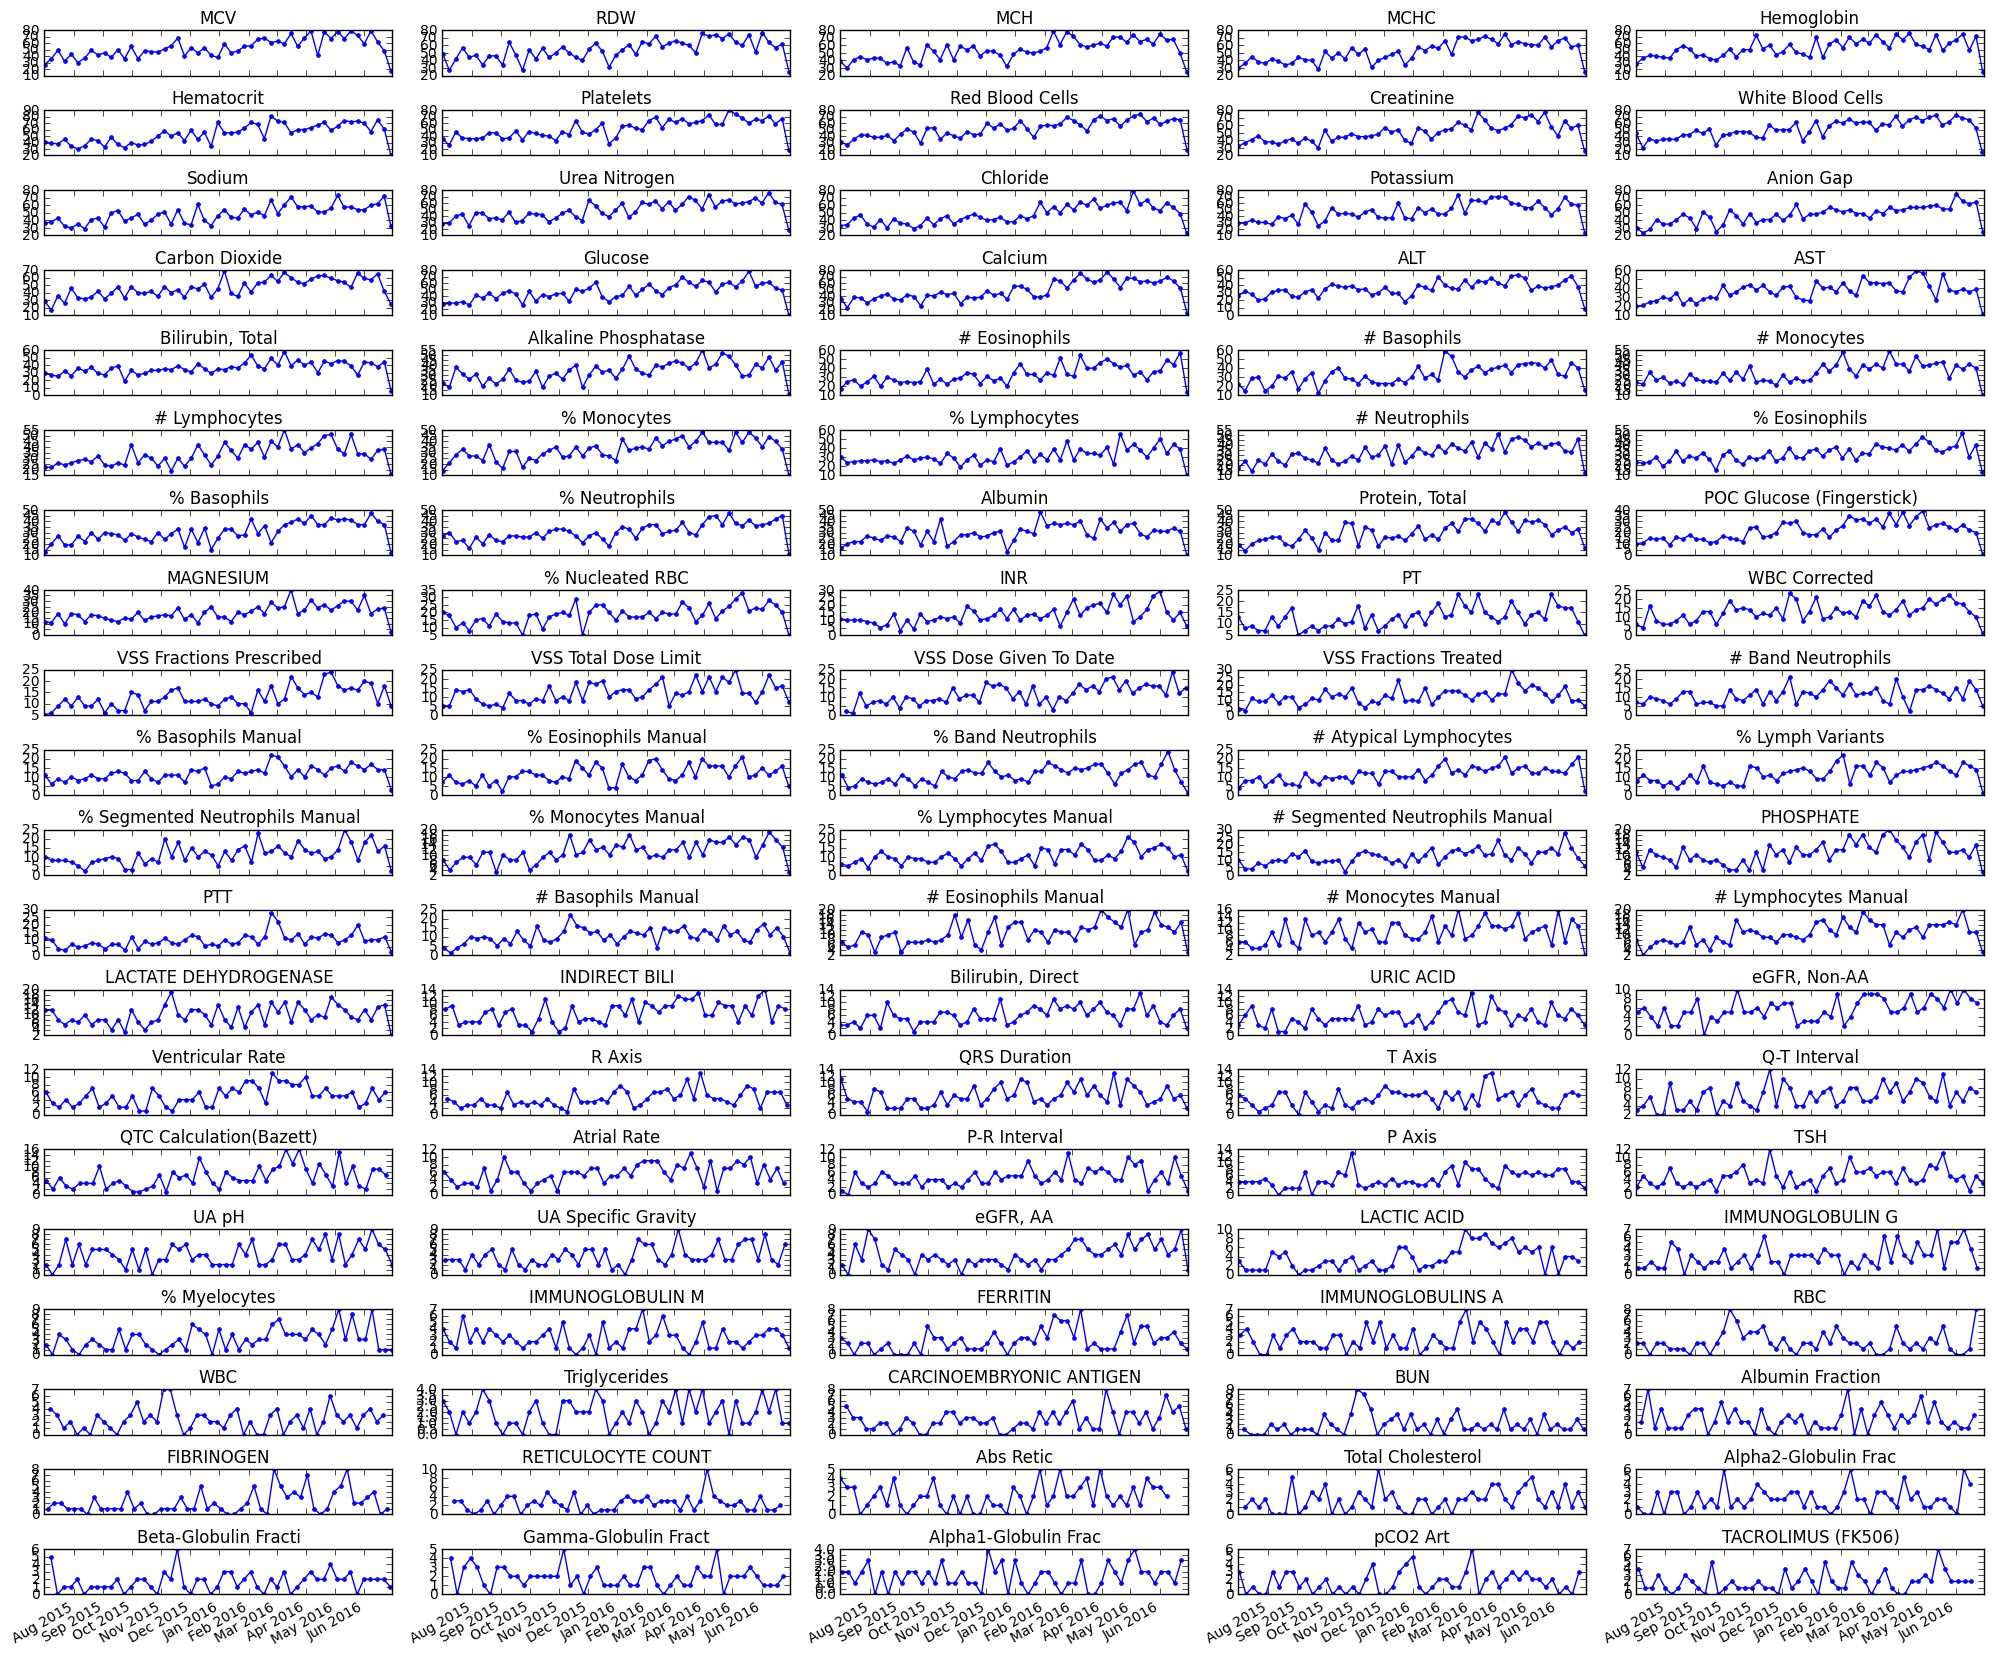

In [18]:
lab_name = 'MCV'

fig, axx = plt.subplots(20,5, figsize=(20,20),sharex=True)

for i,lab_name in enumerate(top_lab_names.index):
    tmp = ld[ld['EXTERNAL_NAME'] == lab_name][['EMPI','RESULT_TIME','count']]
    ts = tmp.set_index('RESULT_TIME').resample('7d',how=sum).fillna(0)

    ax = axx[i/5,i%5]
    
    ax.plot_date(ts.index,ts['count'],'.-')
    ax.set_title(lab_name)
    print(lab_name,)
fig.tight_layout()
fig.autofmt_xdate()

In [19]:
def get_numeric_features_one_patient(df, name, vn):
    g2 = df[(df['RESULT_TIME'] < vn[1]) & (df['RESULT_TIME'] > (vn[1]-datetime.timedelta(6*30)))].sort('RESULT_TIME')
    val = g2['ORD_NUM_VALUE']
    val = val[pd.notnull(val)]
    prop_stat = (g2['ORDER_PRIORITY'] == 'STAT').mean()
    if val.shape[0] > 0:
        return {
            'EMPI': vn[0],
            'APPT_TIME': vn[1],
            '{}: prop STAT ordered'.format(name): prop_stat,
            '{}: count'.format(name): val.count(),
            '{}: min'.format(name): val.min(),
            '{}: max'.format(name): val.max(),
            '{}: std'.format(name): val.std(),
            '{}: first'.format(name): val.iloc[0],
            '{}: last'.format(name): val.iloc[-1],
        }
    else:
        return {
            'EMPI': vn[0],
            'APPT_TIME': vn[1],
            '{}: prop STAT ordered'.format(name): 0,
            '{}: count'.format(name): 0,
            '{}: std'.format(name): 0,
        }

def get_numeric_features(df, name):
    agg_df = []
    for vn, g in df[df['EXTERNAL_NAME'] == name].groupby(['EMPI','APPT_TIME']):
        agg_df.append(get_numeric_features_one_patient(g, name, vn))
    return pd.DataFrame(agg_df)


In [20]:
enc_data['EMPI'] = enc_data['EMPI'].astype(int)
lab_data['EMPI'] = lab_data['EMPI'].astype(int)

In [21]:
lab_data.shape

(7204012, 15)

In [22]:
lab_data['ORDER_PRIORITY'].value_counts(dropna=False)

Routine                  5012256
STAT                     2183552
Today                       5449
Transplant (Lab Only)       2730
After xray                    25
NaN                            0
dtype: int64

In [23]:
labs_joined = enc_data[['EMPI','APPT_TIME']].merge(lab_data,how='left',on='EMPI')
labs_joined.shape

(32661643, 16)

In [3]:
#labs_joined.head()

In [4]:
#get_numeric_features(labs_joined.head(100000), name='MCV')

In [93]:
top_lab_names.head(15)

MCV                  203050
RDW                  202949
MCH                  202893
MCHC                 202263
Hemoglobin           202026
Hematocrit           201113
Platelets            199660
Red Blood Cells      193984
Creatinine           193977
White Blood Cells    193295
Sodium               185049
Urea Nitrogen        182987
Chloride             182553
Potassium            181477
Anion Gap            179919
dtype: int64

In [25]:
num_cols = []
vectorized_features_num = None
for name in top_lab_names.index:
    print(name,)
    agg_df = get_numeric_features(labs_joined, name=name)
    if vectorized_features_num is None:
        vectorized_features_num = agg_df
    else:
        if agg_df.shape[0] > 0:
            num_cols.extend([c for c in agg_df if c not in ['APPT_TIME','EMPI']])
            vectorized_features_num = vectorized_features_num.merge(agg_df, on=['APPT_TIME','EMPI'], how='outer')
vectorized_features_num.shape

MCV RDW MCH MCHC Hemoglobin Hematocrit Platelets Red Blood Cells Creatinine White Blood Cells Sodium Urea Nitrogen Chloride Potassium Anion Gap Carbon Dioxide Glucose Calcium ALT AST Bilirubin, Total Alkaline Phosphatase # Eosinophils # Basophils # Monocytes # Lymphocytes % Monocytes % Lymphocytes # Neutrophils % Eosinophils % Basophils % Neutrophils Albumin Protein, Total POC Glucose (Fingerstick) MAGNESIUM % Nucleated RBC INR PT WBC Corrected VSS Fractions Prescribed VSS Total Dose Limit VSS Dose Given To Date VSS Fractions Treated # Band Neutrophils % Basophils Manual % Eosinophils Manual % Band Neutrophils # Atypical Lymphocytes % Lymph Variants % Segmented Neutrophils Manual % Monocytes Manual % Lymphocytes Manual # Segmented Neutrophils Manual PHOSPHATE PTT # Basophils Manual # Eosinophils Manual # Monocytes Manual # Lymphocytes Manual LACTATE DEHYDROGENASE INDIRECT BILI Bilirubin, Direct URIC ACID eGFR, Non-AA Ventricular Rate R Axis QRS Duration T Axis Q-T Interval QTC Calculat

(56674, 702)

In [26]:
num_cols

['RDW: count',
 'RDW: first',
 'RDW: last',
 'RDW: max',
 'RDW: min',
 'RDW: prop STAT ordered',
 'RDW: std',
 'MCH: count',
 'MCH: first',
 'MCH: last',
 'MCH: max',
 'MCH: min',
 'MCH: prop STAT ordered',
 'MCH: std',
 'MCHC: count',
 'MCHC: first',
 'MCHC: last',
 'MCHC: max',
 'MCHC: min',
 'MCHC: prop STAT ordered',
 'MCHC: std',
 'Hemoglobin: count',
 'Hemoglobin: first',
 'Hemoglobin: last',
 'Hemoglobin: max',
 'Hemoglobin: min',
 'Hemoglobin: prop STAT ordered',
 'Hemoglobin: std',
 'Hematocrit: count',
 'Hematocrit: first',
 'Hematocrit: last',
 'Hematocrit: max',
 'Hematocrit: min',
 'Hematocrit: prop STAT ordered',
 'Hematocrit: std',
 'Platelets: count',
 'Platelets: first',
 'Platelets: last',
 'Platelets: max',
 'Platelets: min',
 'Platelets: prop STAT ordered',
 'Platelets: std',
 'Red Blood Cells: count',
 'Red Blood Cells: first',
 'Red Blood Cells: last',
 'Red Blood Cells: max',
 'Red Blood Cells: min',
 'Red Blood Cells: prop STAT ordered',
 'Red Blood Cells: std',

In [27]:
for c in num_cols:
    if c in enc_data:
        del enc_data[c]

In [28]:
enc_data.shape

(62377, 12)

In [29]:
enc_data = enc_data.merge(vectorized_features_num,how='outer',on=['APPT_TIME','EMPI'])

In [34]:
enc_data.shape

(62377, 774)

In [2]:
# Write
#enc_data.to_csv('OutpatientONC_v1_1_enc_w_labs.csv',index=False)

# Read
# enc_data = pd.read_csv('OutpatientONC_v1_1_enc_w_labs.csv')
# enc_data.shape

In [4]:
enc_data['EMPI'].nunique()

26525

In [5]:
enc_data['APPT_TIME'] = pd.to_datetime(enc_data['APPT_TIME'])
enc_data['EMPI'] = enc_data['EMPI'].astype(int)

# Dx

In [6]:
ELIXHAUSER = {
              'CHF':{'label':'Congestive heart failure',
                       'icd10': ['I099', 'I1(10|3[02])', 'I255', 'I4(2[056789]|3)', 'I50', 'P290'],
                       'icd9': ['39891', '402(01|11|91)', '404(01|03|[19][13])', '42(5[456789]|8)']},
              'Arrhy':{'label':'Cardiac arrhythmias',
                      'icd10': ['I44[123]', 'I456', 'I459','I4[789]', 'R00[018]', 'T821','Z[49]50'],
                      'icd9':['426([079]|1[023])', '427[01234]','V450', 'V533']},
              'VD':{'label':'Valvular disease',
                      'icd10': ['A520', 'I0[5678]','I09[18]', 'I3[456789]','Q23[0123]', 'Z95[234]'],
                      'icd9':['0932', '39[4567]', '424','746[3456]', 'V422', 'V433']},
              'PCD':{'label':'Pulmonary circulation disorder',
                      'icd10': ['I2([67]|8[089])'],
                      'icd9':['415[01]', '416','417[089]']},
              'PVD':{'label':'Pulmonary valvular discorder',
                      'icd10': ['I7([01]|3[189]|71|9[02])', 'K55[189]', 'Z95[89]'],
                      'icd9': ['0930', '4373', '44([01]|3[123456789])', '4471', '557[19]', 'V434']},
              'HPTN_UC':{'label':'Hypertension, uncomplicated',
                      'icd10': ['I10'],
                      'icd9':['401']},
              'HPTN_C':{'label':'Hypertension, complicated',
                      'icd10': ['I1[1235]'],
                      'icd9':['40[2345]']},
              'Paralysis':{'label':'Paralysis',
                      'icd10': ['G041', 'G114', 'G8(0[12]|[12]|3[012349])'],
                      'icd9': ['3341', '34([23]|4[01234569])']},
              'OthND':{'label':'Other neurological disorders',
                      'icd10':['G1[0123]', 'G2[012]', 'G25[45]','G31[289]','G3[2567]','G4[01]', 'G93[14]','R470', 'R56'],
                      'icd9': ['3319', '332[01]','333[45]','33([45]|62)','34([015]|8[13])','78[04]3']},
              'COPD':{'label':'Chronic pulmonary disease',
                      'icd10': ['I27[89]', 'J4[01234567]', 'J6([01234567]|84)', 'J70[13]'],
                      'icd9': ['416[89]', '49', '50([012345]|64|8[18])']},
              'Diab_UC':{'label':'Diabetes uncomplicated',
                      'icd10': ['E1[01234][019]'],
                      'icd9': ['250[0123]']},
              'Diab_C':{'label':'Diabetes complicated',
                      'icd10': ['E1[01234][2345678]'],
                      'icd9': ['250[456789]']},
              'Hptothy':{'label':'Hypothyroidism',
                      'icd10': ['E0[0123]', 'E890'],
                      'icd9':['2409', '24([34]|6[18])']},
              'RF':{'label':'Renal failure',
                      'icd10': ['I120', 'I131', 'N1[89]', 'N250', 'Z49[012]', 'Z940', 'Z992'],
                      'icd9': ['403', '404', '58([56]|80)', 'V4(20|51)', 'V56']},
              'LD':{'label':'Liver disease',
                      'icd10': ['B18', 'I8(5|64)', 'I982', 'K7(0|1[13457]|[234]|6[023456789])', 'Z944'],
                      'icd9': ['070([23]|[45])', '456[012]', '57([01]|2[2345678]|3[3489])', 'V427']},
              'PUD_NB':{'label':'Peptic ulcer disease excluding bleeding',
                      'icd10': ['K2[5678][79]'],
                      'icd9': ['53[1234][79]']},
              'HIV':{'label':'AIDS/HIV',
                      'icd10': ['B2[0124]'],
                      'icd9': ['04[234]']},
              'Lymp':{'label':'Lymphoma',
                      'icd10': ['C8[123458]','C96', 'C90[02]'],
                      'icd9':['20[012]', '2030', '2386']},
              'METS':{'label':'Metastatic cancer',
                      'icd10': ['C7[789]', 'C80'],
                      'icd9': ['19[6789]']},
              'Tumor':{'label':'Solid tumor without metastasis',
                      'icd10': ['C[01]', 'C2[0123456]','C3[01234789]', 'C4[01356789]', 'C5[012345678]','C6', 'C7[0123456]', 'C97'],
                      'icd9': ['1[456]', '17[012456789]', '18', '19([012345])']},
              'Rheum_A':{'label':'Rheumatoid arthritis/collagen vascular diseases',
                      'icd10': ['L94[013]', 'M0[568]', 'M12[03]','M3(0|1[0123]|[2345])', 'M4(5|6[189])'],
                      'icd9': ['446', '7010', '71(0[0123489]|12|4|93)', '72([05]|8[58]|93)']},
              'Coag':{'label':'Coagulopathy',
                     'icd10': ['D6[5678]','D69[13456]'],
                      'icd9':['286', '2871', '287[345]']},
              'Obesity':{'label':'Obesity',
                      'icd10': ['E66'],
                      'icd9':['2780']},
              'WL':{'label':'Weight loss',
                      'icd10':['E4[0123456]', 'R634', 'R64'],
                      'icd9':['26[0123]', '7832', '7994']},
              'Fluid':{'label':'Fluid and electroylte disorders',
                      'icd10': ['E222', 'E8[67]'],
                      'icd9':['2536', '276']},
              'BLA':{'label':'Blood loss anemia',
                      'icd10': ['D500'],
                      'icd9':['2800']},
              'DA':{'label':'Deficiency anemia',
                      'icd10': ['D50[89]', 'D5[123]'],
                      'icd9':['280[123456789]', '281']},
              'Alcohol':{'label':'Alcohol abuse',
                      'icd10': ['F10', 'E52', 'G621', 'I426','K292', 'K70[039]','T51', 'Z502','Z714', 'Z721'],
                      'icd9':['2652', '291[12356789]','303[09]', '3050', '3575','4255', '5353', '571[0123]', '980', 'V113']},
              'Drug':{'label': 'Drug abuse',
                      'icd10': ['F1[12345689]','Z715', 'Z722'],
                      'icd9':['292', '304', '305[23456789]', 'V6542']},
              'Psych':{'label':'Psychoses',
                      'icd10': ['F2[0234589]','F3([01]2|15)'],
                      'icd9':['2938','296[0145]4','29[578]']},
              'Dep':{'label':'Depression',
                      'icd10': ['F204','F31[345]', 'F3[23]','F341', 'F4[13]2'],
                      'icd9':['296[235]','3004', '309', '311']}
}

In [7]:
pd.DataFrame(ELIXHAUSER).T

icd10  \
Alcohol    [F10, E52, G621, I426, K292, K70[039], T51, Z5...   
Arrhy      [I44[123], I456, I459, I4[789], R00[018], T821...   
BLA                                                   [D500]   
CHF        [I099, I1(10|3[02]), I255, I4(2[056789]|3), I5...   
COPD       [I27[89], J4[01234567], J6([01234567]|84), J70...   
Coag                                  [D6[5678], D69[13456]]   
DA                                        [D50[89], D5[123]]   
Dep                  [F204, F31[345], F3[23], F341, F4[13]2]   
Diab_C                                  [E1[01234][2345678]]   
Diab_UC                                     [E1[01234][019]]   
Drug                              [F1[12345689], Z715, Z722]   
Fluid                                         [E222, E8[67]]   
HIV                                               [B2[0124]]   
HPTN_C                                            [I1[1235]]   
HPTN_UC                                                [I10]   
Hptothy                                     [E0[0123], E890]   
LD         [B18, I8(5|64), I982, K7(0|1[13457]|[234]|6[02...   
Lymp                              [C8[123458], C96, C90[02]]   
METS                                          [C7[789], C80]   
Obesity                                                [E66]   
OthND      [G1[0123], G2[012], G25[45], G31[289], G3[2567...   
PCD                                        [I2([67]|8[089])]   
PUD_NB                                        [K2[5678][79]]   
PVD            [I7([01]|3[189]|71|9[02]), K55[189], Z95[89]]   
Paralysis             [G041, G114, G8(0[12]|[12]|3[012349])]   
Psych                            [F2[0234589], F3([01]2|15)]   
RF          [I120, I131, N1[89], N250, Z49[012], Z940, Z992]   
Rheum_A    [L94[013], M0[568], M12[03], M3(0|1[0123]|[234...   
Tumor      [C[01], C2[0123456], C3[01234789], C4[01356789...   
VD         [A520, I0[5678], I09[18], I3[456789], Q23[0123...   
WL                                  [E4[0123456], R634, R64]   

                                                        icd9  \
Alcohol    [2652, 291[12356789], 303[09], 3050, 3575, 425...   
Arrhy            [426([079]|1[023]), 427[01234], V450, V533]   
BLA                                                   [2800]   
CHF        [39891, 402(01|11|91), 404(01|03|[19][13]), 42...   
COPD                    [416[89], 49, 50([012345]|64|8[18])]   
Coag                                   [286, 2871, 287[345]]   
DA                                     [280[123456789], 281]   
Dep                               [296[235], 3004, 309, 311]   
Diab_C                                         [250[456789]]   
Diab_UC                                          [250[0123]]   
Drug                        [292, 304, 305[23456789], V6542]   
Fluid                                            [2536, 276]   
HIV                                                [04[234]]   
HPTN_C                                            [40[2345]]   
HPTN_UC                                                [401]   
Hptothy                               [2409, 24([34]|6[18])]   
LD         [070([23]|[45]), 456[012], 57([01]|2[2345678]|...   
Lymp                                   [20[012], 2030, 2386]   
METS                                              [19[6789]]   
Obesity                                               [2780]   
OthND      [3319, 332[01], 333[45], 33([45]|62), 34([015]...   
PCD                                 [415[01], 416, 417[089]]   
PUD_NB                                        [53[1234][79]]   
PVD        [0930, 4373, 44([01]|3[123456789]), 4471, 557[...   
Paralysis                       [3341, 34([23]|4[01234569])]   
Psych                            [2938, 296[0145]4, 29[578]]   
RF                   [403, 404, 58([56]|80), V4(20|51), V56]   
Rheum_A    [446, 7010, 71(0[0123489]|12|4|93), 72([05]|8[...   
Tumor              [1[456], 17[012456789], 18, 19([012345])]   
VD              [0932, 39[4567], 424, 746[3456], V422, V433]   
WL                    

In [8]:
## get counts per EMPI before time of prediction
vc_comorbs = {}
vc_comorbs_last_6months = {}
for comorbidity in ELIXHAUSER.keys():
    # Load
    dx_hist = pd.read_csv('Palliative_Data/dx_hist_ELIXHAUSER_{}.csv'.format(comorbidity))
    dx_hist = dx_hist[pd.notnull(dx_hist['EMPI'])]
    dx_hist['EMPI'] = dx_hist['EMPI'].astype(int)
    dx_hist['ENC_DATE'] = pd.to_datetime(dx_hist['ENC_DATE'])
    
    # Filter out dx after time of pred
    dx_hist = enc_data[['EMPI','APPT_TIME']].merge(dx_hist,how='left',on='EMPI')
    dx_hist = dx_hist[dx_hist['APPT_TIME'] > dx_hist['ENC_DATE']]
    
    # groupby EMP and count
    vc_comorbs[comorbidity] = dx_hist[['EMPI','APPT_TIME']].groupby(['EMPI','APPT_TIME']).size().reset_index()
    print(comorbidity, vc_comorbs[comorbidity].shape)
    
    # Count 'recent' comorbs
    dx_hist = dx_hist[dx_hist['ENC_DATE'] > (dx_hist['APPT_TIME'] - datetime.timedelta(6*30))]
    vc_comorbs_last_6months[comorbidity] = dx_hist[['EMPI','APPT_TIME']].groupby(['EMPI','APPT_TIME']).size().reset_index()

METS (54851, 3)
Diab_UC (60135, 3)
Alcohol (62041, 3)
Rheum_A (61378, 3)
WL (54895, 3)
DA (58241, 3)
Lymp (60972, 3)
Arrhy (54343, 3)
PCD (59121, 3)
LD (59570, 3)
Obesity (59672, 3)
COPD (57804, 3)
HPTN_UC (55837, 3)
Fluid (51673, 3)
RF (58348, 3)
OthND (59506, 3)
PVD (59201, 3)
PUD_NB (61812, 3)
Hptothy (58774, 3)
VD (59748, 3)
CHF (58836, 3)
Dep (57882, 3)
Paralysis (61541, 3)
Drug (61329, 3)
Diab_C (59338, 3)
Coag (54718, 3)
BLA (59608, 3)
Tumor (58803, 3)
HIV (62302, 3)
HPTN_C (58426, 3)
Psych (62251, 3)


In [9]:
# Join to reg_data
dx_cols = []
for comorbidity in ELIXHAUSER.keys():
    comorb_counts = vc_comorbs[comorbidity]
    c_name = 'n_'+comorbidity
    comorb_counts.columns = ['EMPI','APPT_TIME',c_name]
    if c_name in enc_data:
        del enc_data[c_name]
    enc_data = enc_data.merge(comorb_counts, how='left',on=['EMPI','APPT_TIME'])
    enc_data[c_name] = enc_data[c_name].fillna(0)
    dx_cols.append(c_name)
    
    comorb_counts = vc_comorbs_last_6months[comorbidity]
    c_name = 'n_'+comorbidity+'_recent'
    comorb_counts.columns = ['EMPI','APPT_TIME',c_name]
    if c_name in enc_data:
        del enc_data[c_name]
    enc_data = enc_data.merge(comorb_counts, how='left',on=['EMPI','APPT_TIME'])
    enc_data[c_name] = enc_data[c_name].fillna(0)
    dx_cols.append(c_name)

dx_cols

['n_METS',
 'n_METS_recent',
 'n_Diab_UC',
 'n_Diab_UC_recent',
 'n_Alcohol',
 'n_Alcohol_recent',
 'n_Rheum_A',
 'n_Rheum_A_recent',
 'n_WL',
 'n_WL_recent',
 'n_DA',
 'n_DA_recent',
 'n_Lymp',
 'n_Lymp_recent',
 'n_Arrhy',
 'n_Arrhy_recent',
 'n_PCD',
 'n_PCD_recent',
 'n_LD',
 'n_LD_recent',
 'n_Obesity',
 'n_Obesity_recent',
 'n_COPD',
 'n_COPD_recent',
 'n_HPTN_UC',
 'n_HPTN_UC_recent',
 'n_Fluid',
 'n_Fluid_recent',
 'n_RF',
 'n_RF_recent',
 'n_OthND',
 'n_OthND_recent',
 'n_PVD',
 'n_PVD_recent',
 'n_PUD_NB',
 'n_PUD_NB_recent',
 'n_Hptothy',
 'n_Hptothy_recent',
 'n_VD',
 'n_VD_recent',
 'n_CHF',
 'n_CHF_recent',
 'n_Dep',
 'n_Dep_recent',
 'n_Paralysis',
 'n_Paralysis_recent',
 'n_Drug',
 'n_Drug_recent',
 'n_Diab_C',
 'n_Diab_C_recent',
 'n_Coag',
 'n_Coag_recent',
 'n_BLA',
 'n_BLA_recent',
 'n_Tumor',
 'n_Tumor_recent',
 'n_HIV',
 'n_HIV_recent',
 'n_HPTN_C',
 'n_HPTN_C_recent',
 'n_Psych',
 'n_Psych_recent']

In [10]:
DAYS_IN_NS = 8.64e+13

In [11]:
def timedelta_in_years(td):
    if pd.isnull(td):
        return np.nan
    else:
        return float(td)/ (365.25 * DAYS_IN_NS)
    

enc_data['DEATH_DATE'] = pd.to_datetime(enc_data['DEATH_DATE'])
enc_data['BIRTH_DATE'] = pd.to_datetime(enc_data['BIRTH_DATE'])

enc_data['PAT_AGE'] = (enc_data['APPT_TIME'] - enc_data['BIRTH_DATE'])
enc_data['PAT_AGE'] = enc_data['PAT_AGE'].apply(timedelta_in_years)

### Create label

In [12]:
enc_data['label'] = (enc_data['DEATH_DATE'] - enc_data['APPT_TIME']) < (30 * 6 * DAYS_IN_NS)

In [13]:
enc_data['label'].mean()

0.074017666768199819

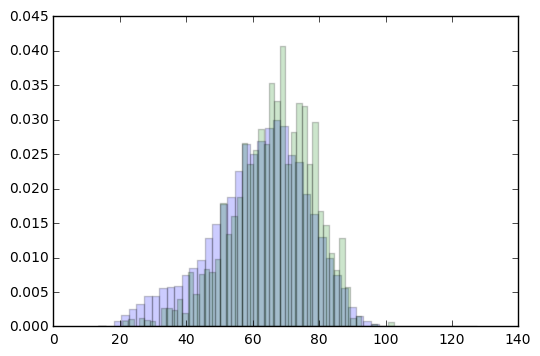

In [14]:
fig, ax = plt.subplots(1,1)
ax.hist(enc_data['PAT_AGE'][~enc_data['label']].values,bins=50,normed=True,alpha=0.2)
ax.hist(enc_data['PAT_AGE'][enc_data['label']].values,bins=50,normed=True,alpha=0.2)
plt.show()

# Describe

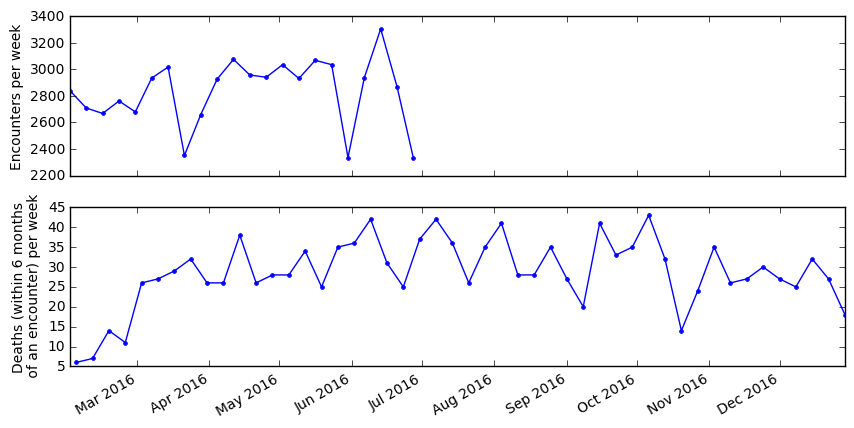

In [16]:
enc_data['count'] = 1

ts = enc_data.set_index('APPT_TIME').resample('7d',how=sum).fillna(0)
fig, ax = plt.subplots(2,1,sharex=True,figsize=(10,5))
ax[0].plot_date(ts.index,ts['count'],'.-',label='Encounters')
ax[0].set_ylabel('Encounters per week')

deaths = enc_data[pd.notnull(enc_data['DEATH_DATE'])].drop_duplicates('EMPI').copy()
deaths = deaths[deaths['DEATH_DATE'] < datetime.datetime(2017,1,1)]
ts = deaths.set_index('DEATH_DATE').resample('7d',how=sum).fillna(0)
ax[1].plot_date(ts.index,ts['count'],'.-',label='Deaths')
ax[1].set_ylabel('Deaths (within 6 months\n of an encounter) per week')
fig.autofmt_xdate()

In [17]:
from scipy import stats

def iqr(x):
    return pd.Series(x).quantile(0.25),pd.Series(x).quantile(0.75)


def ci(x,interval=0.95):
    norm_interval = stats.norm.interval(interval)
    return x.mean()+(np.array(norm_interval)*x.std())


def ztest_proportion_two_samples(x1, n1, x2, n2, one_sided=False):
    x1, n1, x2, n2 = float(x1), float(n1), float(x2), float(n2)
    p1 = x1/n1
    p2 = x2/n2    

    p = (x1+x2)/(n1+n2)
    se = p*(1-p)*(1/n1+1/n2)
    se = sqrt(se)
    
    z = (p1-p2)/se
    p = 1-stats.norm.cdf(abs(z))
    p *= 2-one_sided # if not one_sided: p *= 2
    return z, p

#z, p = ztest_proportion_two_samples(15,30,19,25)

def pvalue(pval):    
    if pval < 0.001:
        pval_s = '<0.001'
    else:
        pval_s = '{:.3f}'.format(pval)
        
    if pval <= 0.05:
        pval_s += '*'
        
    return pval_s


def mean_pval(VAR, LABEL, stat, types='whole', mean_sigfigs = 1,
              median_sigfigs=0, analysis_pre=None,
              analysis_post=None,add_counts=False,
              add_iqr=False,
              add_ci=False,
              add_std=False,
              test_type='mannwhitneyu'):
    var_pre = np.array([v for v in analysis_pre[VAR].values if pd.notnull(v)])
    var_post = np.array([v for v in analysis_post[VAR].values if pd.notnull(v)])
    n_pre, n_post = var_pre.shape[0],var_post.shape[0]
    if test_type == 'mannwhitneyu':
        score,pval = stats.mannwhitneyu(var_pre,var_post)
        pval = pval * 2 # mannwhitneyu results in a p-value half the size the 'two-sided' p-value 
    elif test_type == 't-test':
        score,pval = stats.ttest_ind(var_pre,var_post)
        
    if stat == 'mean':
        if types == 'whole':
            format_set = '{:.' + str(mean_sigfigs) + 'f}'
            var_pre_s = format_set.format(var_pre.mean())
            var_post_s = format_set.format(var_post.mean())
        elif types == 'percent':   
            var_pre_s = '{:.1%}'.format(var_pre.mean())
            var_post_s = '{:.1%}'.format(var_post.mean())
    elif stat == 'median':
        format_set = '{:.' + str(median_sigfigs) + 'f}'
        var_pre_s = format_set.format(np.percentile(var_pre,50)) + ' ( '+format_set.format(np.percentile(var_pre,25)) + ' - '+ format_set.format(np.percentile(var_pre,75)) + ' )' 
        var_post_s = format_set.format(np.percentile(var_post,50)) + ' ( '+ format_set.format(np.percentile(var_post,25)) + ' - '+ format_set.format(np.percentile(var_post,75)) + ' )'
        
    if add_iqr:
        var_pre_s += ' [%0.1f-%0.1f]'%tuple(iqr(var_pre))
        var_post_s += ' [%0.1f-%0.1f]'%tuple(iqr(var_post))
        
    if add_ci:
        var_pre_s += ' [%0.1f-%0.1f]'%tuple(ci(var_pre,0.95))
        var_post_s += ' [%0.1f-%0.1f]'%tuple(ci(var_post,0.95))

    if add_std:
        var_pre_s += ' σ=%0.1f'%(var_pre.std())
        var_post_s += ' σ=%0.1f'%(var_post.std())

    if add_counts:
        var_pre_s += ' (n=%i)'%n_pre
        var_post_s += ' (n=%i)'%n_post
        
        
    return {'Characteristic':LABEL,
            Pre_Intervention:var_pre_s,
            Post_Intervention:var_post_s,
            'P-value':pvalue(pval)}


def prop_count_pval(VAR,LABEL,stat,types='whole',mean_sigfigs = 1,median_sigfigs=0,analysis_pre=None,analysis_post=None,add_counts=False):
    var_pre = np.array([v for v in analysis_pre[VAR].values if pd.notnull(v)])
    var_post = np.array([v for v in analysis_post[VAR].values if pd.notnull(v)])
    n_pre, n_post = var_pre.shape[0],var_post.shape[0]
    

  
    var_pre_s = '{:.1%}'.format(var_pre.mean())
    var_post_s = '{:.1%}'.format(var_post.mean())

    positive_pre = var_pre.sum()
    positive_post = var_post.sum()
    
    if add_counts:
        var_pre_s += ' (%i/%i)'%(positive_pre, n_pre)
        var_post_s += ' (%i/%i)'%(positive_post,n_post)
        
    score, pval = ztest_proportion_two_samples(positive_pre,n_pre,positive_post,n_post)
    
    return {'Characteristic':LABEL,
            Pre_Intervention:var_pre_s,
            Post_Intervention:var_post_s,
            'P-value':pvalue(pval)}


def categories(VAR,analysis_pre=None,analysis_post=None):
    var_pre = analysis_pre[VAR].value_counts().sort_index() 
    var_post = analysis_post[VAR].value_counts().sort_index()
    
    # In case there are entire categories missing in one
    var_categories = list(set(var_pre.index).union(set(var_post.index)))
    var_pre = pd.concat([pd.Series(index=var_categories),var_pre],1)[1].replace(np.nan,0)
    var_post = pd.concat([pd.Series(index=var_categories),var_post],1)[1].replace(np.nan,0)
    var_order = np.argsort(var_pre.values)[::-1]
    obs = np.array([var_pre.values  ,var_post.values])
    chis,pval,dof,exp = stats.chi2_contingency(obs)
    
    pop_pre = analysis_pre.shape[0]
    pop_post = analysis_post.shape[0]
    
    var_pre_c = [ '{:,}'.format(v) +  ' ( {:.1%}'.format(v/float(pop_pre)) + ' )'for v in var_pre.values[var_order]]  
    var_post_c = [ '{:,}'.format(v) +  ' ( {:.1%}'.format(v/float(pop_post)) + ' )'for v in var_post.values[var_order]]
    pval = pvalue(pval)
    Characteristic = [str(i) for i in var_pre.index[var_order]]
    
    return_list = []
    for i in np.arange(len(Characteristic)):
        temp = {'Characteristic':Characteristic[i],
           Pre_Intervention:var_pre_c[i],
           Post_Intervention:var_post_c[i]}
        if i == 0:
            temp['P-value']=pval
        return_list.append(temp)
        
    return return_list

In [18]:
def mk_table1(pre,post):
    columns = ['Characteristic',Pre_Intervention,Post_Intervention,'P-value']
    data = []
    
    data.append(mean_pval(VAR='PAT_AGE',LABEL='Mean Age, years [IQR]',stat='mean',analysis_pre=pre,analysis_post=post,add_iqr=True))
    data.append({'Characteristic':'Specialty'})
    data.extend(categories('SPECIALTY',analysis_pre=pre,analysis_post=post))
    data.append({'Characteristic':''})
    
    data.append(prop_count_pval(VAR='FEMALE',LABEL='Female ',stat='mean',types='percent',analysis_pre=pre,analysis_post=post,add_counts=True))

    report = pd.DataFrame(data=data).fillna('')
    report = report[columns]
    return report.set_index(columns[0])

In [19]:
enc_data['FEMALE'] = enc_data['SEX_C'] == 1

In [21]:
analysis_pre = enc_data[~enc_data['label']]
analysis_post = enc_data[enc_data['label']]

Pre_Intervention = 'False (n=' + str(analysis_pre.shape[0]) + ')'
Post_Intervention = 'True (n=' + str(analysis_post.shape[0]) + ')'

alert_report = mk_table1(analysis_pre,analysis_post).copy()
alert_report.to_clipboard()
alert_report

False (n=57760)      True (n=4617)  P-value
Characteristic                                                        
Mean Age, years [IQR]     61.7 [52.8-72.0]   65.9 [58.2-74.8]  <0.001*
Specialty                                                             
Oncology                  34,490 ( 59.7% )    2,917 ( 63.2% )  <0.001*
Hematology/Oncology       23,270 ( 40.3% )    1,700 ( 36.8% )         
                                                                      
Female                 59.4% (34293/57760)  49.4% (2280/4617)  <0.001*

In [22]:
def mk_table2(pre,post):
    columns = ['Characteristic',Pre_Intervention,Post_Intervention,'P-value']
    data = []
    
    for c in dx_vars:
        data.append(mean_pval(VAR=c,LABEL=c[2:],stat='mean',analysis_pre=pre,analysis_post=post,add_std=True))

    report = pd.DataFrame(data=data).fillna('')
    report = report[columns]
    return report.set_index(columns[0])


dx_vars = [c for c in enc_data if 'n_' in c and '_recent' not in c]
alert_report = mk_table2(analysis_pre,analysis_post).copy()
alert_report.to_clipboard()
alert_report

False (n=57760) True (n=4617)  P-value
Characteristic                                       
METS                4.3 σ=15.2   11.4 σ=30.1  <0.001*
Diab_UC             2.8 σ=10.2    4.5 σ=18.5  <0.001*
Alcohol              1.1 σ=1.9     1.1 σ=0.9    0.193
Rheum_A              1.6 σ=6.6     1.7 σ=7.9    0.918
WL                   1.1 σ=2.0     1.3 σ=1.9  <0.001*
DA                   1.6 σ=6.2     1.2 σ=2.0   0.046*
Lymp               10.1 σ=38.6    9.9 σ=47.0  <0.001*
Arrhy               2.4 σ=12.2    3.4 σ=18.8   0.012*
PCD                  1.4 σ=5.1     1.7 σ=5.8  <0.001*
LD                   1.6 σ=6.5     1.7 σ=7.3    0.349
Obesity              1.4 σ=3.2     1.2 σ=1.8    0.051
COPD                 2.0 σ=6.8     2.1 σ=5.9  <0.001*
HPTN_UC             4.8 σ=12.2    6.8 σ=18.2  <0.001*
Fluid                1.9 σ=7.6     2.4 σ=7.5  <0.001*
RF                  2.6 σ=12.8    3.3 σ=14.8  <0.001*
OthND                1.3 σ=3.3     1.3 σ=2.6   0.013*
PVD                  1.3 σ=3.8    1.7 σ=10.1  <0.001*
PUD_NB               1.0 σ=2.0     1.1 σ=0.7    0.139
Hptothy              1.9 σ=5.1     1.9 σ=5.7   0.002*
VD                   1.8 σ=8.5     1.7 σ=8.4   0.012*
CHF                  1.7 σ=7.6    2.2 σ=10.2  <0.001*
Dep                  1.6 σ=4.3     1.7 σ=4.3    0.051
Paralysis            1.0 σ=0.4     1.0 σ=0.3    0.674
Drug                 1.0 σ=0.9     1.1 σ=2.2   0.035*
Diab_C               1.3 σ=3.7     1.4 σ=3.9  <0.001*
Coag                1.8 σ=10.7     1.5 σ=4.1    0.181
BLA                  1.0 σ=1.5     1.0 σ=0.3  <0.001*
Tumor              28.9 σ=48.5   53.8 σ=68.9  <0.001*
HIV                  1.2 σ=3.4     1.2 σ=7.3    0.851
HPTN_C               1.1 σ=1.8     1.3 σ=2.1  <0.001*
Psych                1.0 σ=0.9     1.0 σ=0.7    0.880

In [23]:
dx_vars = [c for c in enc_data if 'n_' in c and '_recent' in c]
alert_report = mk_table2(analysis_pre,analysis_post).copy()
alert_report.to_clipboard()
alert_report

False (n=57760) True (n=4617)  P-value
Characteristic                                         
METS_recent            1.2 σ=5.0     4.2 σ=9.5  <0.001*
Diab_UC_recent         0.2 σ=0.8     0.4 σ=1.4  <0.001*
Alcohol_recent         0.0 σ=0.3     0.0 σ=0.3    0.528
Rheum_A_recent         0.1 σ=1.0     0.1 σ=0.7    0.509
WL_recent              0.1 σ=0.5     0.3 σ=1.1  <0.001*
DA_recent              0.2 σ=1.4     0.1 σ=0.7    0.560
Lymp_recent            2.1 σ=8.5    2.8 σ=12.6  <0.001*
Arrhy_recent           0.3 σ=2.0     0.5 σ=2.7  <0.001*
PCD_recent             0.1 σ=1.0     0.3 σ=2.2  <0.001*
LD_recent              0.1 σ=1.4     0.2 σ=1.5   0.002*
Obesity_recent         0.1 σ=0.4     0.1 σ=0.3    0.703
COPD_recent            0.2 σ=0.8     0.3 σ=1.2  <0.001*
HPTN_UC_recent         0.5 σ=1.4     0.9 σ=2.9  <0.001*
Fluid_recent           0.4 σ=3.2     0.9 σ=3.2  <0.001*
RF_recent              0.4 σ=2.5     0.6 σ=3.6  <0.001*
OthND_recent           0.1 σ=0.6     0.1 σ=0.9   0.002*
PVD_recent             0.1 σ=0.7     0.2 σ=1.4  <0.001*
PUD_NB_recent          0.0 σ=0.2     0.0 σ=0.2    0.276
Hptothy_recent         0.2 σ=0.8     0.2 σ=1.0   0.013*
VD_recent              0.1 σ=1.2     0.1 σ=0.6    0.608
CHF_recent             0.1 σ=1.1     0.3 σ=2.6  <0.001*
Dep_recent             0.1 σ=0.7     0.2 σ=0.8  <0.001*
Paralysis_recent       0.0 σ=0.1     0.0 σ=0.2    0.355
Drug_recent            0.0 σ=0.3     0.0 σ=0.4    0.533
Diab_C_recent          0.1 σ=0.9     0.2 σ=1.2   0.041*
Coag_recent            0.3 σ=2.5     0.4 σ=1.7  <0.001*
BLA_recent             0.0 σ=0.5     0.0 σ=0.2    0.682
Tumor_recent          9.0 σ=14.4   20.5 σ=21.4  <0.001*
HIV_recent             0.0 σ=0.4     0.0 σ=0.5    0.970
HPTN_C_recent          0.0 σ=0.3     0.2 σ=0.9  <0.001*
Psych_recent           0.0 σ=0.3     0.0 σ=0.1    0.957

In [25]:
lab_vars = [c for c in enc_data if ': last' in c]
def mk_table3(pre,post):
    columns = ['Characteristic',Pre_Intervention,Post_Intervention,'P-value']
    data = []
    
    for c in lab_vars:
        data.append(mean_pval(VAR=c,LABEL=c[:-6],stat='mean',analysis_pre=pre,analysis_post=post,add_ci=True))

    report = pd.DataFrame(data=data).fillna('')
    report = report[columns]
    return report.set_index(columns[0])

alert_report = mk_table3(analysis_pre,analysis_post).copy()
alert_report.to_clipboard()
alert_report

False (n=57760)  \
Characteristic                                           
MCV                                  91.0 [75.2-106.9]   
RDW                                    16.0 [9.8-22.3]   
MCH                                   30.0 [23.9-36.1]   
MCHC                                  32.9 [30.8-35.0]   
Hemoglobin                             11.9 [8.0-15.8]   
Hematocrit                            36.2 [24.7-47.7]   
Platelets                           231.1 [17.3-445.0]   
Red Blood Cells                          4.0 [2.6-5.4]   
Creatinine                              1.0 [-2.9-4.9]   
White Blood Cells                     7.6 [-15.3-30.5]   
Sodium                             137.2 [131.9-142.5]   
Urea Nitrogen                         17.5 [-0.9-35.9]   
Chloride                            103.6 [97.1-110.2]   
Potassium                                4.1 [3.3-4.9]   
Anion Gap                               7.1 [2.6-11.7]   
Carbon Dioxide                        26.4 [20.7-32.1]   
Glucose                             114.7 [29.9-199.5]   
Calcium                                 9.3 [8.2-10.4]   
ALT                                  24.2 [-41.0-89.4]   
AST                                  24.8 [-31.8-81.4]   
Bilirubin, Total                        0.6 [-0.6-1.8]   
Alkaline Phosphatase                86.2 [-47.3-219.6]   
# Eosinophils                       8.7 [-256.5-273.9]   
# Basophils                         2.4 [-129.7-134.4]   
# Monocytes                        26.6 [-449.2-502.5]   
# Lymphocytes                   169.5 [-7385.7-7724.6]   
% Monocytes                             9.1 [1.3-16.9]   
% Lymphocytes                         23.3 [-0.1-46.7]   
# Neutrophils                   208.2 [-2438.2-2854.6]   
% Eosinophils                           2.5 [-2.7-7.7]   
% Basophils                             0.7 [-1.0-2.4]   
% Neutrophils                         64.6 [38.5-90.6]   
Albumin                                  4.0 [3.1-4.9]   
Protein, Total                           6.9 [5.5-8.3]   
POC Glucose (Fingerstick)           135.5 [29.2-241.7]   
MAGNESIUM                                1.9 [1.4-2.4]   
% Nucleated RBC                       0.5 [-11.8-12.8]   
INR                                      1.2 [0.3-2.1]   
PT                                     14.2 [5.2-23.3]   
WBC Corrected                         9.6 [-26.0-45.1]   
VSS Fractions Prescribed              16.3 [-7.4-39.9]   
VSS Total Dose Limit            3965.5 [-348.6-8279.6]   
VSS Dose Given To Date          3119.6 [-731.0-6970.1]   
VSS Fractions Treated                 12.3 [-7.3-31.9]   
# Band Neutrophils                 11.8 [-780.7-804.4]   
% Basophils Manual                      0.5 [-1.5-2.5]   
% Eosinophils Manual                    1.8 [-4.7-8.3]   
% Band Neutrophils                      1.8 [-6.0-9.7]   
# Atypical Lymphocytes                  0.0 [-0.7-0.7]   
% Lymph Variants                        0.2 [-2.0-2.4]   
% Segmented Neutrophils Manual       59.3 [17.0-101.6]   
% Monocytes Manual                     8.7 [-4.8-22.2]   
% Lymphocytes Manual                 26.4 [-13.8-66.6]   
# Segmented Neutrophils Manual         5.3 [-7.2-17.8]   
PHOSPHATE                                3.4 [1.9-4.9]   
PTT                                   29.5 [14.7-44.3]   
# Basophils Manual                      0.0 [-0.3-0.4]   
# Eosinophils Manual                    0.1 [-0.6-0.8]   
# Monocytes Manual                      0.6 [-1.2-2.4]   
# Lymphocytes Manual                  3.7 [-30.3-37.8]   
LACTATE DEHYDROGENASE             229.8 [-143.9-603.5]   
INDIRECT BILI                           0.6 [-0.6-1.7]   
Bilirubin, Direct                       0.3 [-1.1-1.7]   
URIC ACID                                5.2 [1.6-8.9]   
eGFR, Non-AA                          53.3 [11.3-95.4]   
Ventricular Rate                     80.6 [43.8-117.4]   
R Axis                              22.5 [-61.0-106.1]   
QRS Duration                         

In [ ]:
alert_report.shape

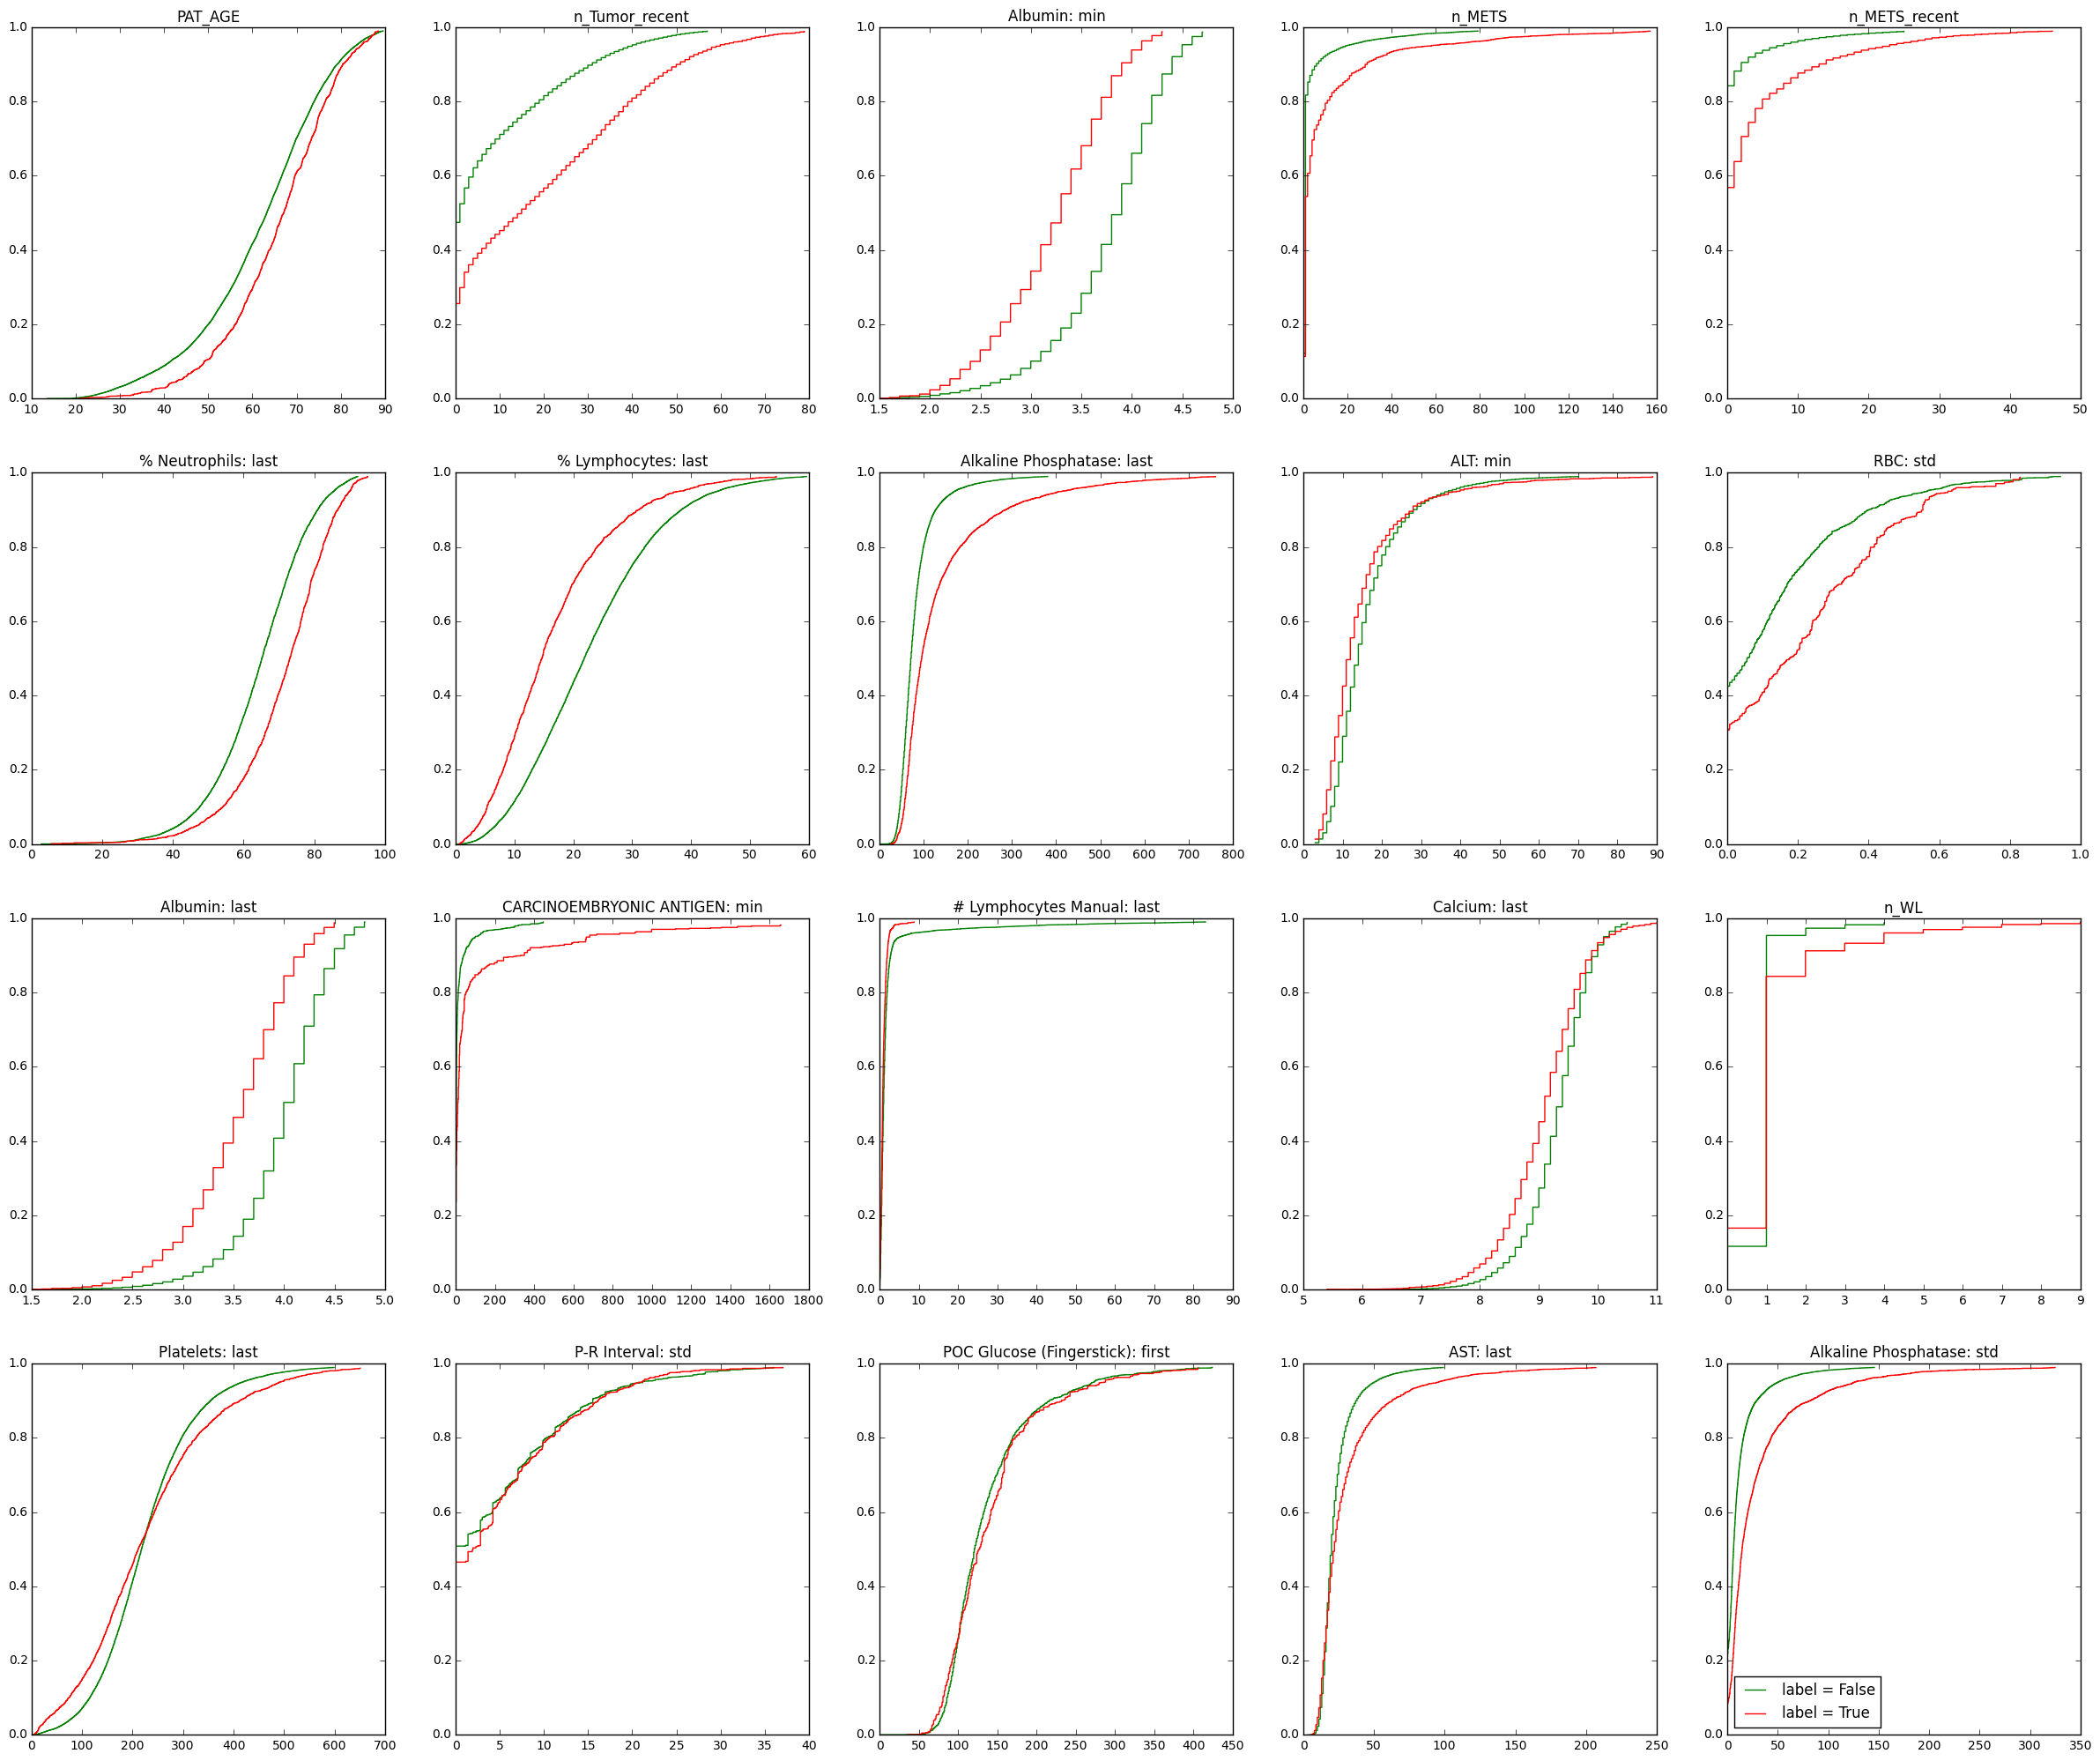

In [14]:
def cdf_diff(df, var, grp='label', col=None, rm_outlier=None, hard_lim=None, ax=None, xlim=None):
    '''Plot cummulative distributions of multiple groups for comparison.
    Arguments:
        df: DataFrame
        var: string, name of column to be plotted
        grp: string, grouping variable
        col: list, colors to use for each group
        rm_outlier: None|float, remove datapoints beyond this many sigma.
        ax: axis on which to plot. Default none will return a new figure

    Examples:
        cdf_diff(feats_labeled,var='Creatinine' ,rm_outlier=4.0)
        fig, ax = plt.subplots(1, 2)
        psLearn.cdf_diff(feats_labeled,var='Creatinine' ,ax=ax[0],rm_outlier=4.0)
        psLearn.cdf_diff(feats_labeled,var='Sodium Level',ax=ax[1])
    '''
    if col is None:
        col = ['green', 'red']
    import statsmodels.api as sm
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    grps = df[grp].unique()
    if len(df[var].unique()) == 2:
        df.groupby(grp)[var].mean().plot(ax = ax,kind='bar',color=col)
        ax.set_title(var)
    else:
        for g in grps:
            sample = df[df[grp]==g][var]
            sample = sample[np.isfinite(sample.values)]
            if rm_outlier is not None:
                sigma = sample.std()
                mu = sample.mean()
                sample = sample[sample > mu - rm_outlier * sigma ]
                sample = sample[sample < mu + rm_outlier * sigma ]
            if hard_lim is not None:
                sample = sample[sample > hard_lim[0] ]
                sample = sample[sample < hard_lim[1] ]
            
            ecdf = sm.distributions.ECDF(sample)
            sample = sample[ecdf(sample) < 0.99]
            
            x = np.linspace(min(sample), max(sample), 1000)
            y = ecdf(x)
            #x = np.append(x, [max(sample)])
            #y = np.append(y, [0])
            ax.step(x, y,label='%s = %s' % (grp,str(g)),c=col[int(g)])
            ax.set_title(var)
            ax.set_ylim([0,1])
            if xlim:
                ax.set_xlim(xlim)

# Top features from model
vars_to_plot = ['PAT_AGE', 'n_Tumor_recent', 'Albumin: min', 'n_METS',
       'n_METS_recent', '% Neutrophils: last', '% Lymphocytes: last',
       'Alkaline Phosphatase: last', 'ALT: min', 'RBC: std',
       'Albumin: last', 'CARCINOEMBRYONIC ANTIGEN: min',
       '# Lymphocytes Manual: last', 'Calcium: last', 'n_WL',
       'Platelets: last', 'P-R Interval: std',
       'POC Glucose (Fingerstick): first', 'AST: last',
       'Alkaline Phosphatase: std']
                
fig, axx = plt.subplots(4,5,figsize=(30,25))
for i,v in enumerate(vars_to_plot):
    ax = axx[i/5, i%5]
    cdf_diff(enc_data, v, ax=ax)
ax.legend(loc=0)
plt.show()

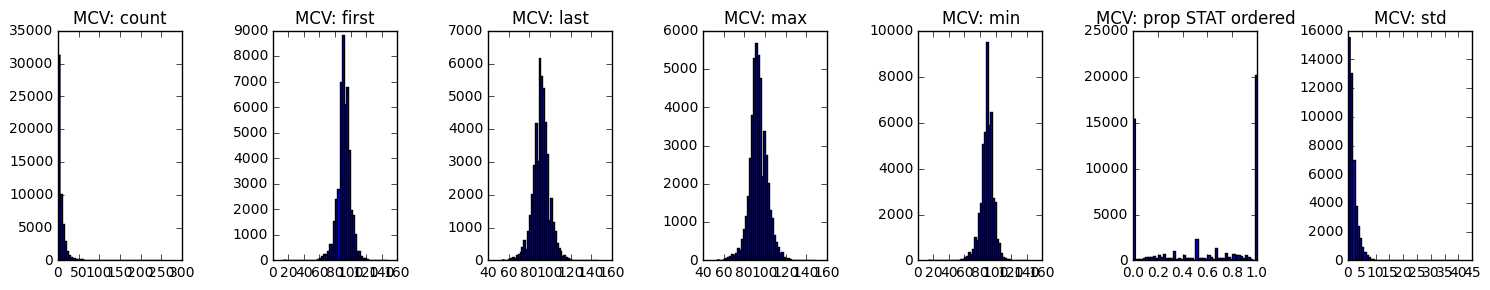

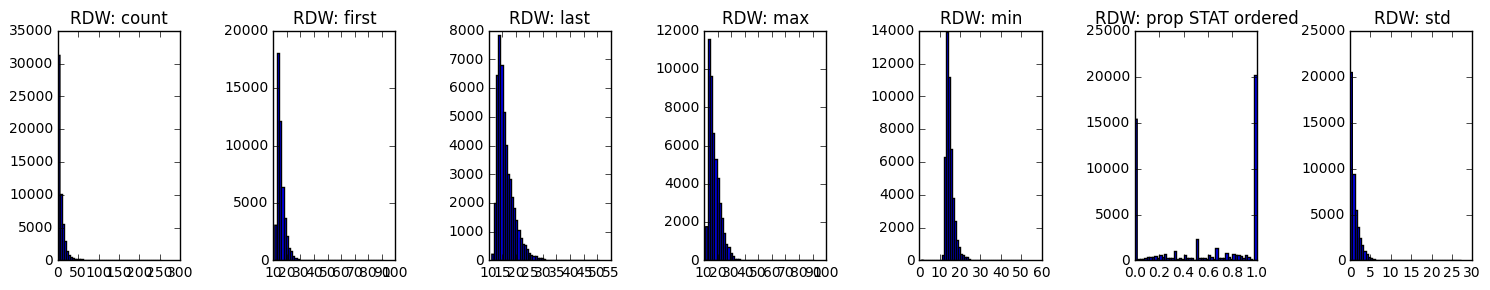

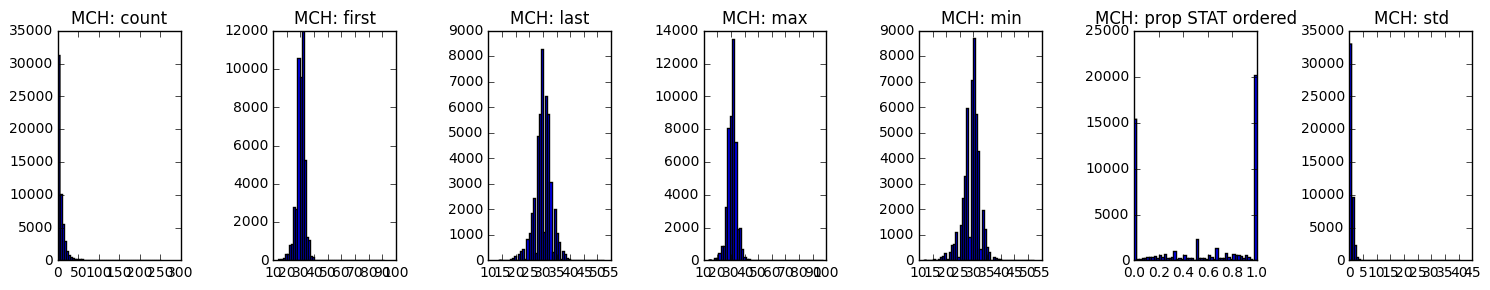

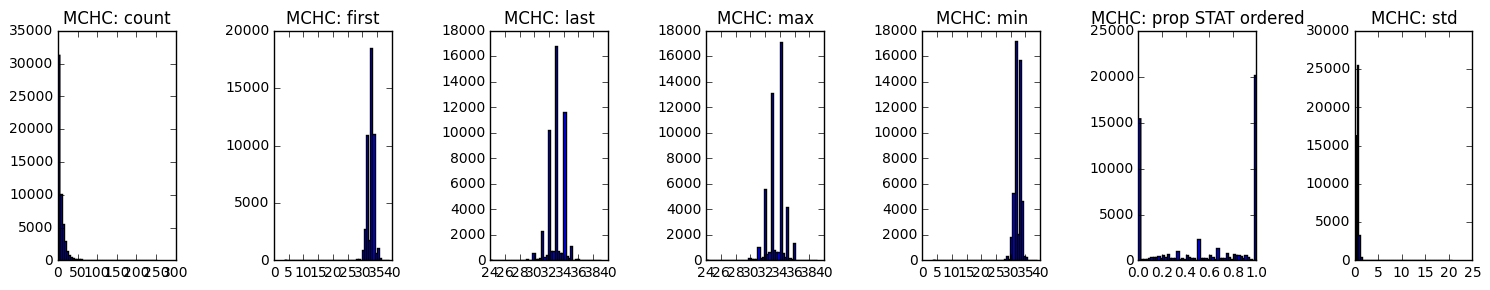

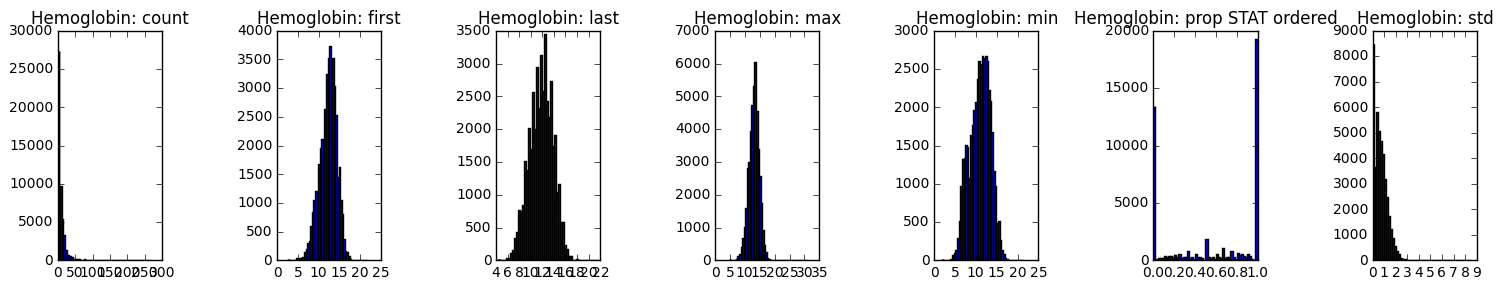

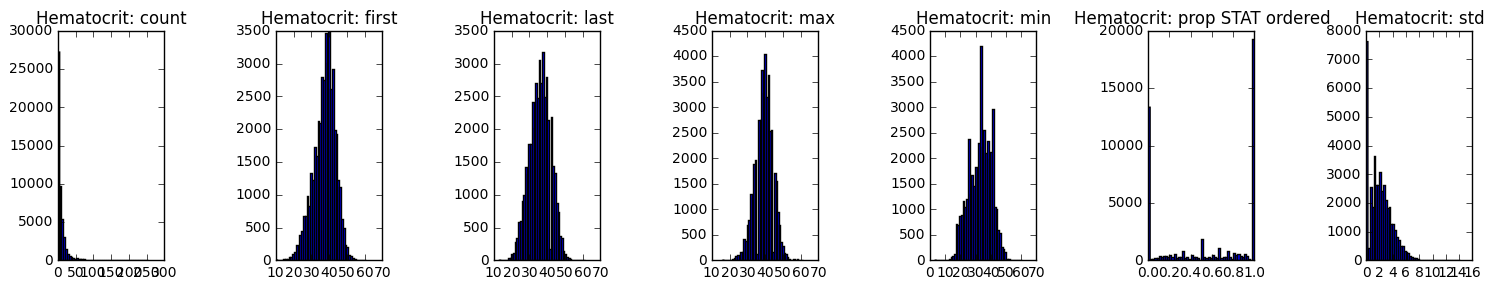

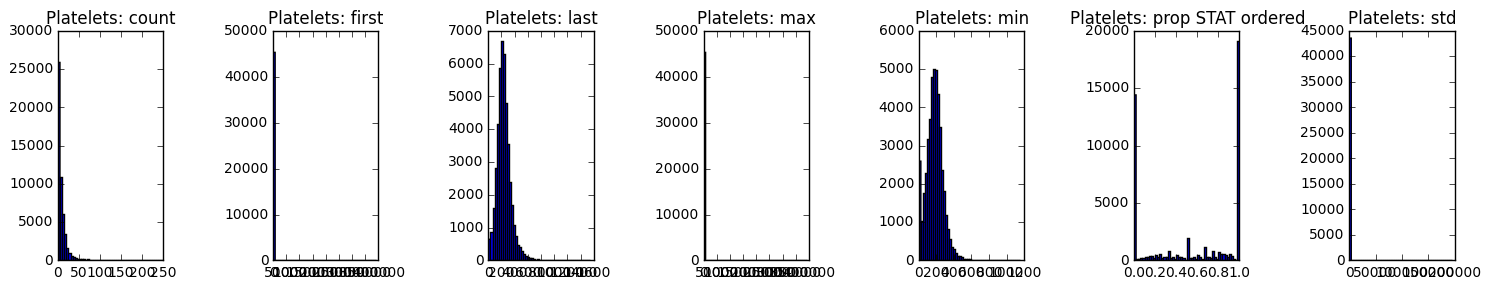

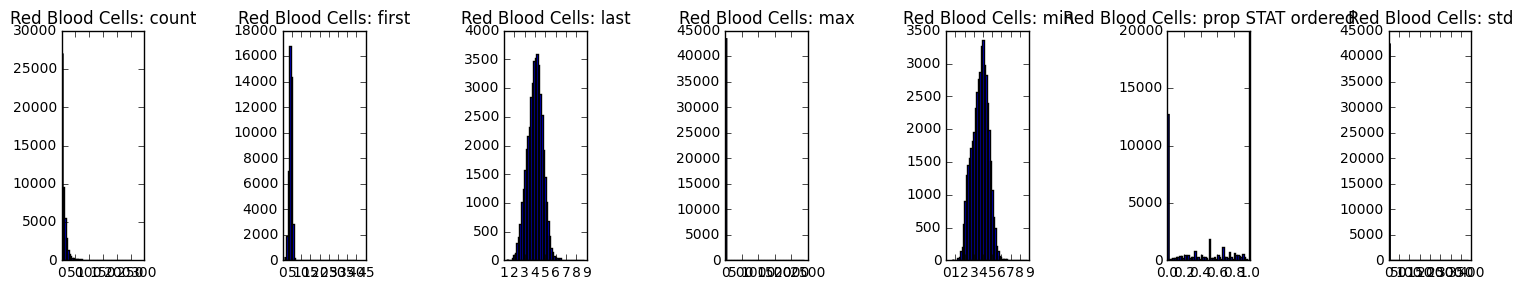

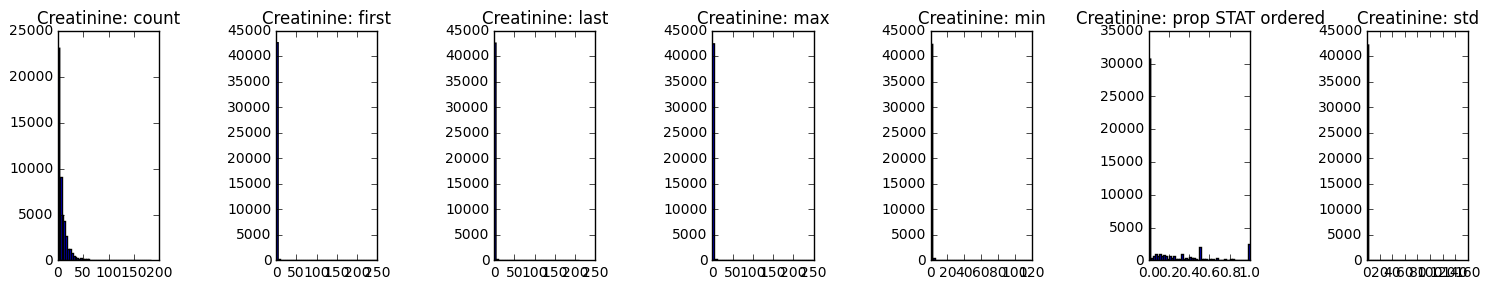

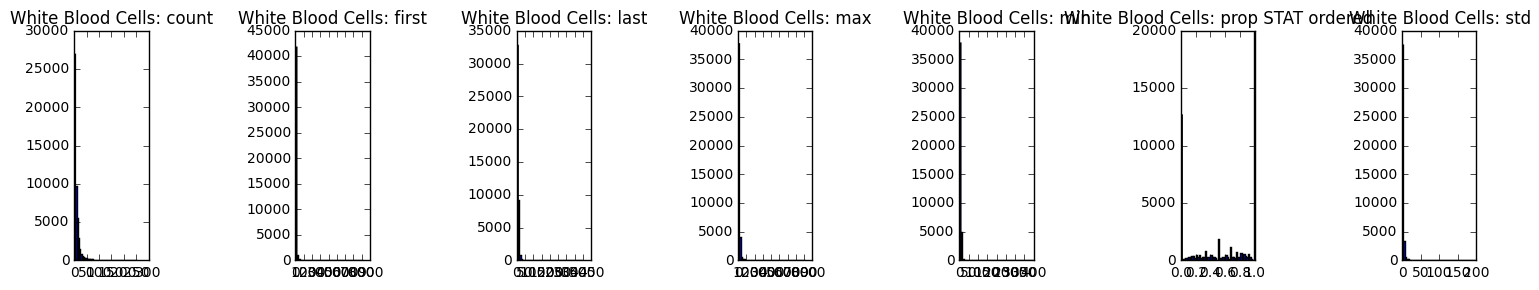

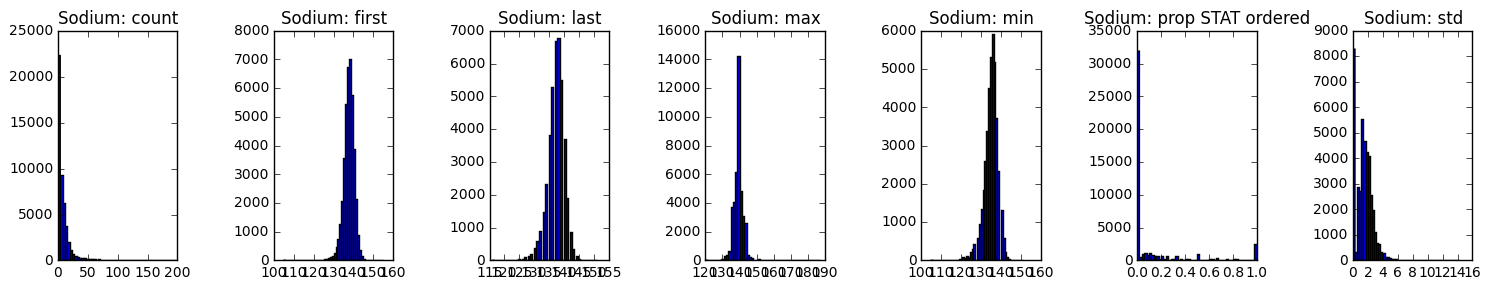

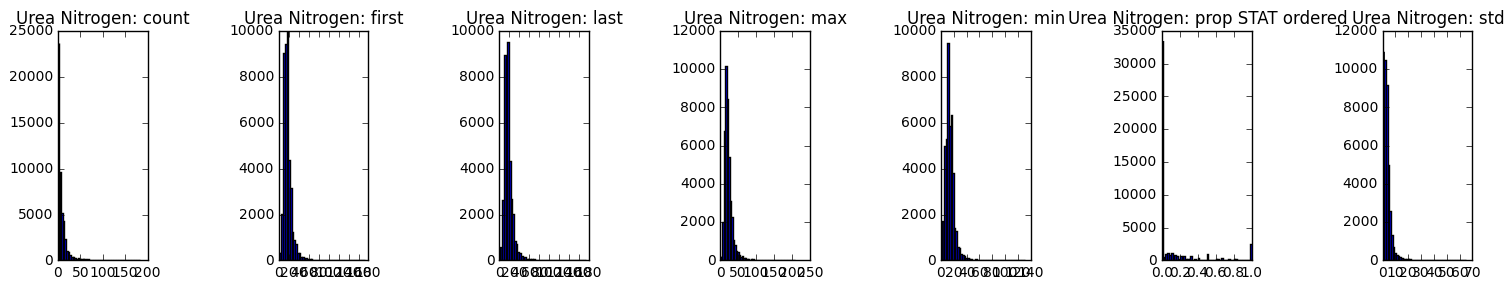

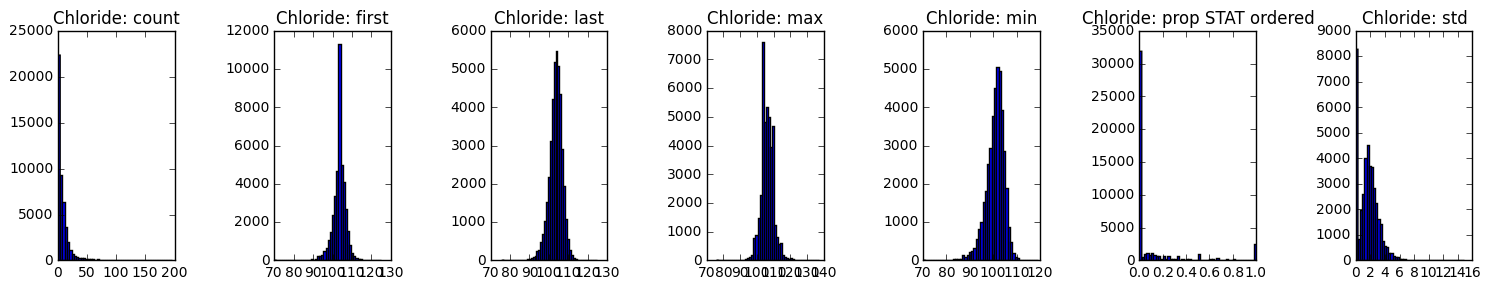

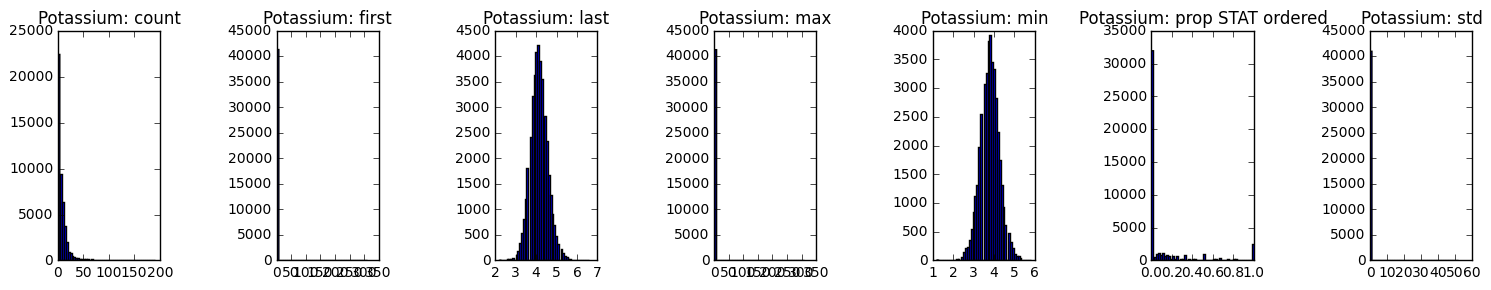

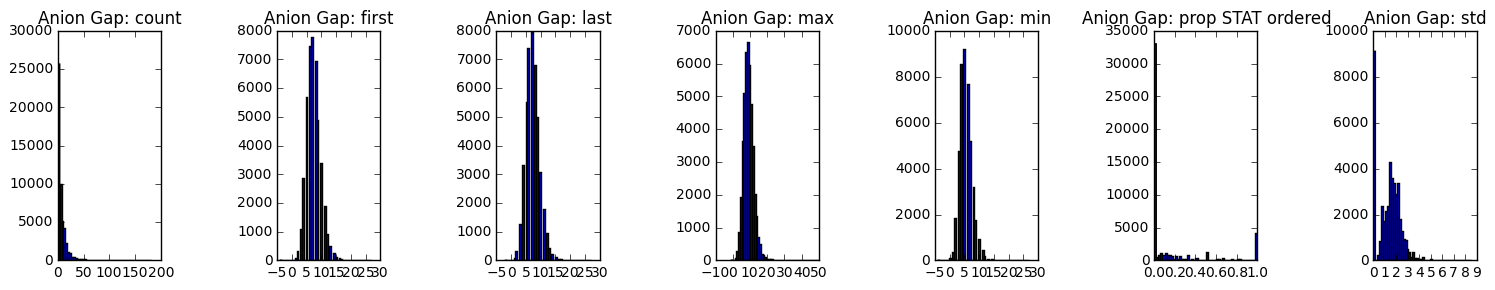

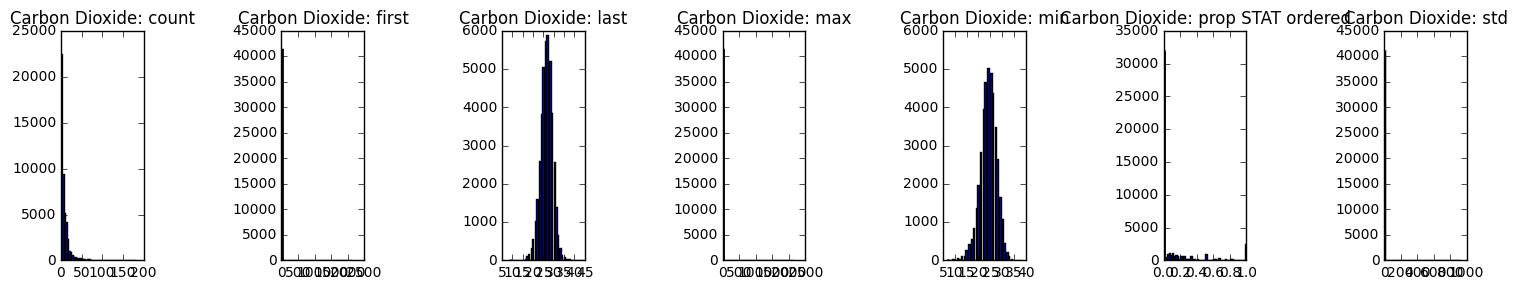

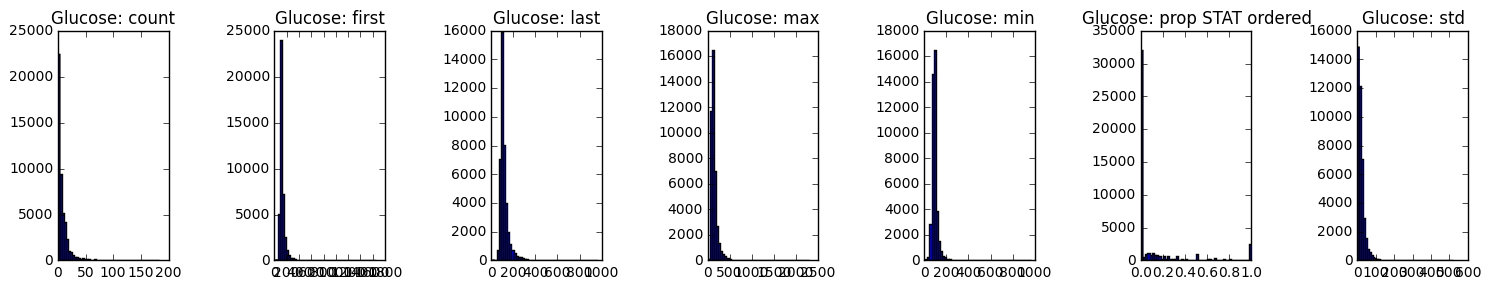

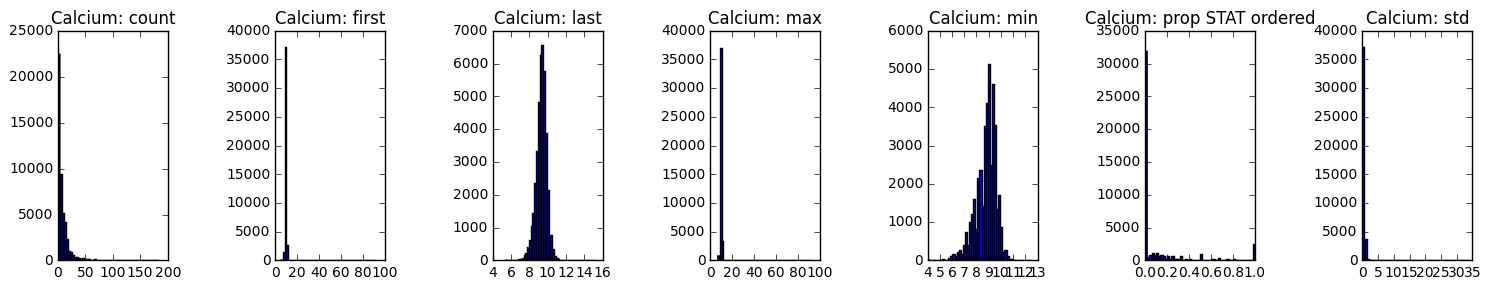

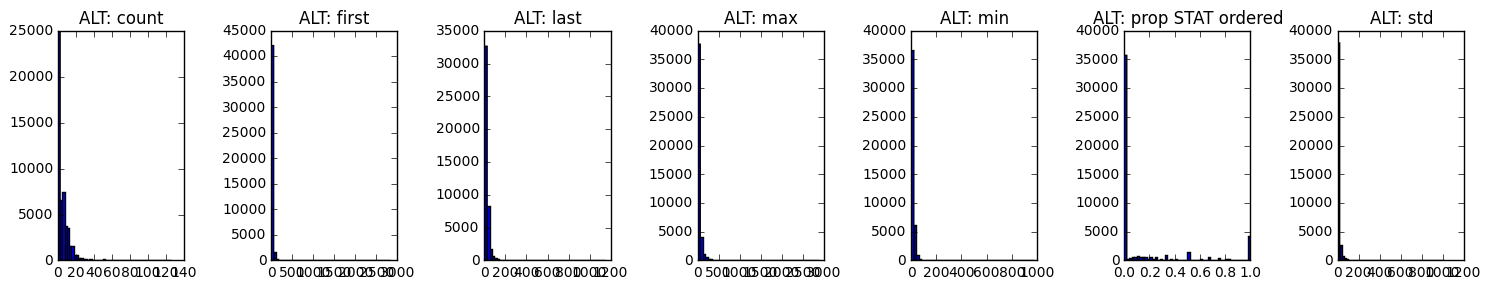

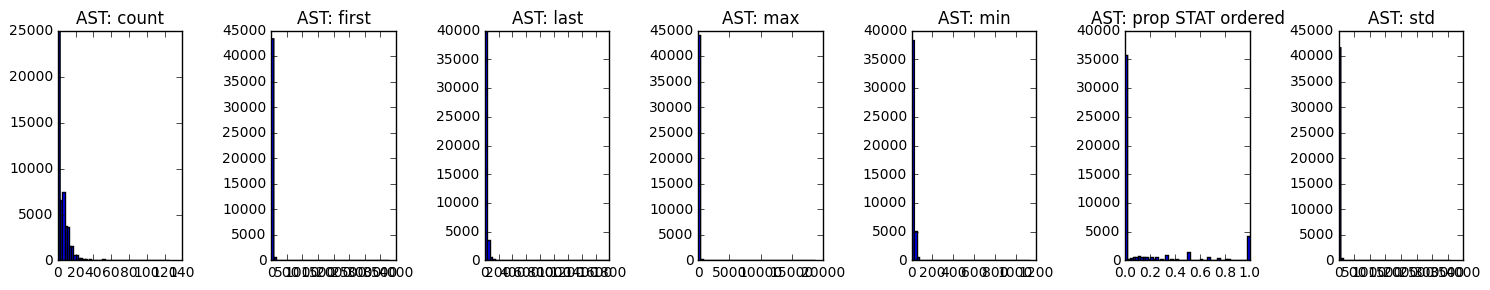

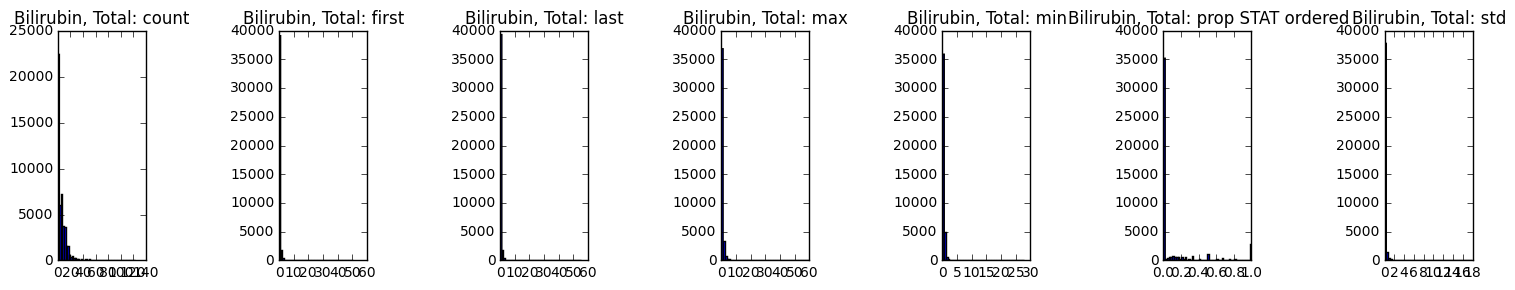

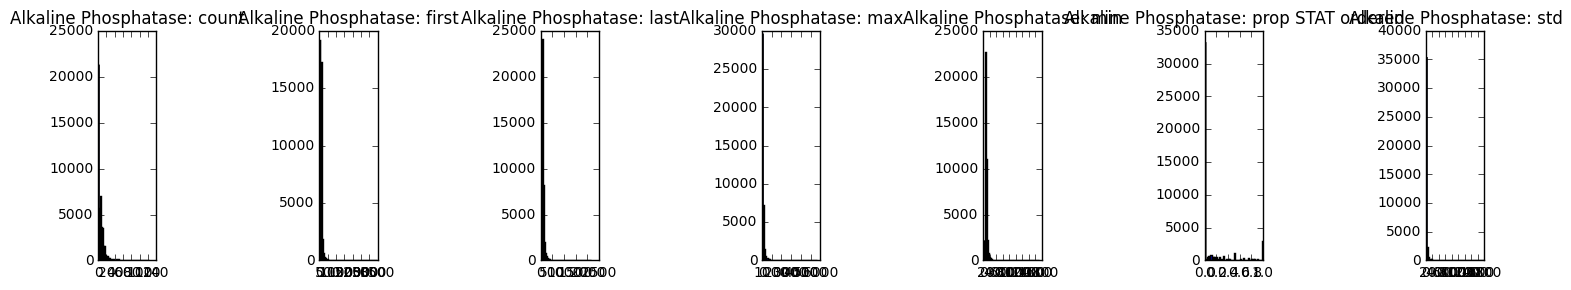

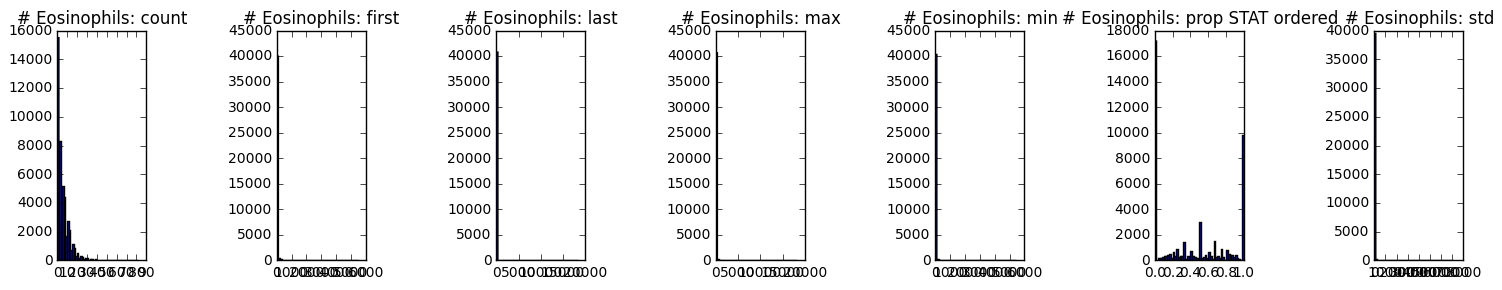

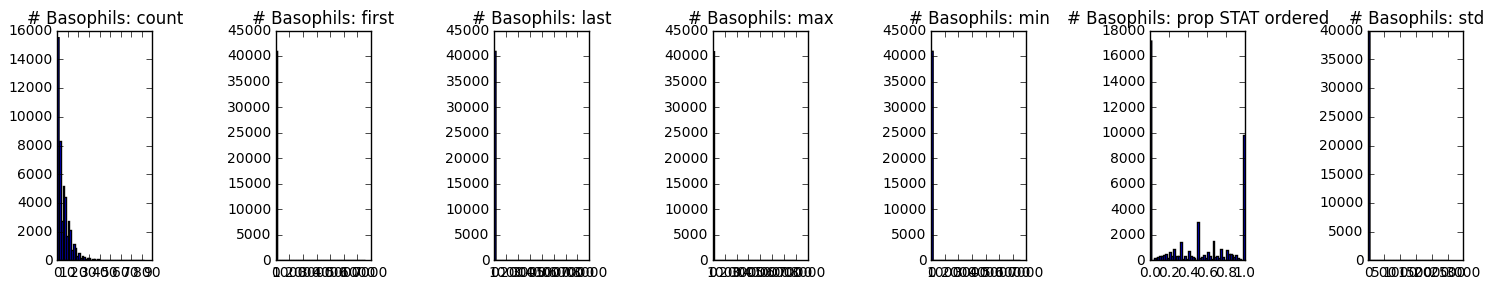

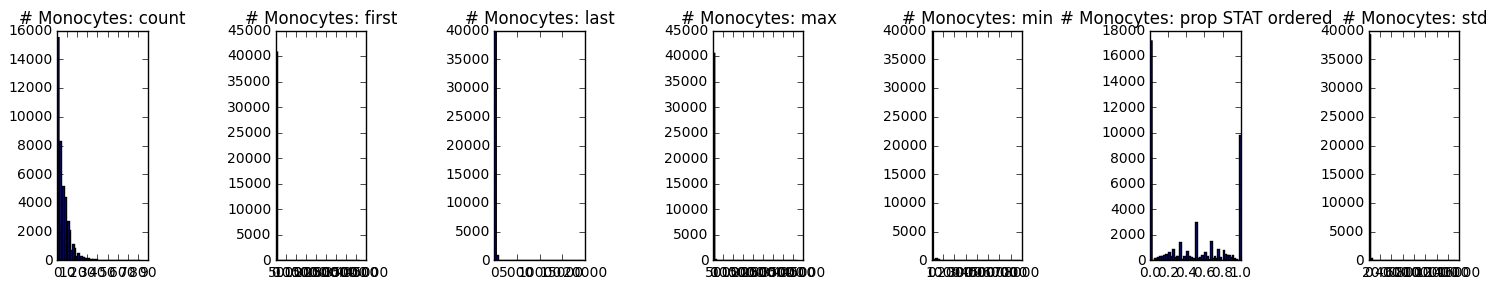

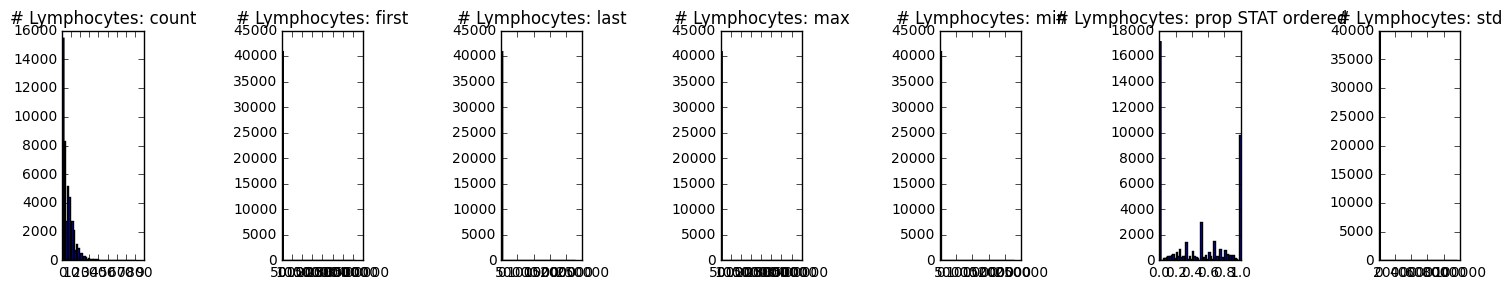

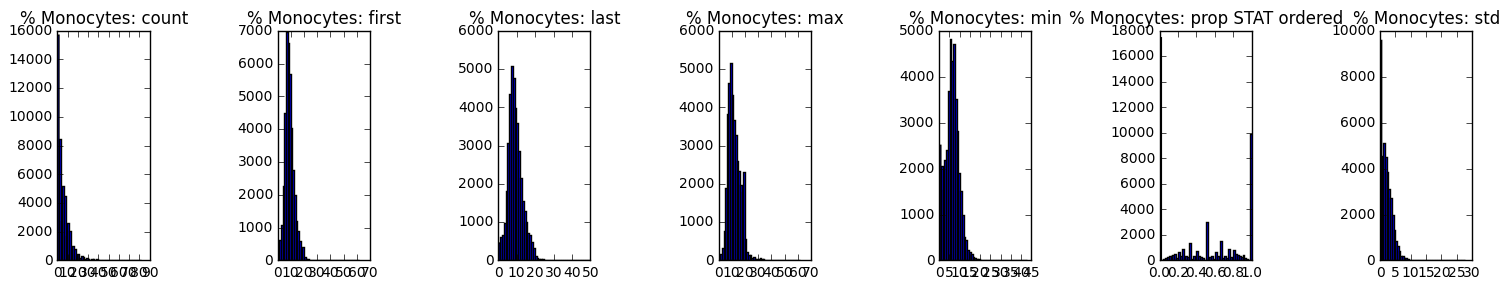

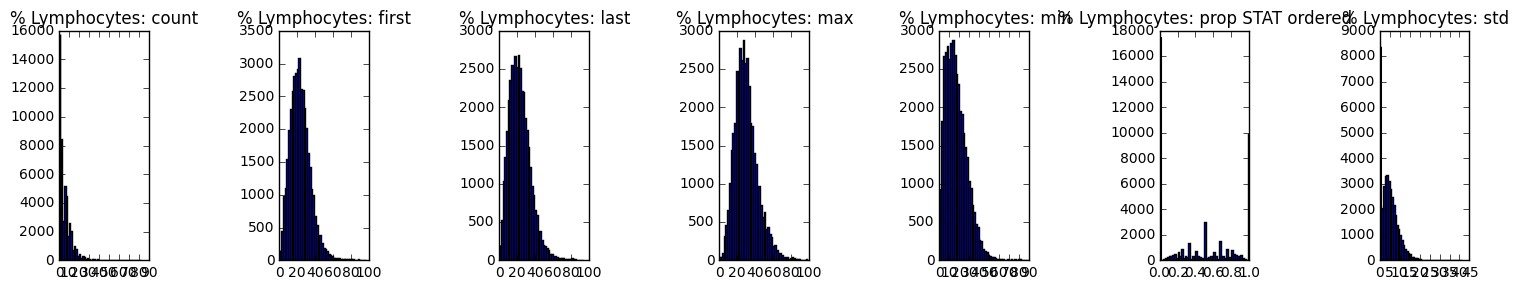

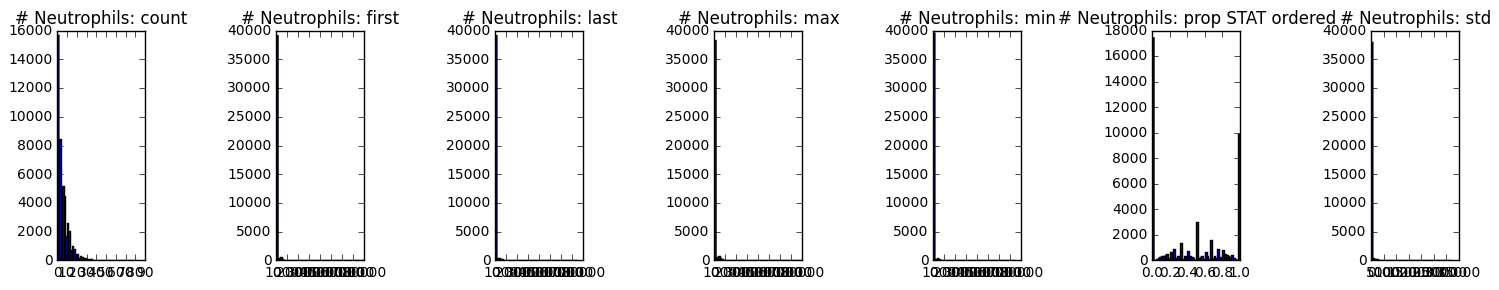

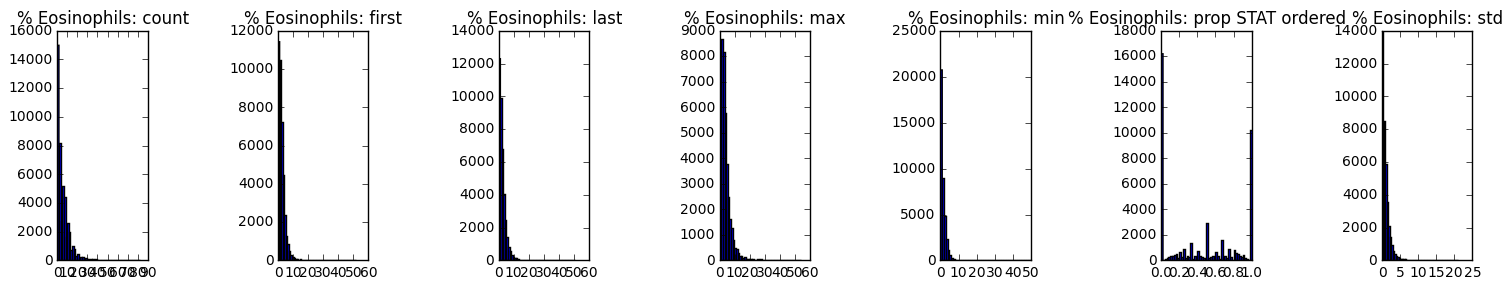

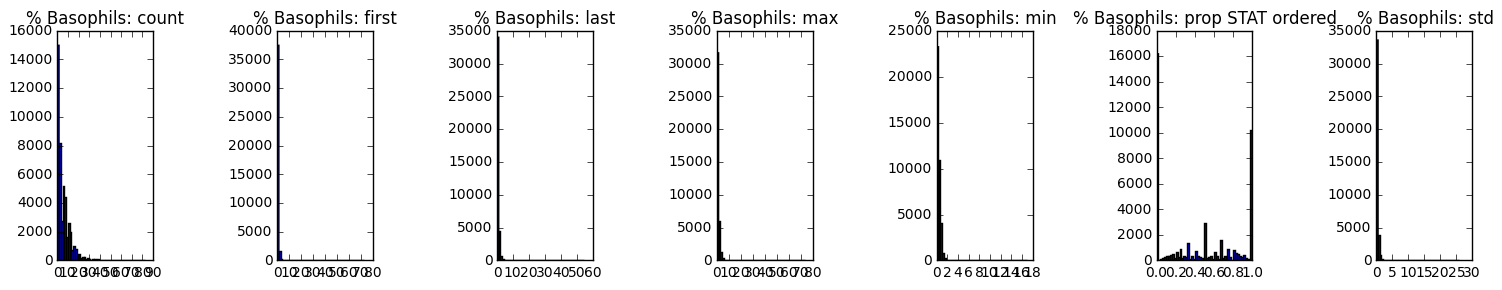

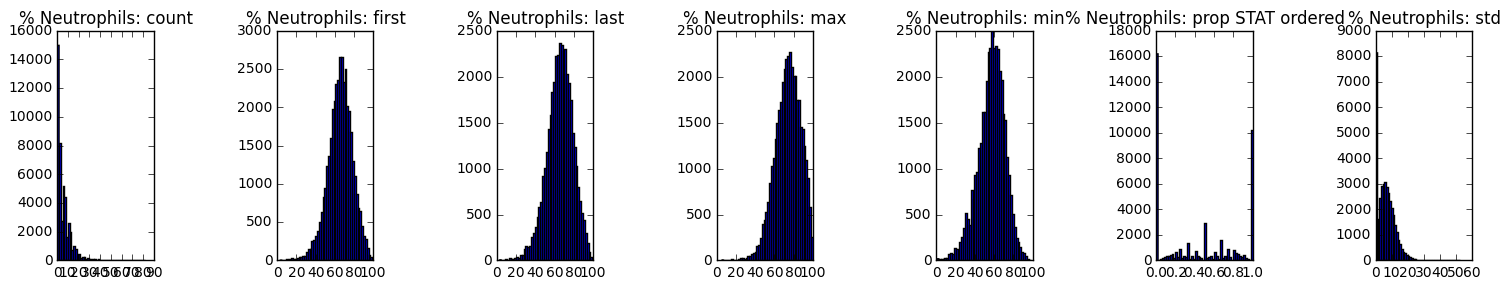

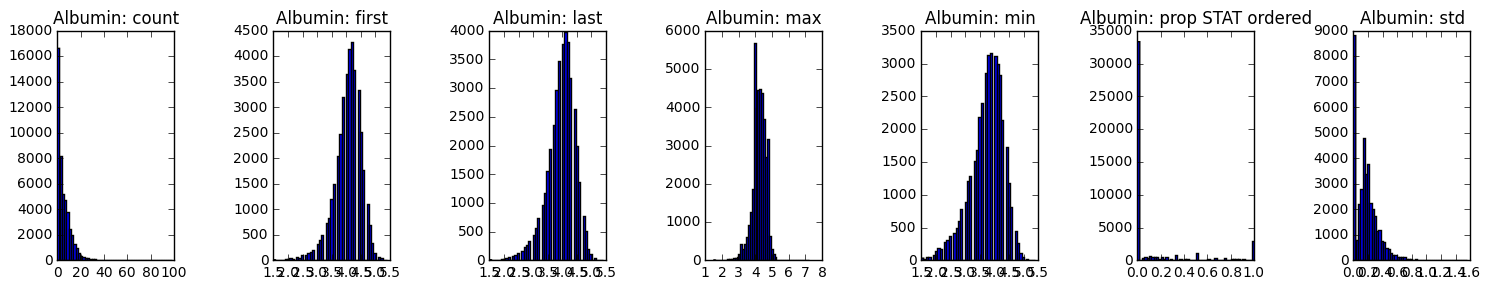

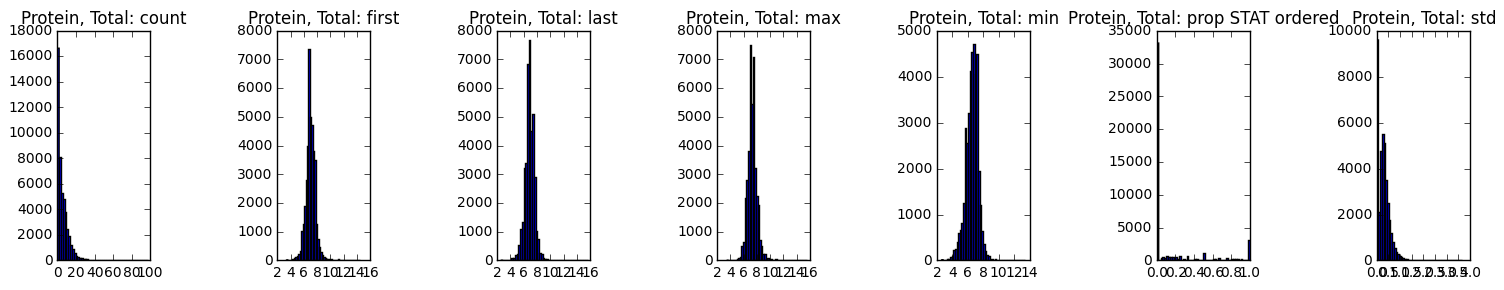

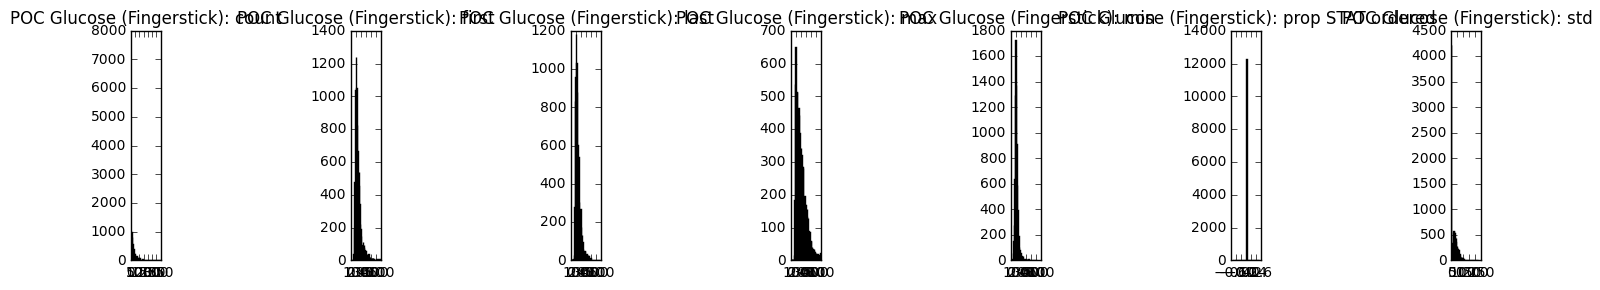

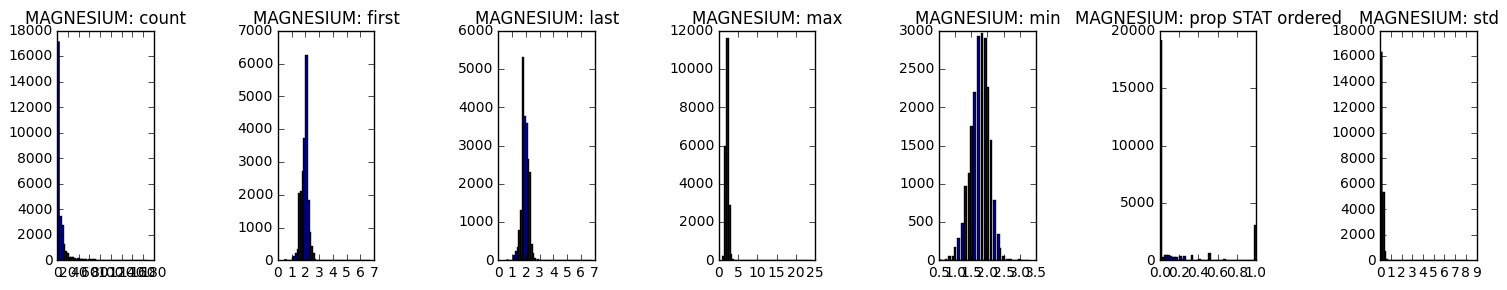

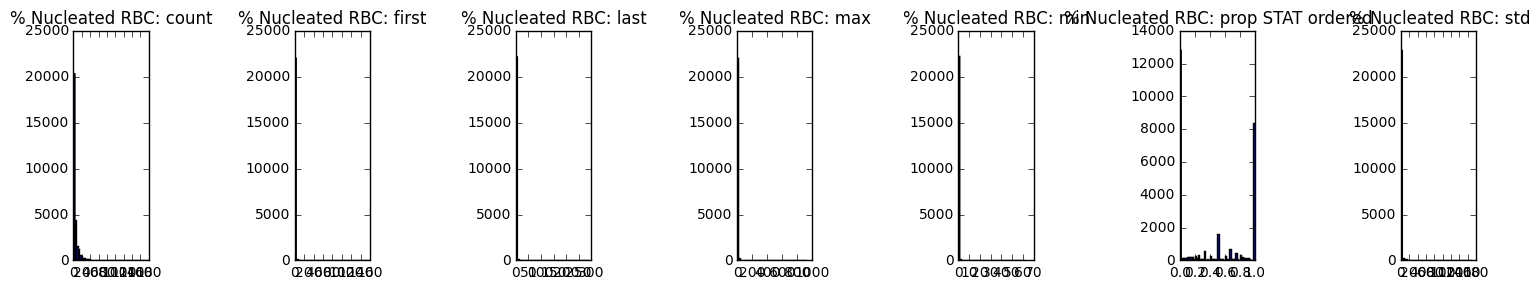

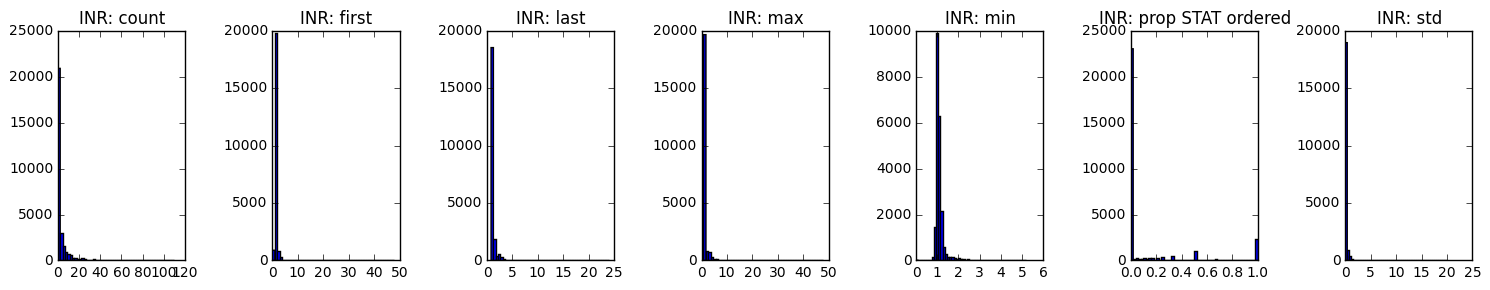

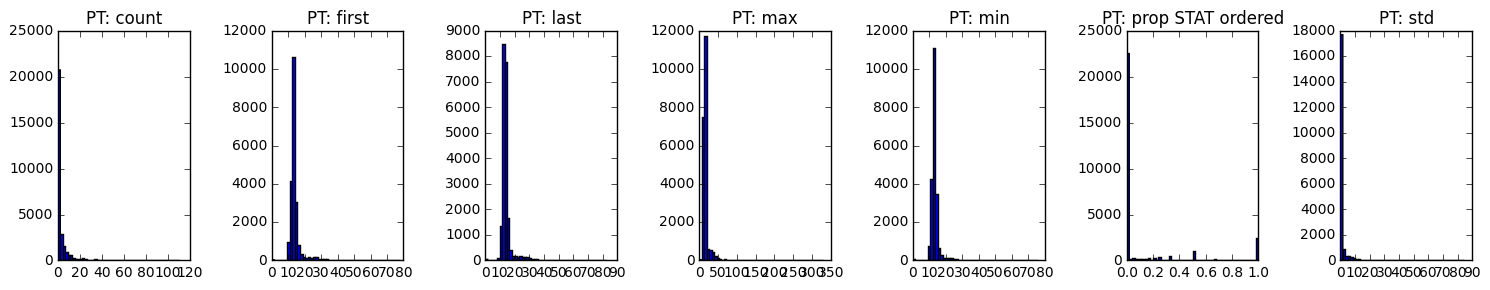

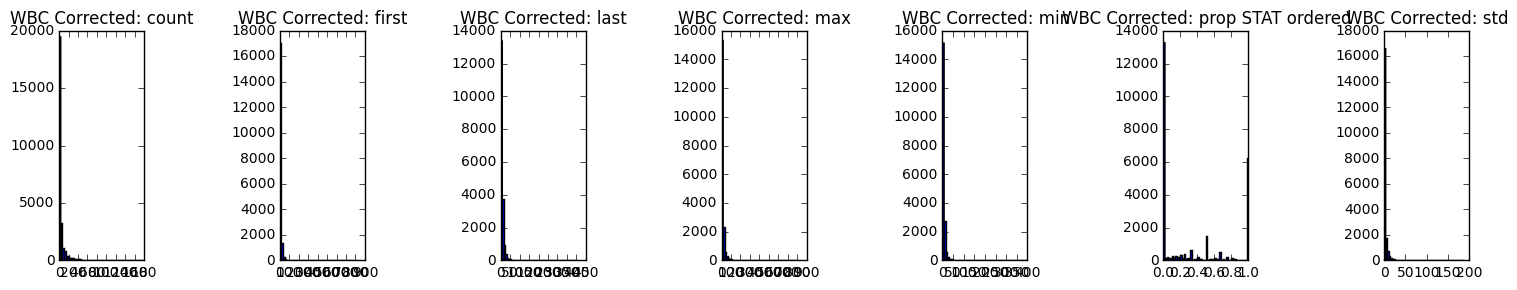

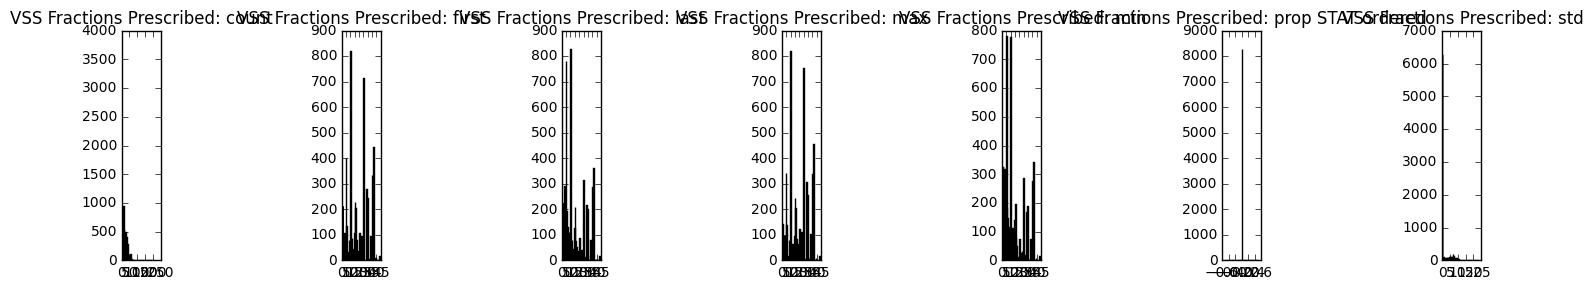

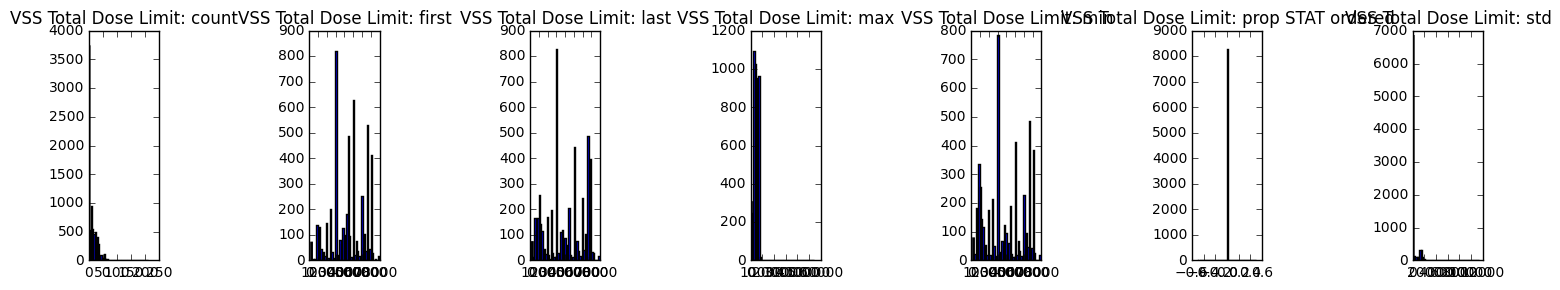

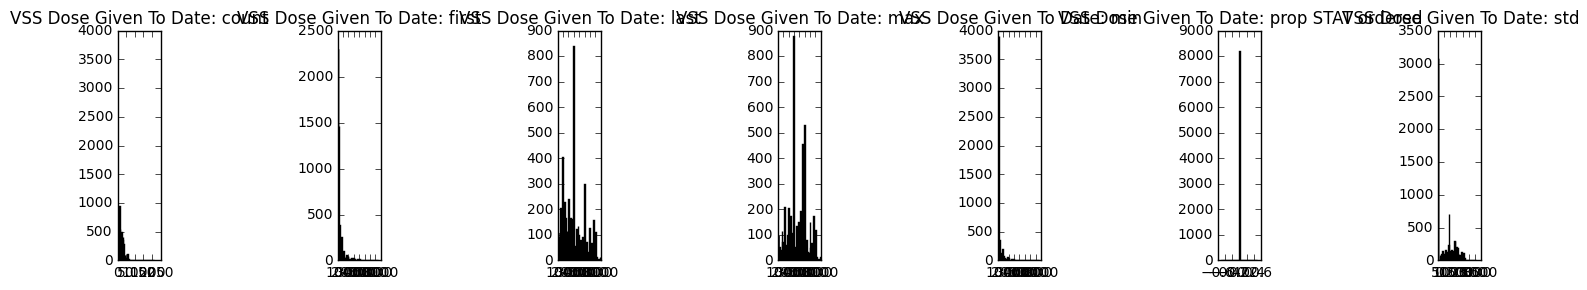

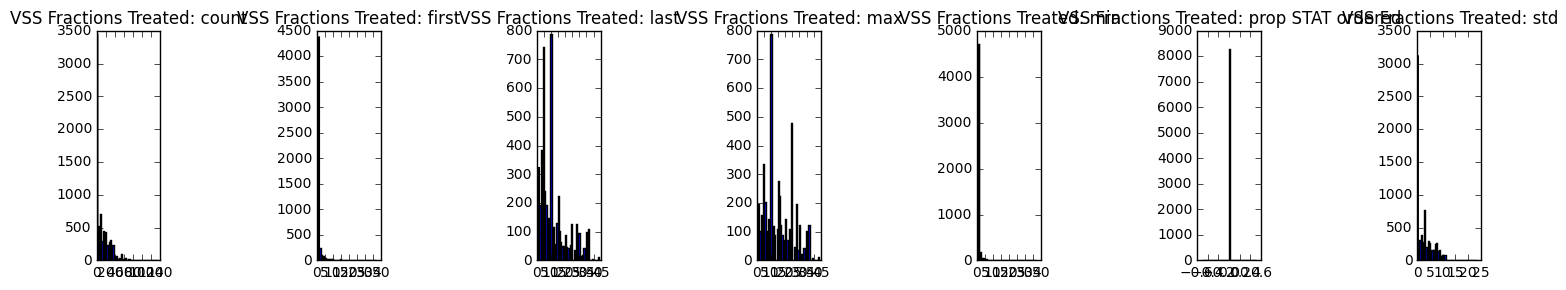

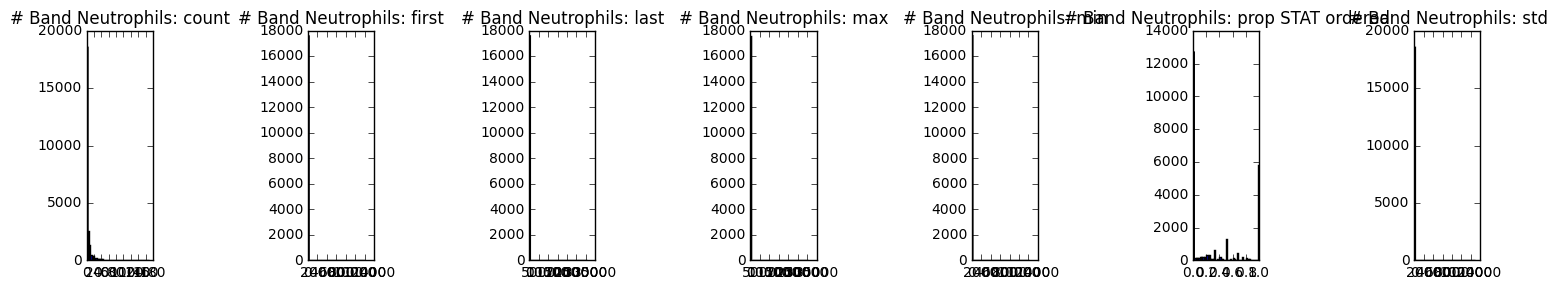

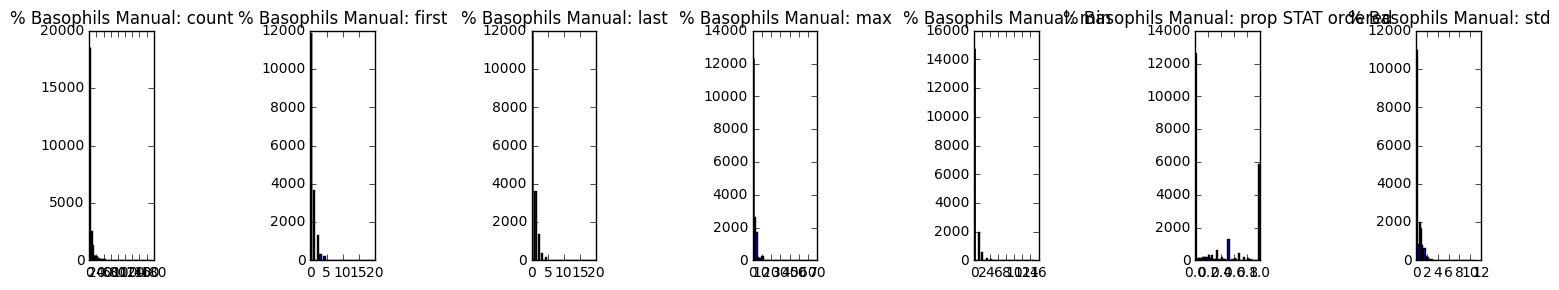

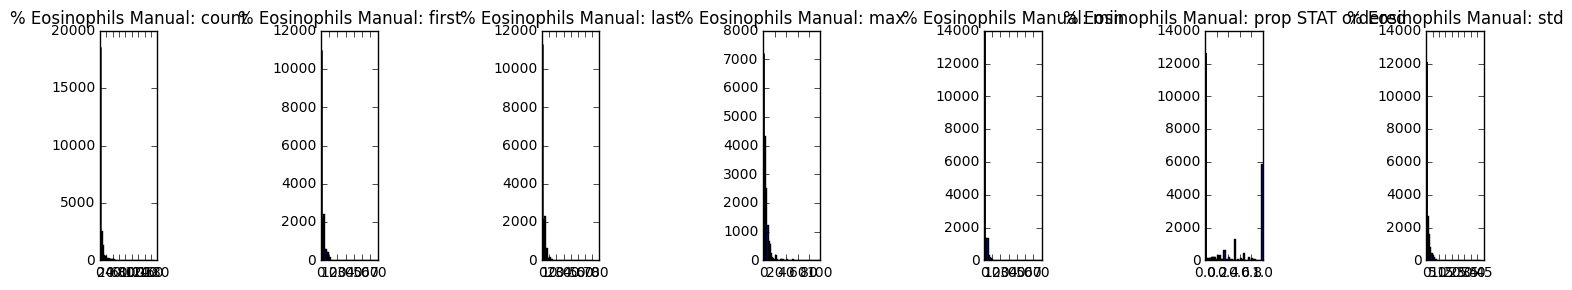

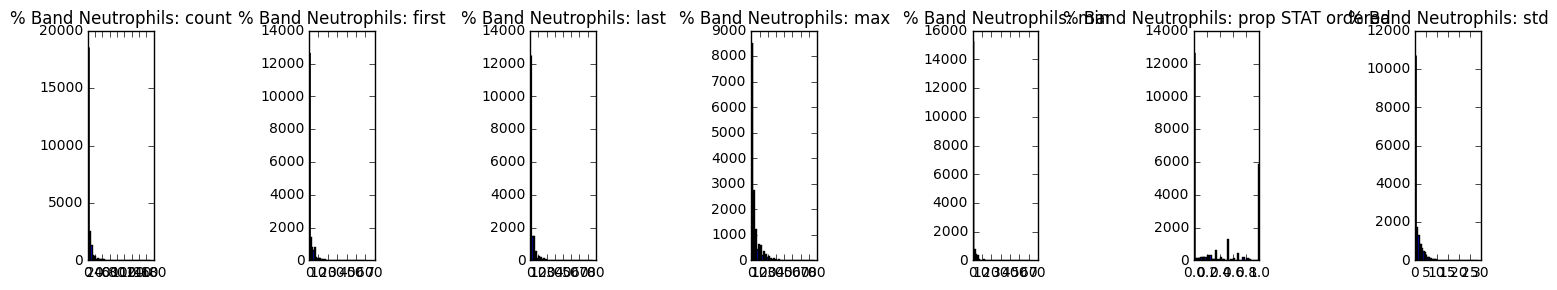

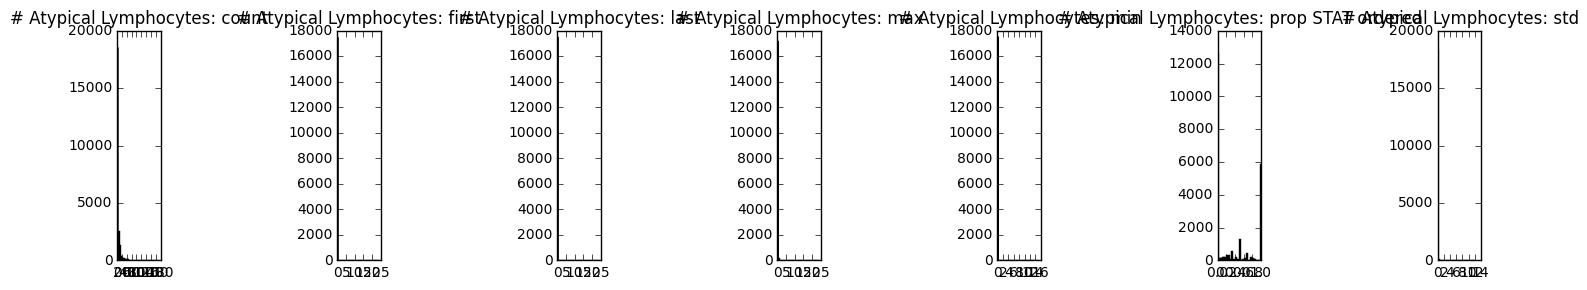

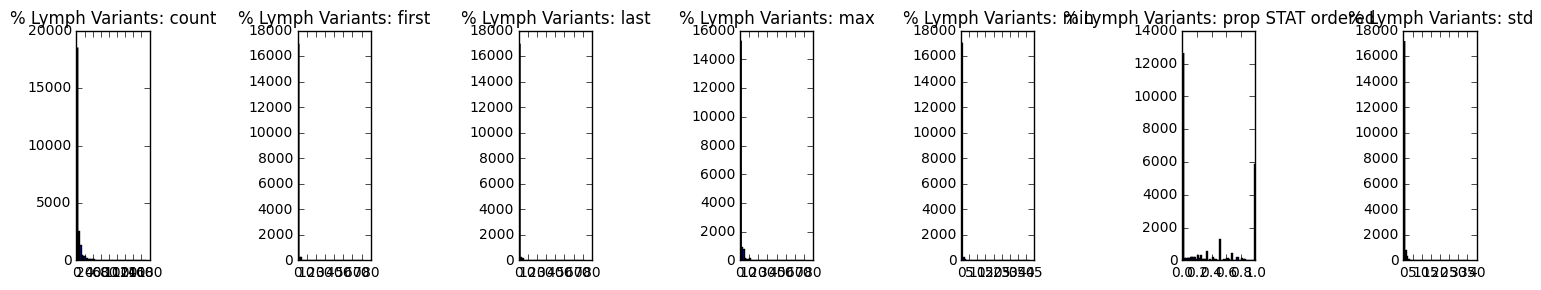

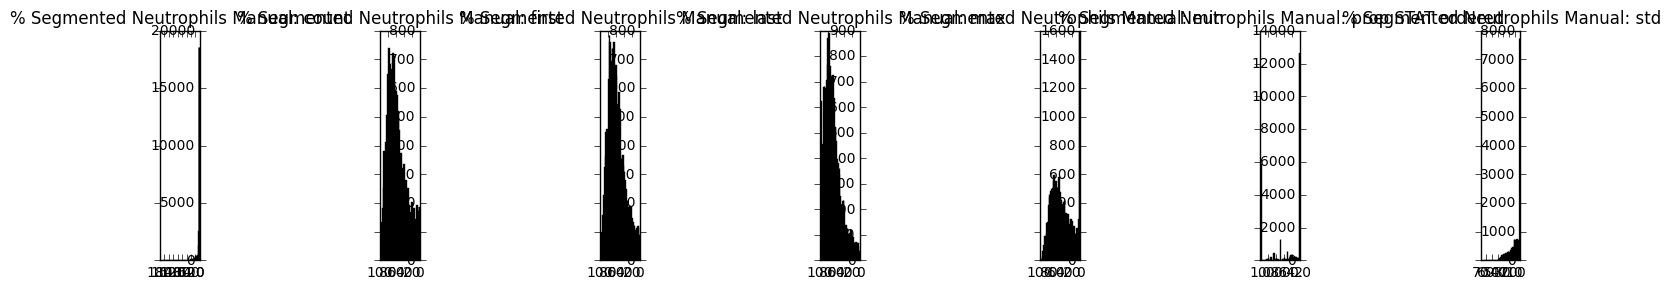

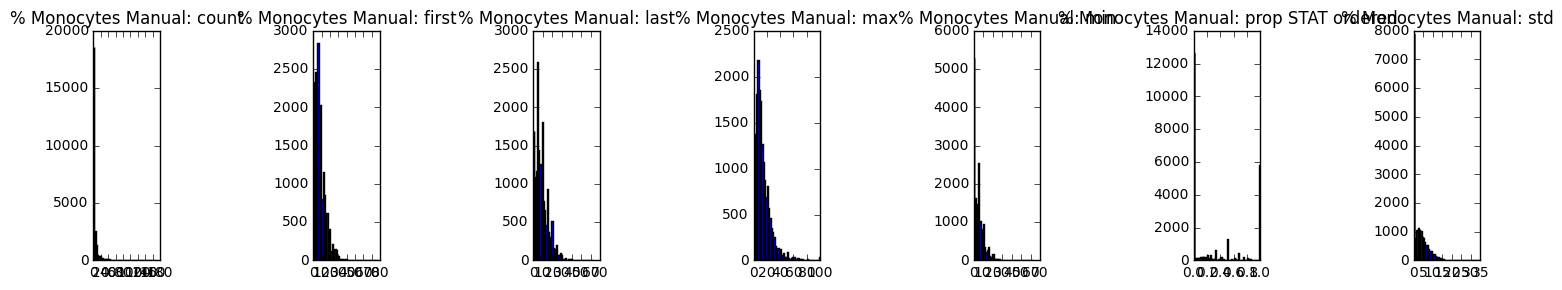

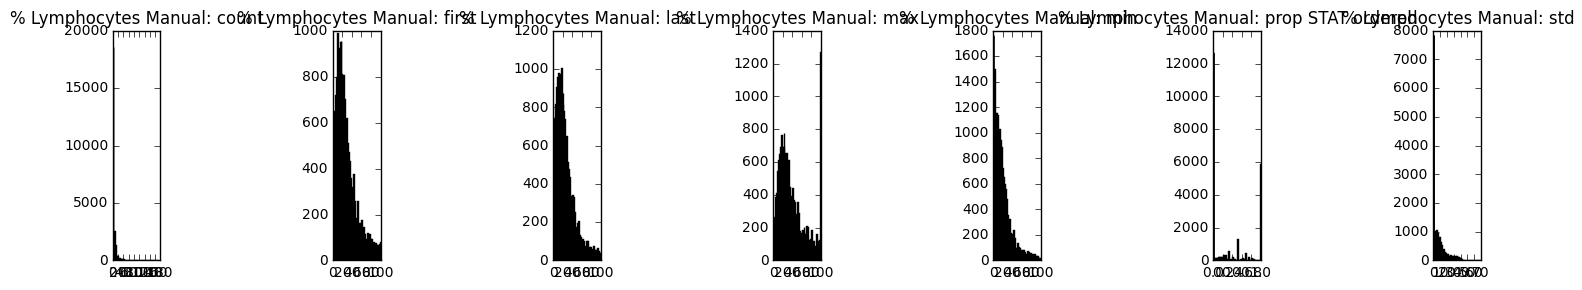

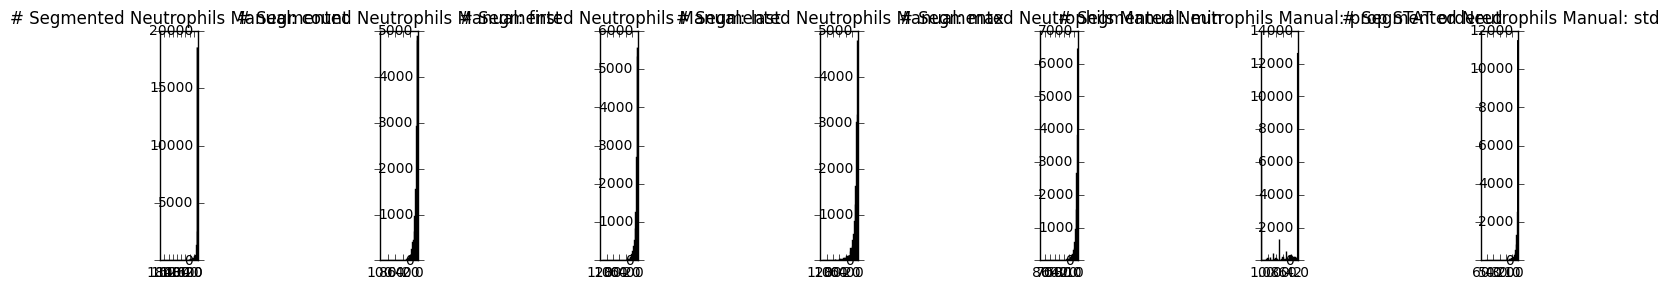

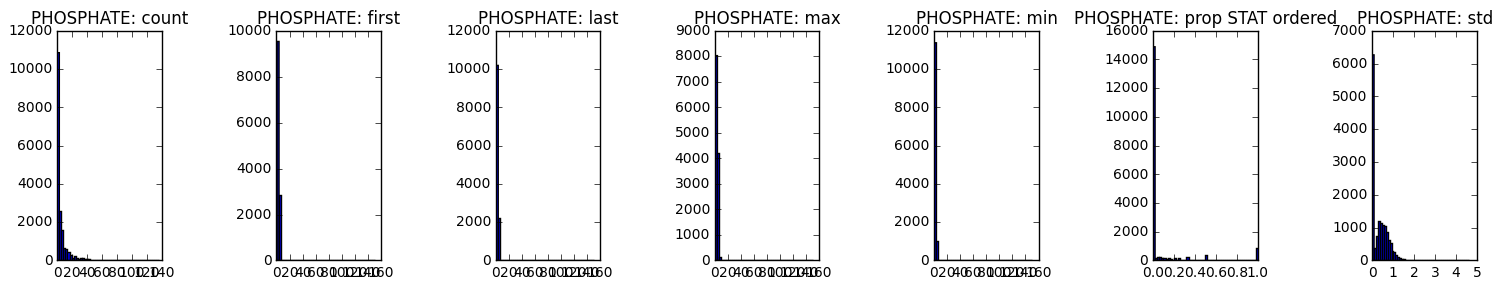

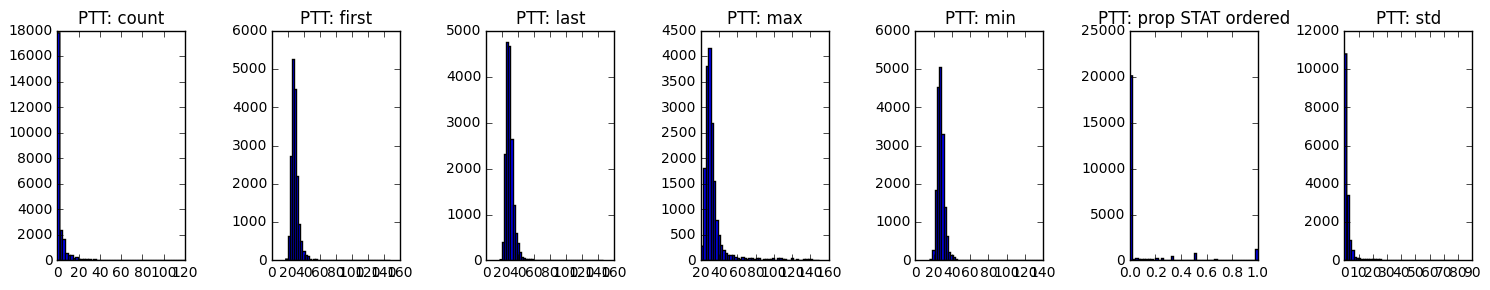

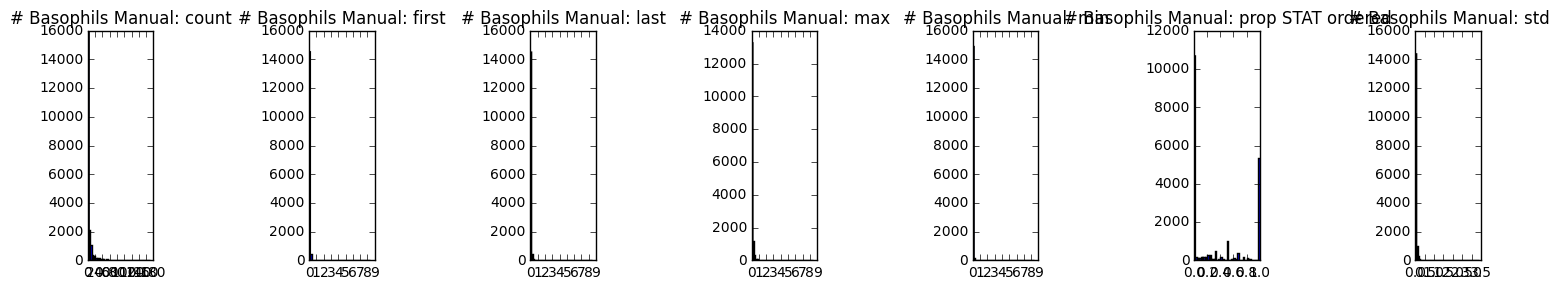

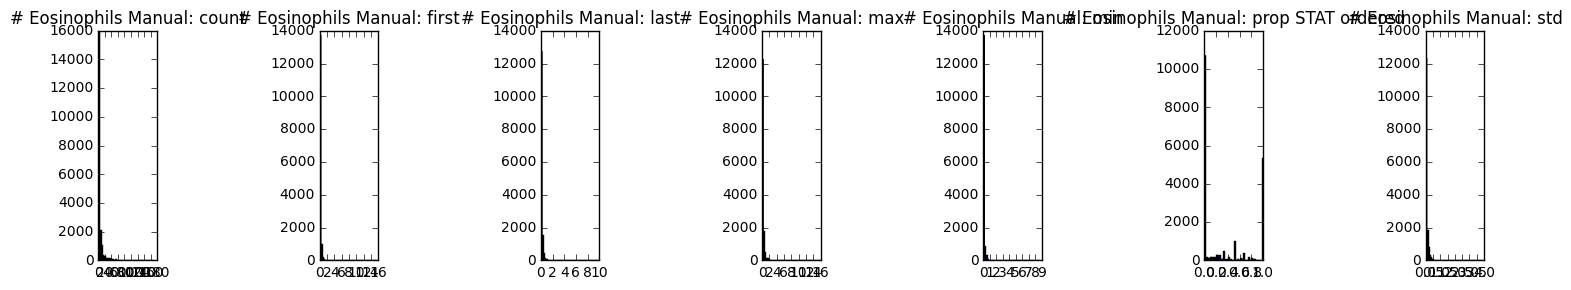

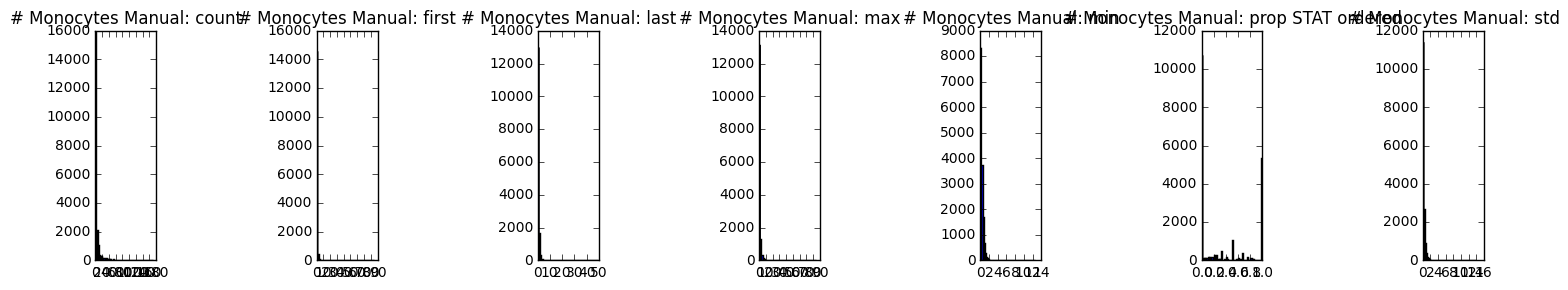

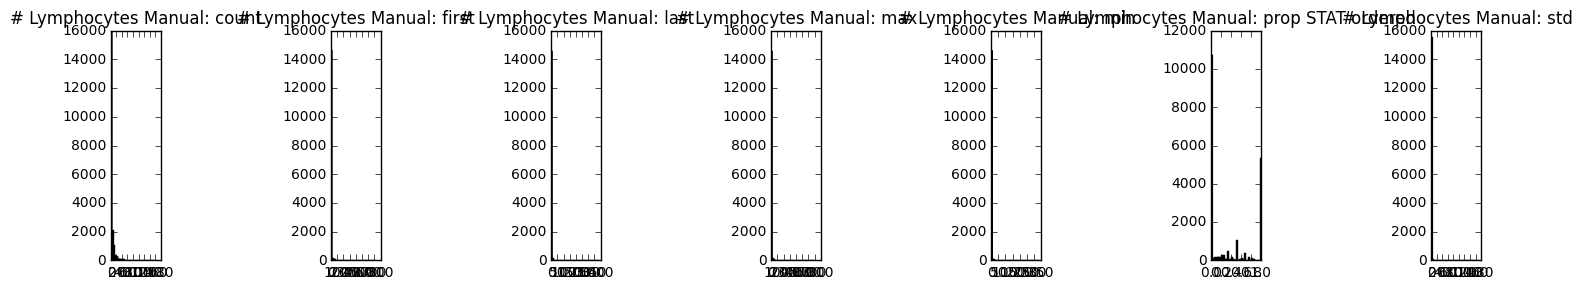

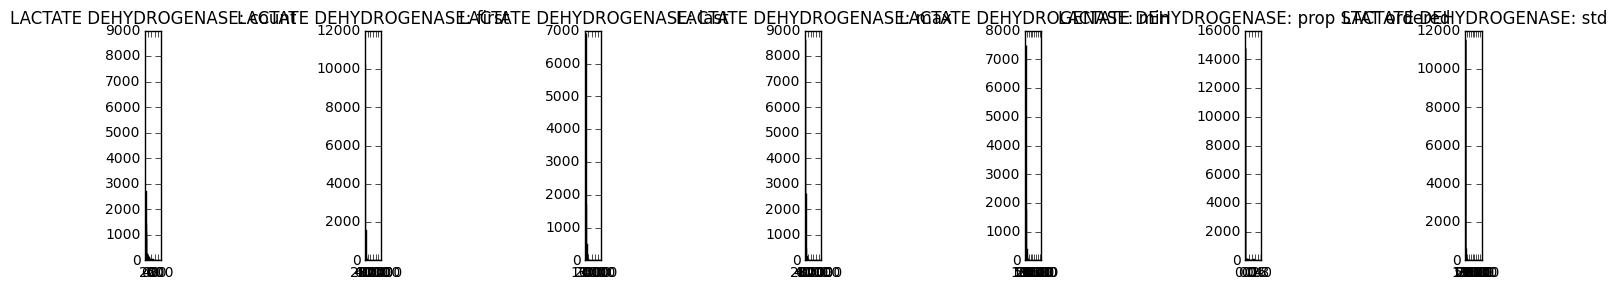

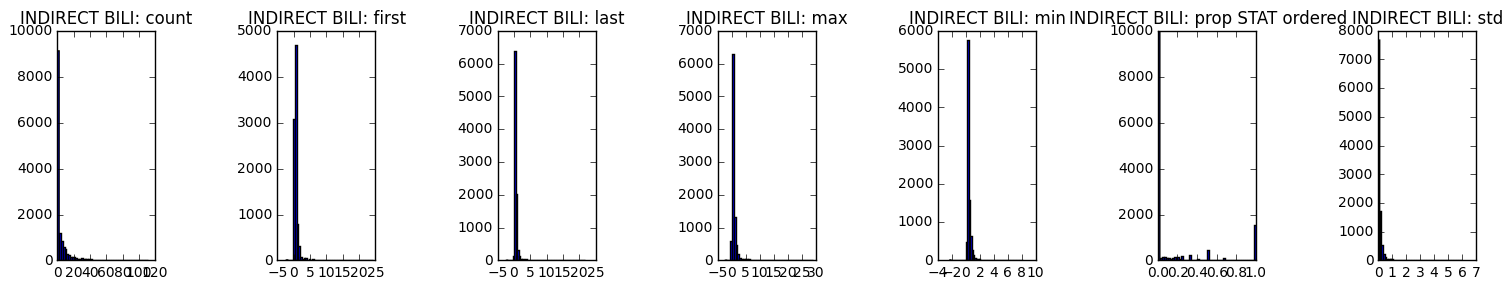

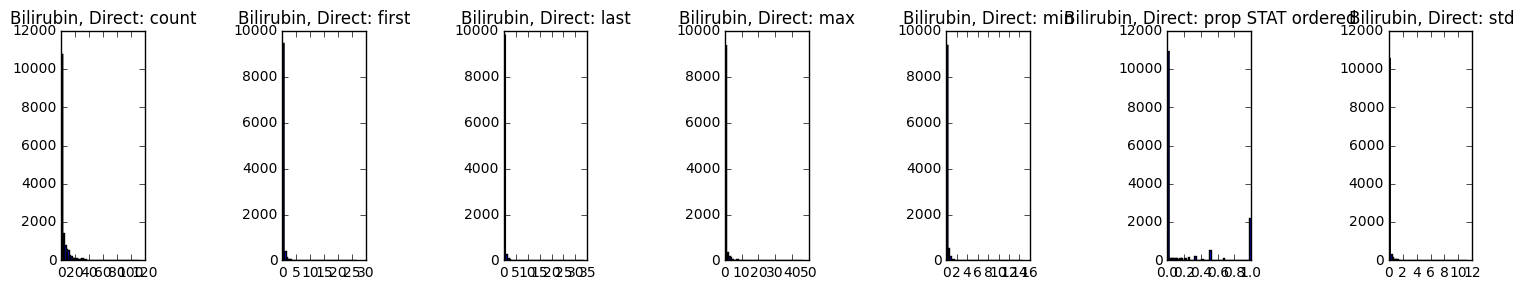

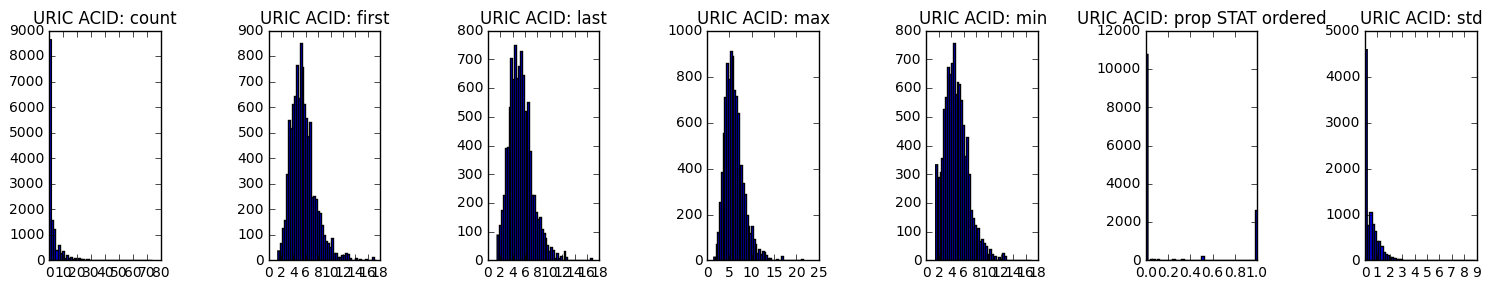

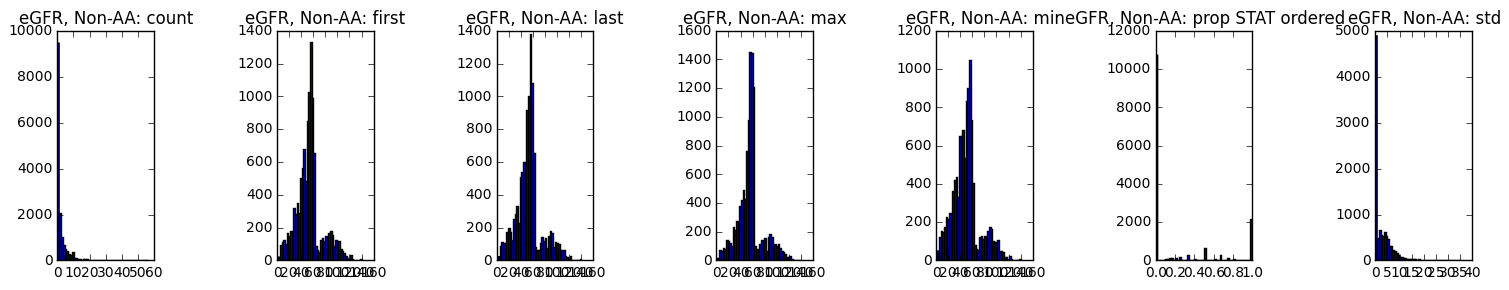

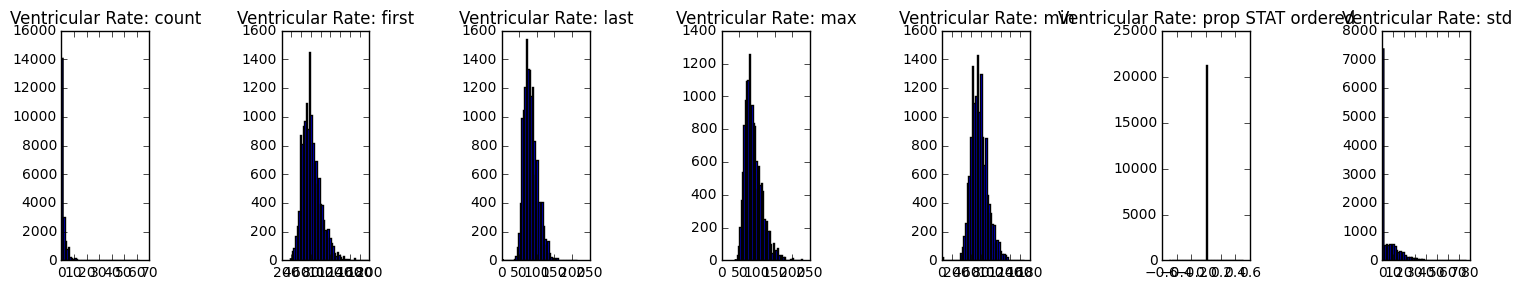

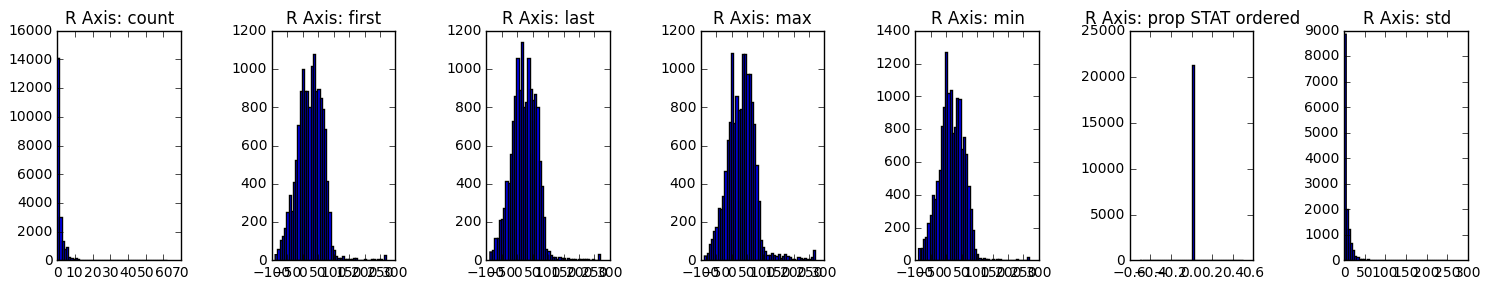

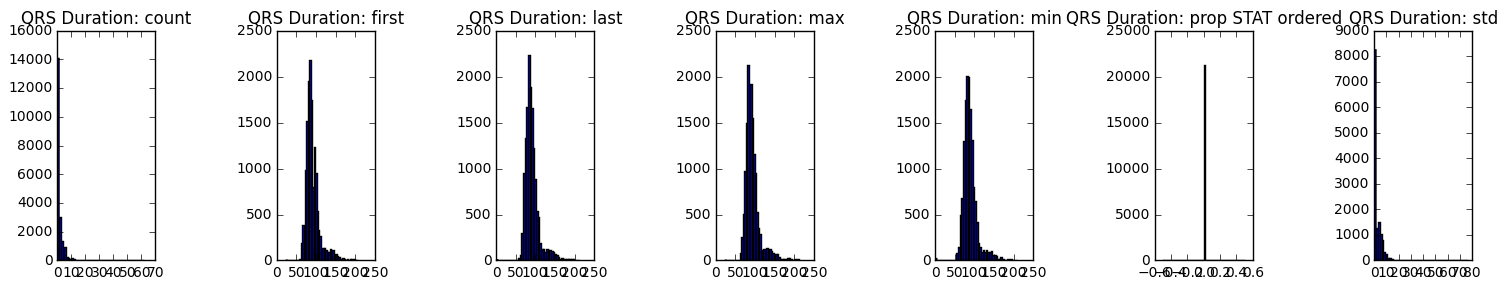

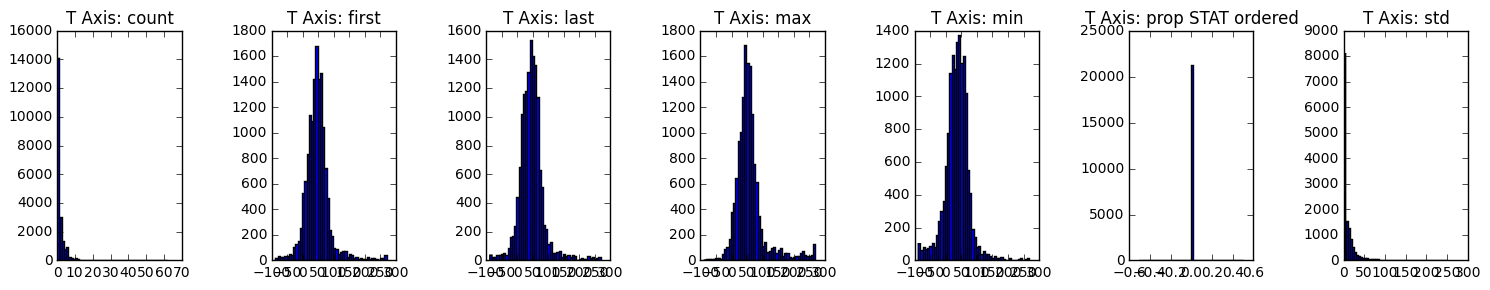

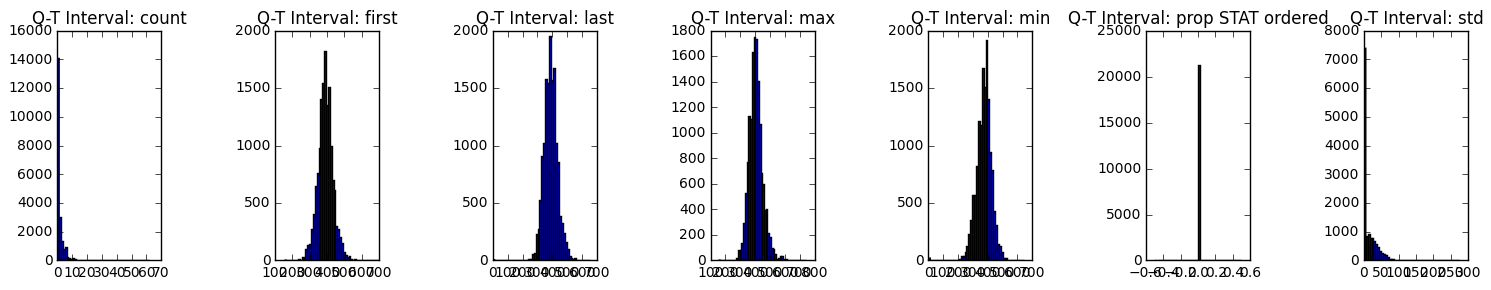

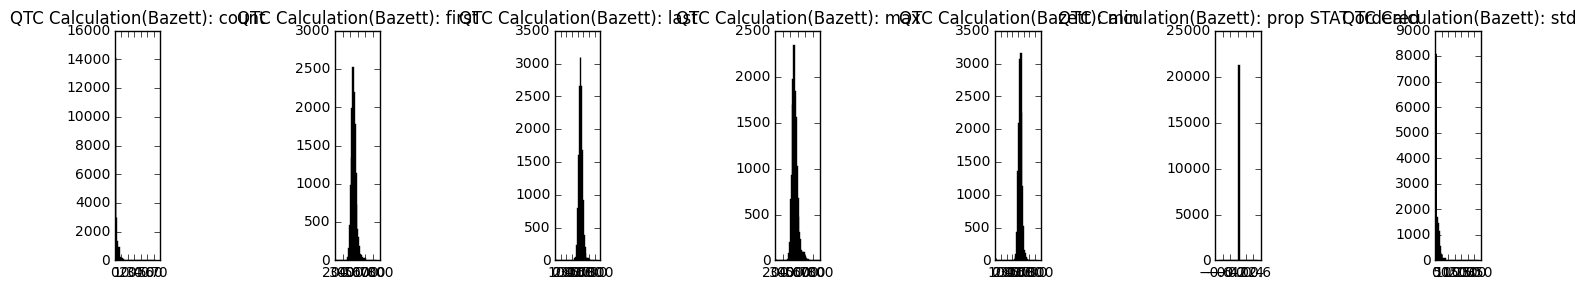

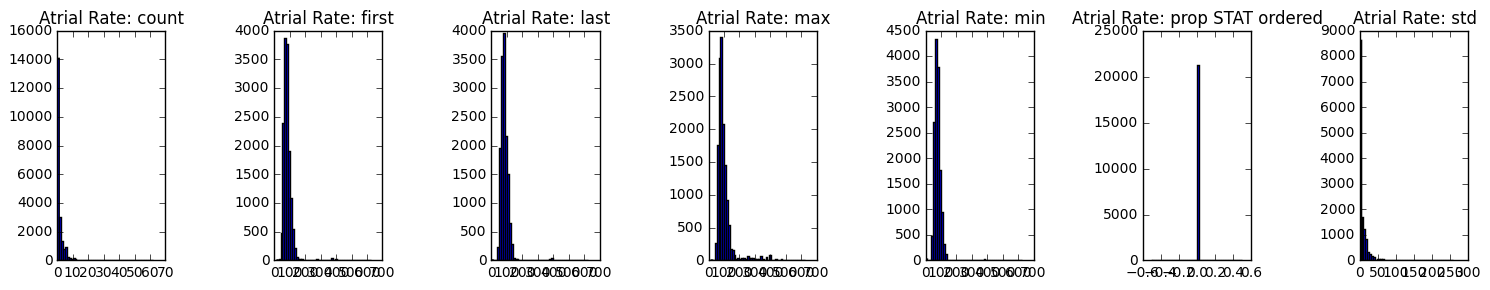

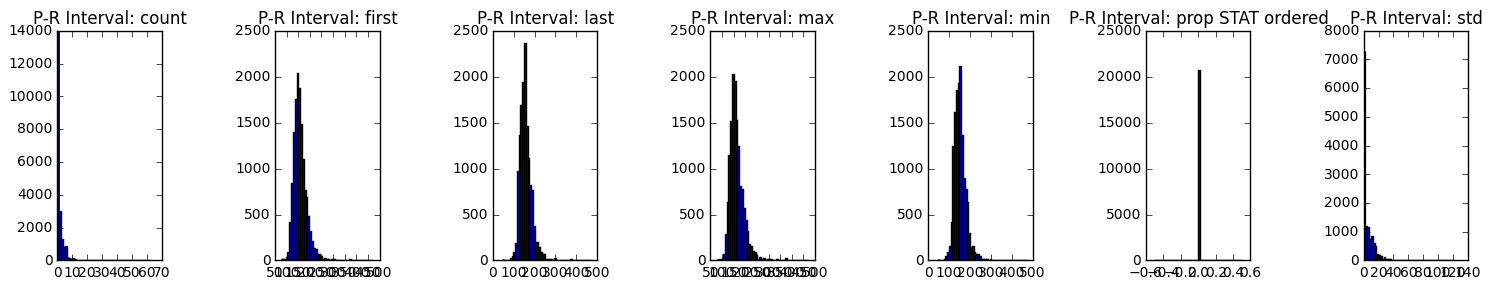

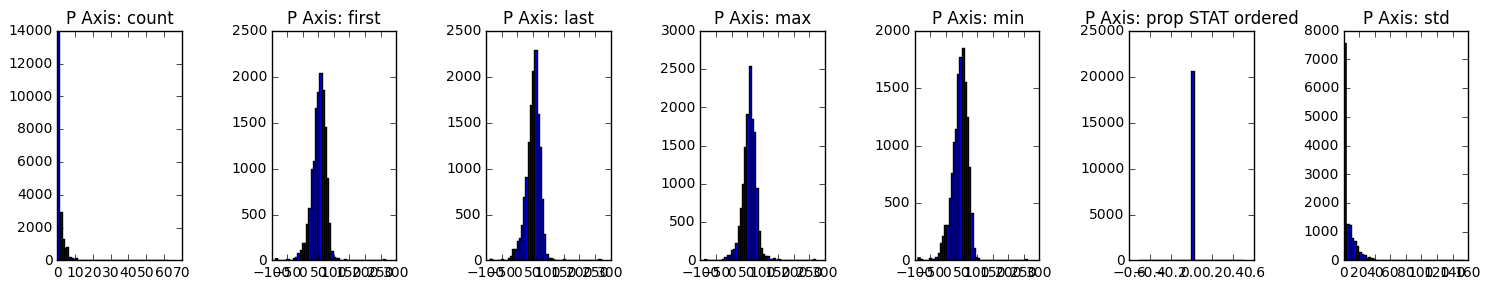

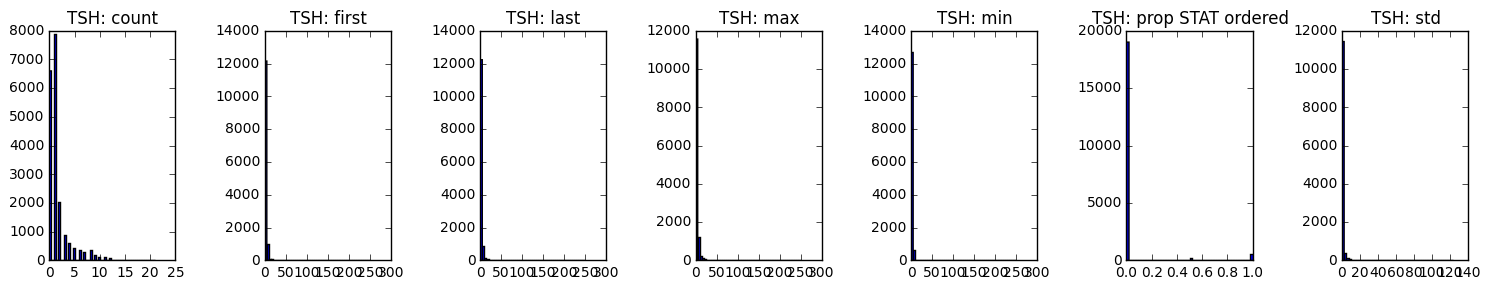

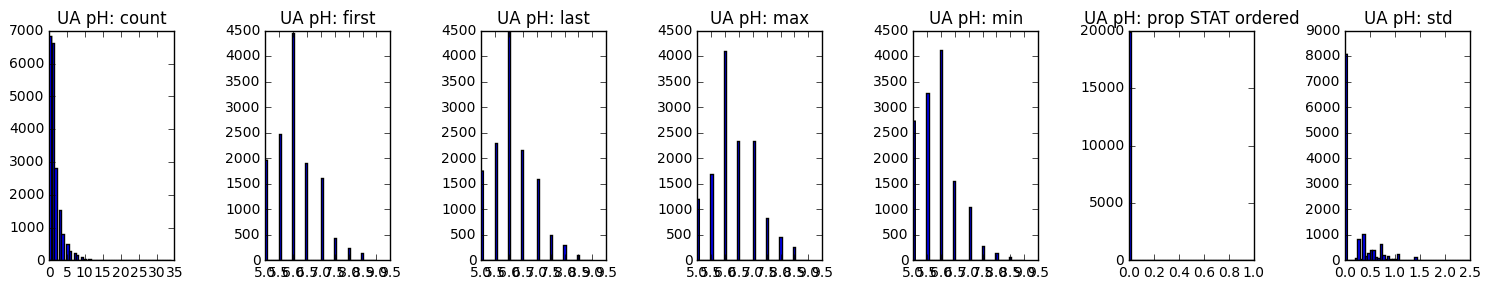

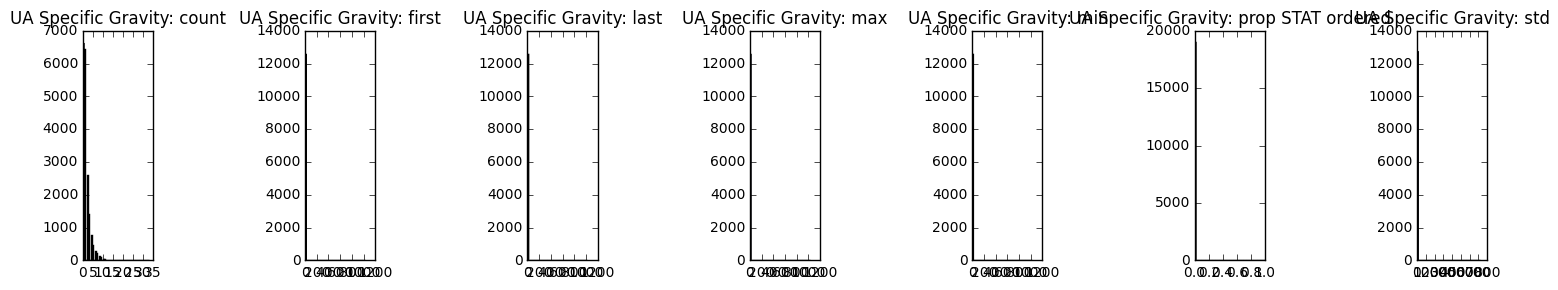

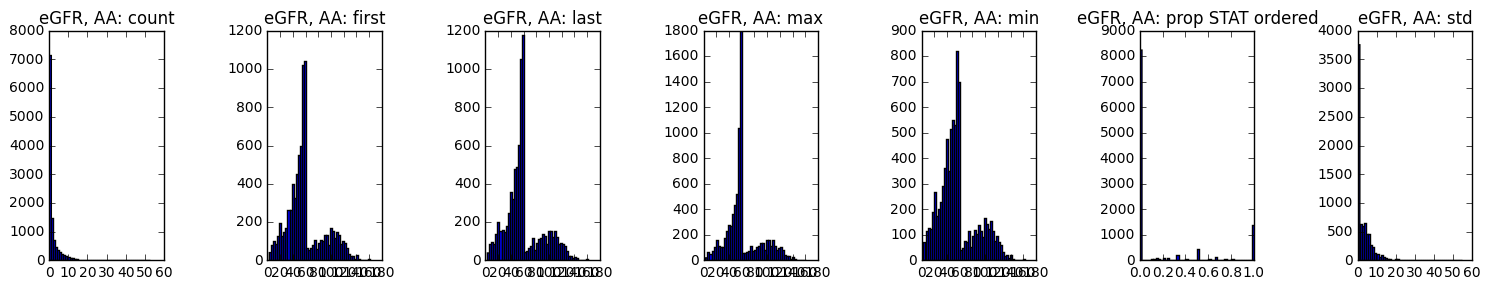

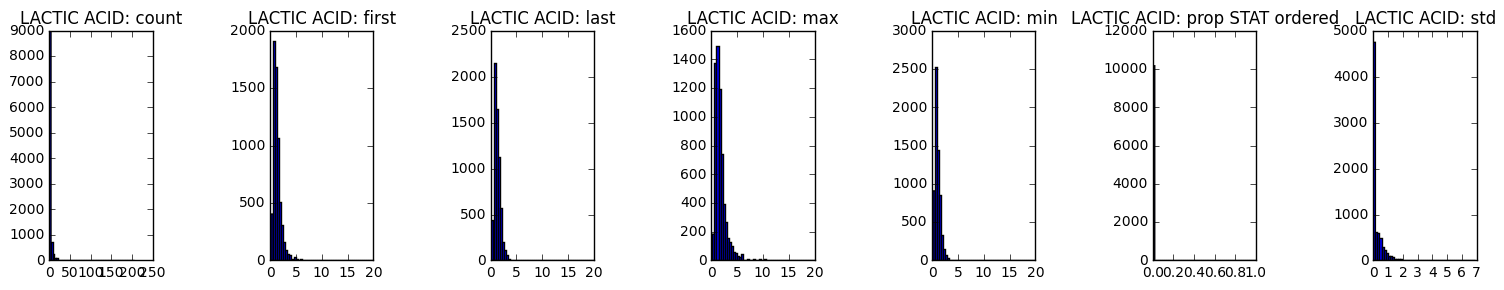

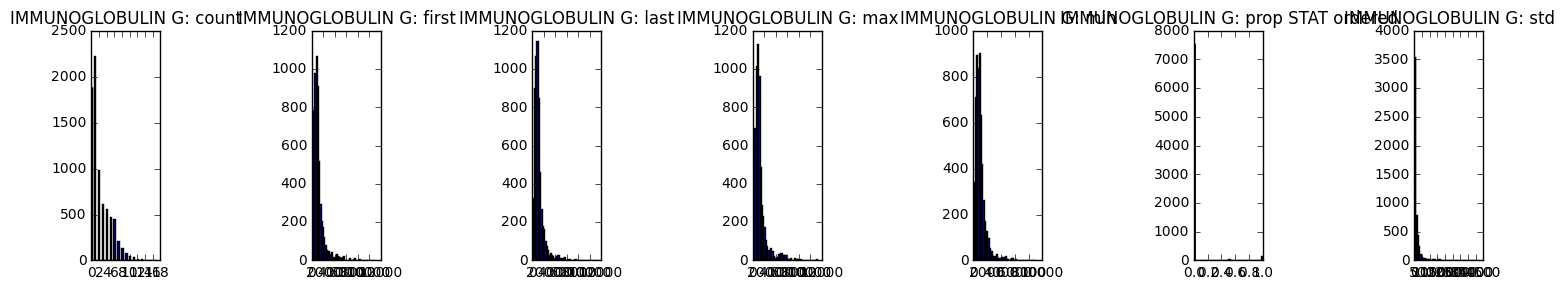

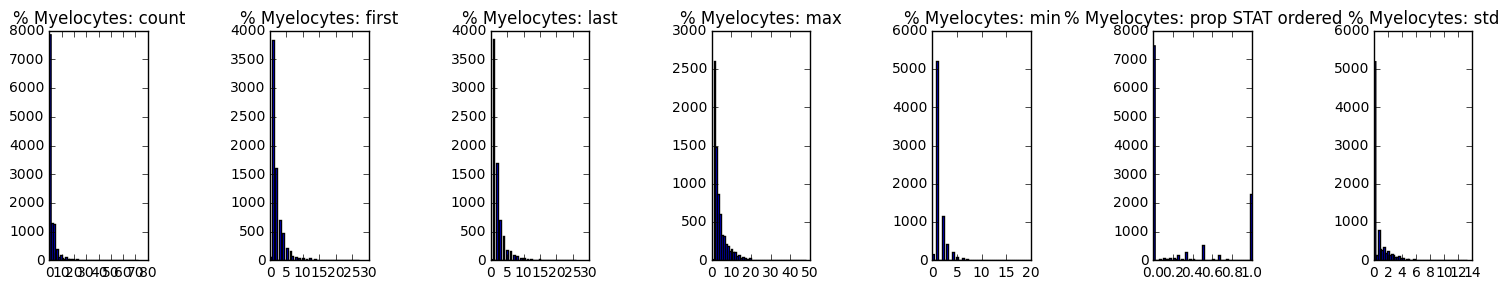

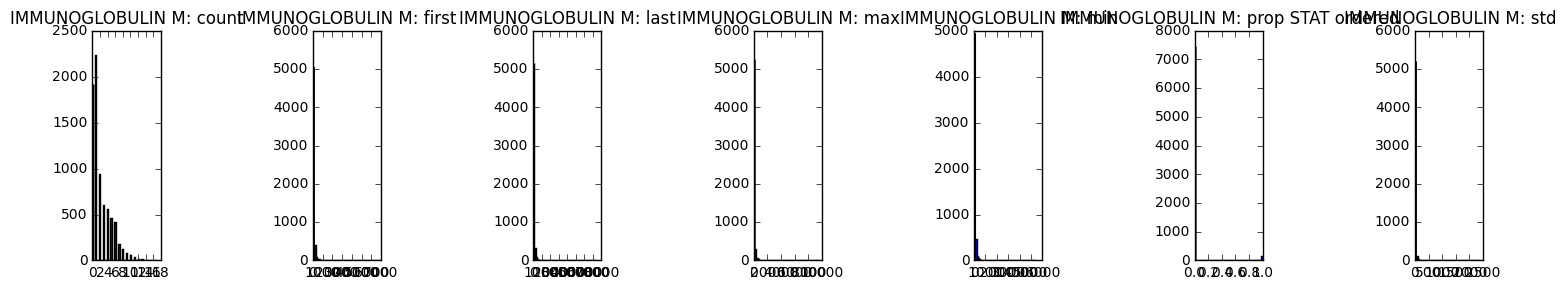

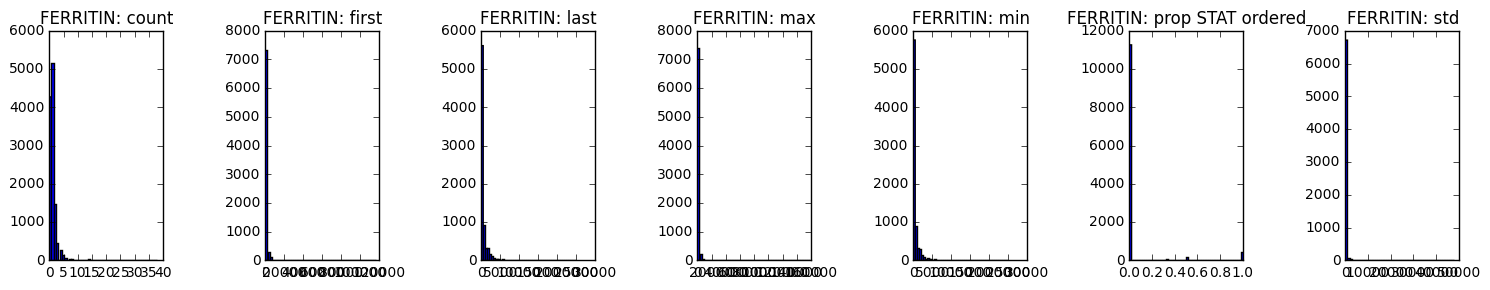

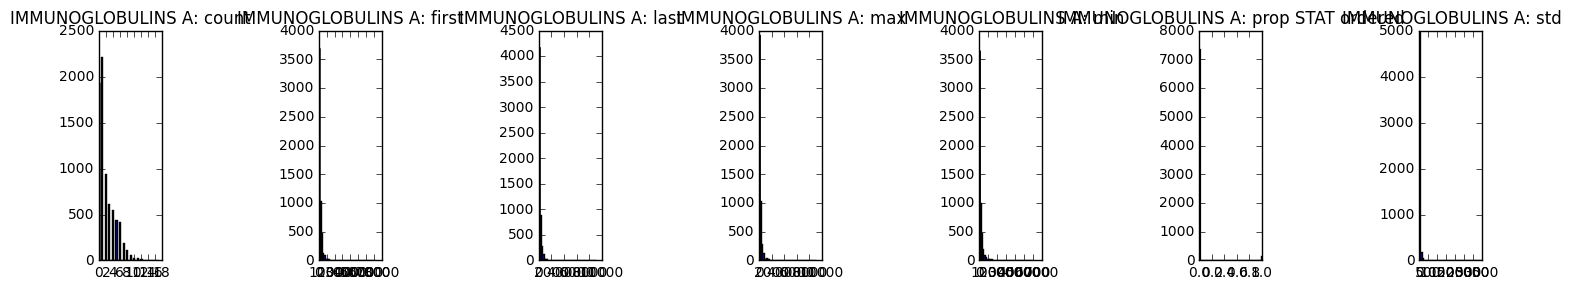

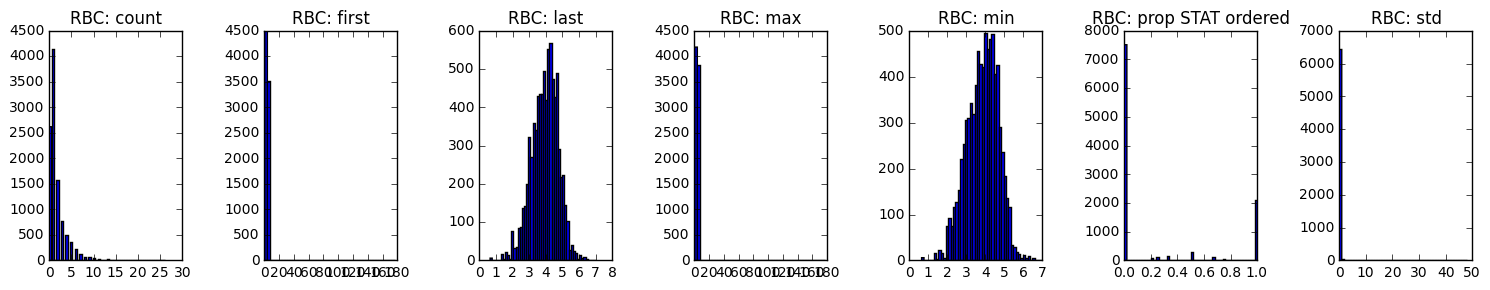

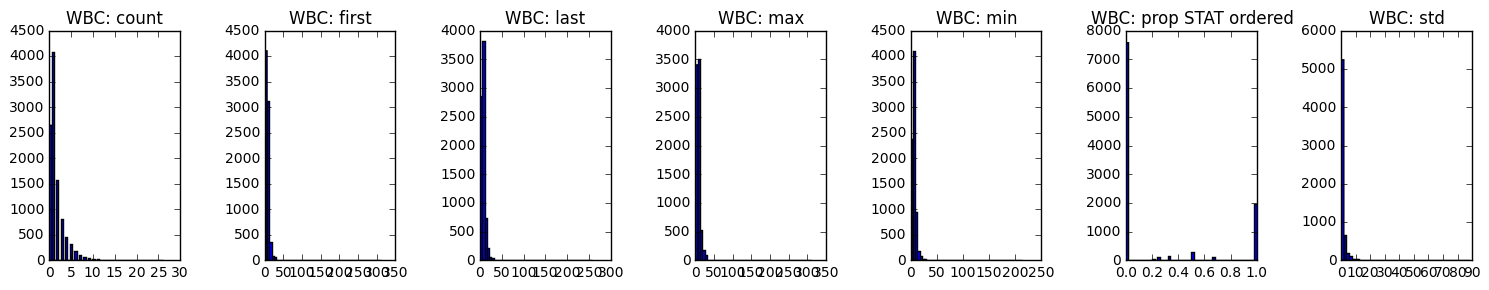

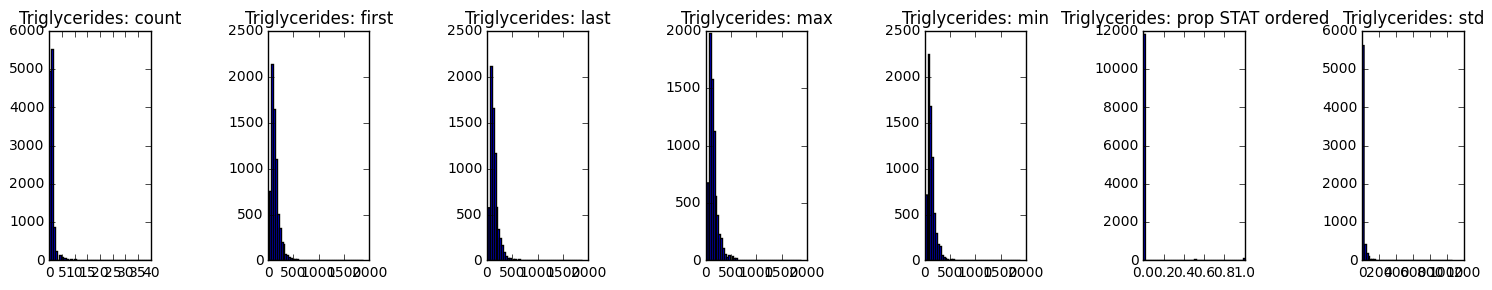

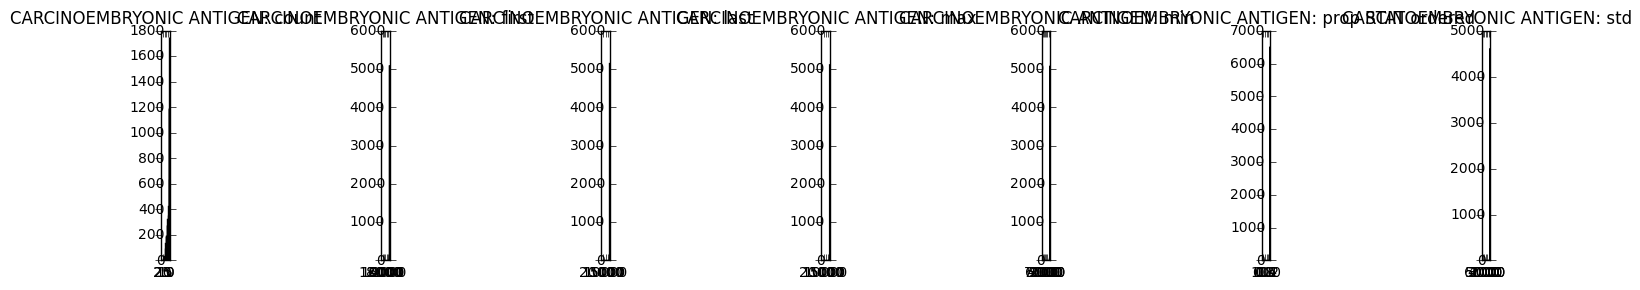

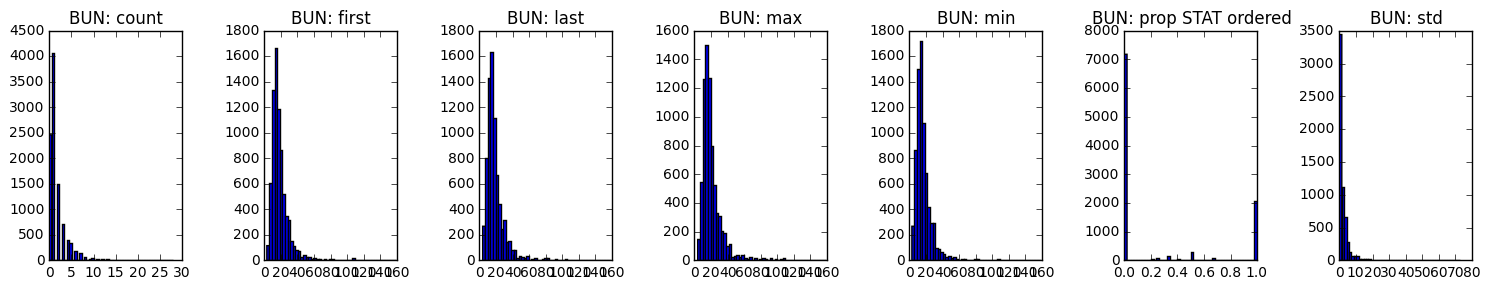

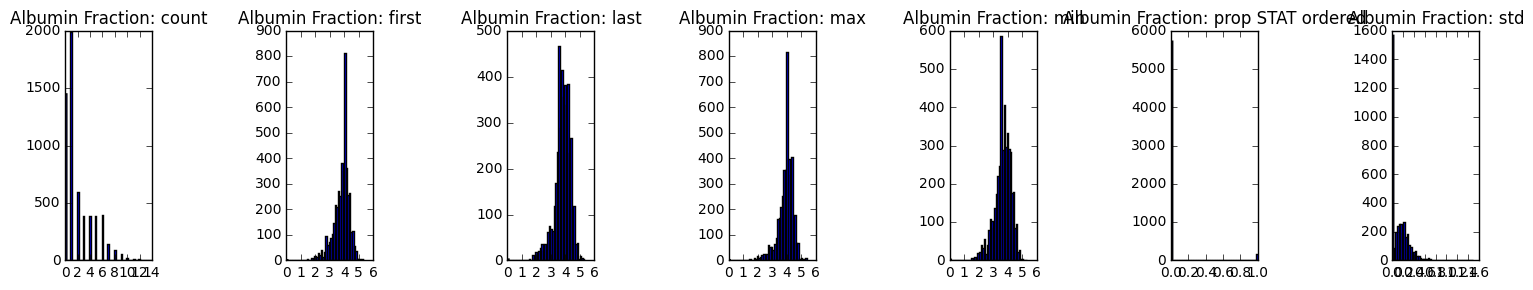

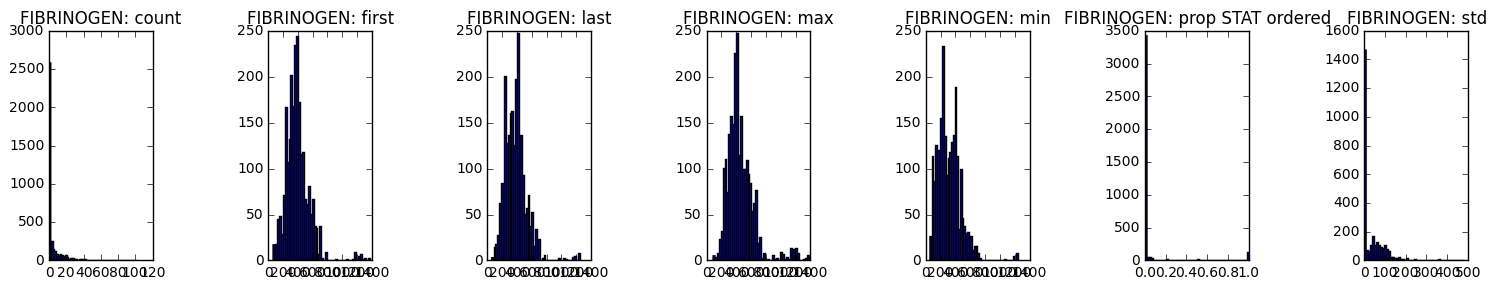

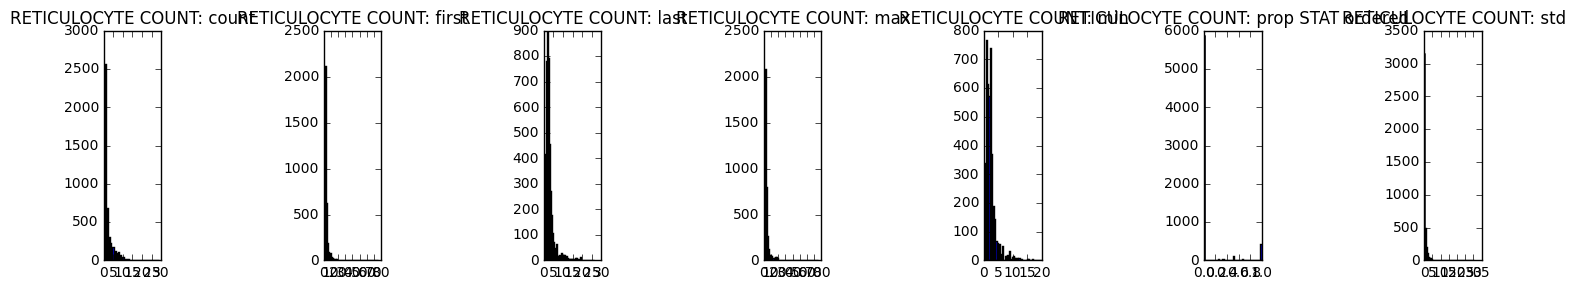

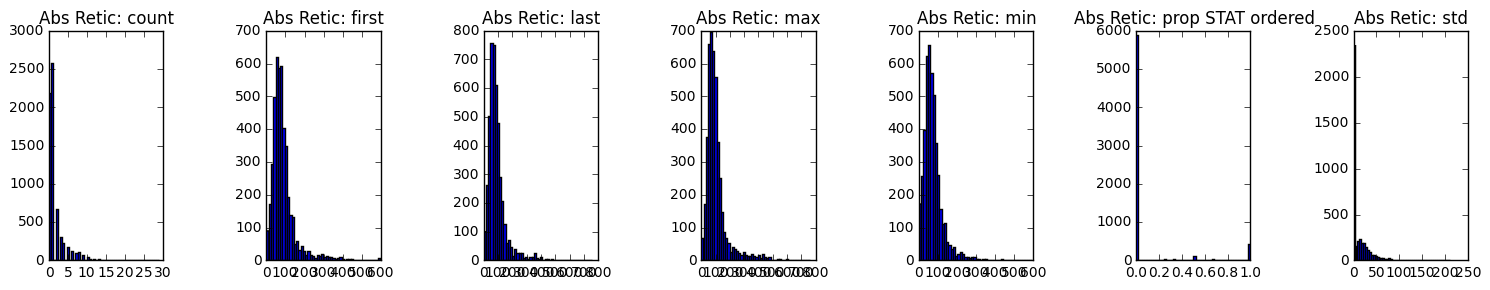

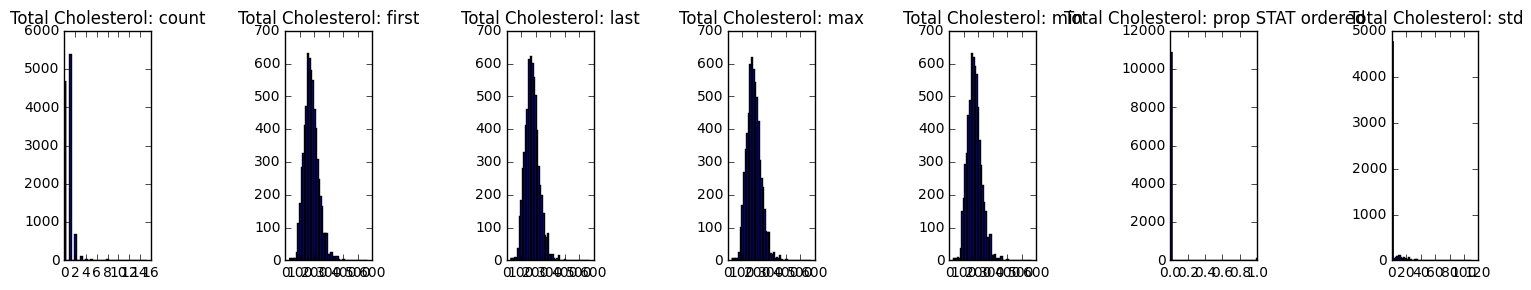

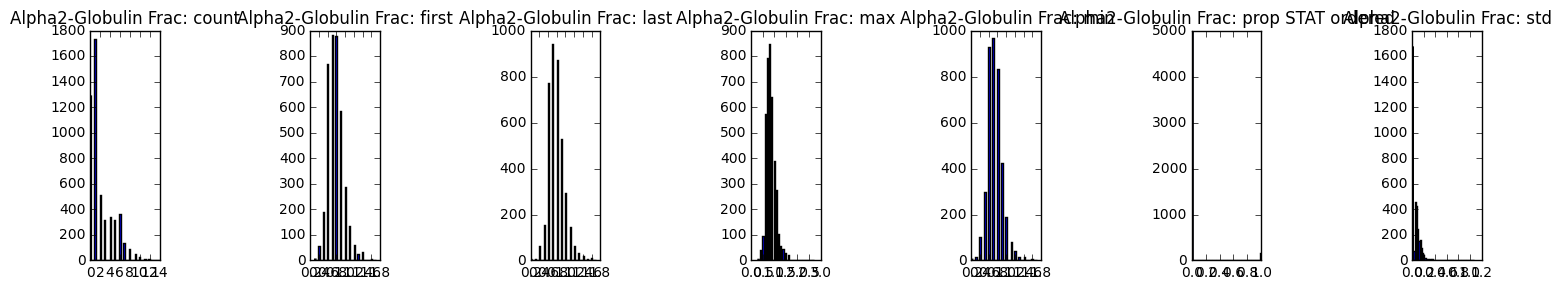

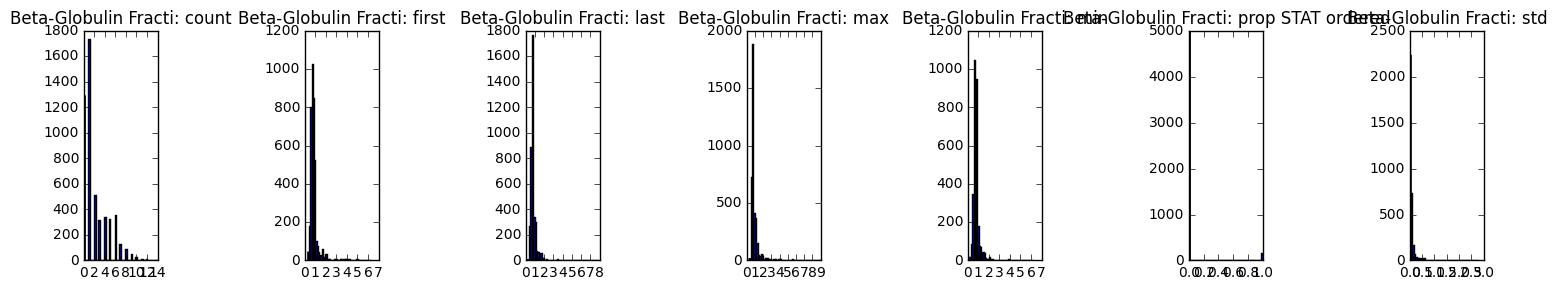

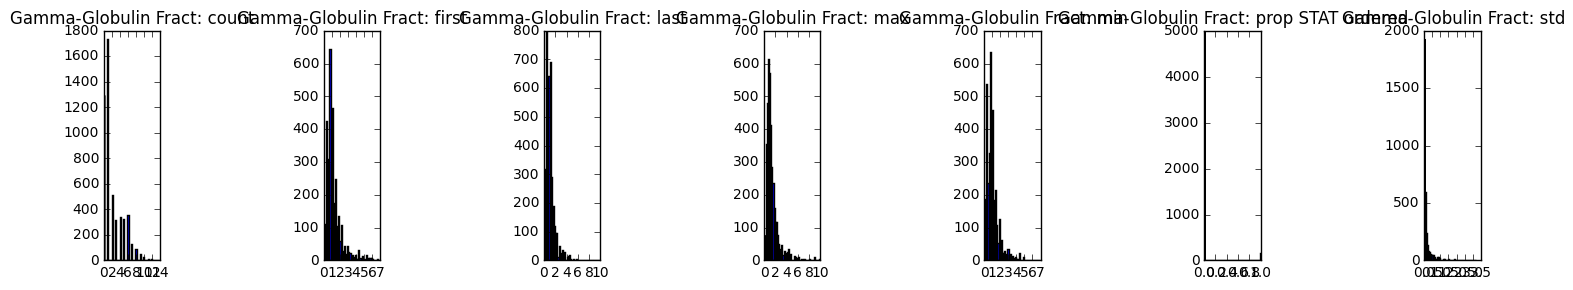

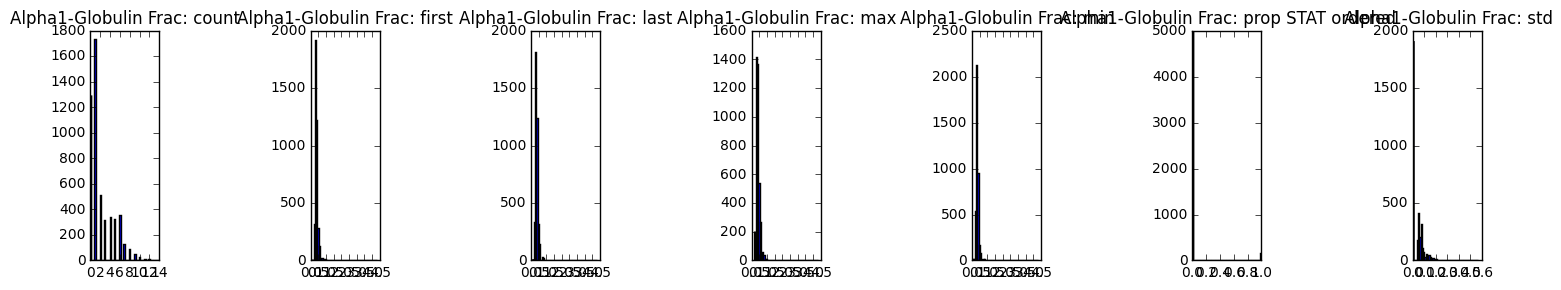

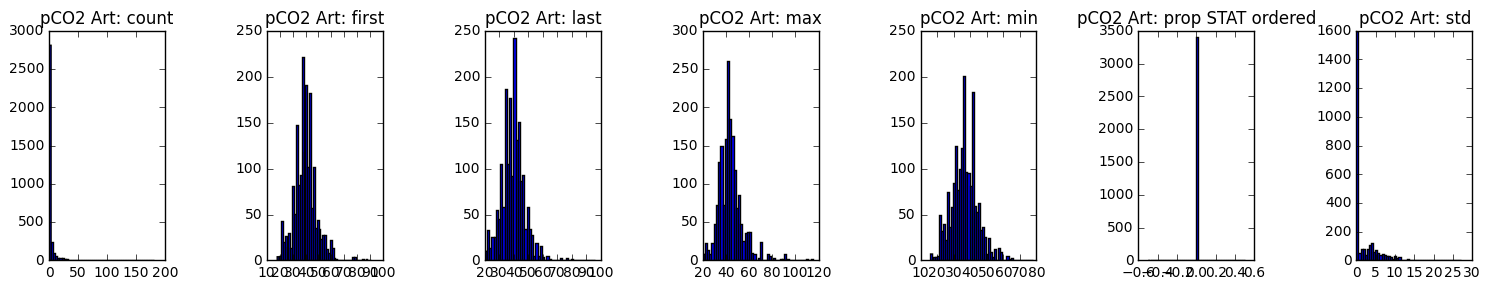

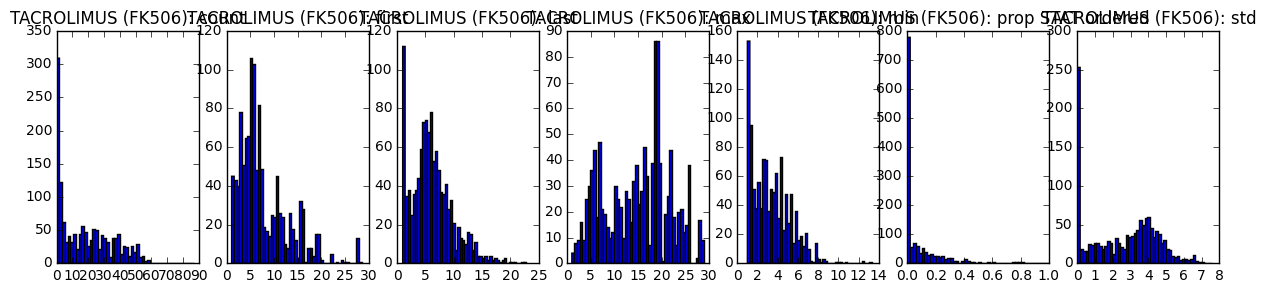

In [32]:
binary_missing_cols = []
imputes = {}
tol = 0.01

def safe_float(x):
    try:
        return float(x)
    except:
        return np.nan

for i,col in enumerate(num_cols):
    if col in enc_data:
        enc_data[col] = enc_data[col].apply(safe_float)
        col_count = enc_data[col].count()
        if (i % 7) == 0:
            if i != 0:
                fig.tight_layout()
                plt.show()
            fig, axx = plt.subplots(1,7,figsize=(15,3))
        ax = axx[i%7]
        ax.hist(enc_data[col].dropna().values,bins=50)
        ax.set_title(col)
            
        if (col_count / float(enc_data.shape[0])) < tol:
            print('------ dropping',col, col_count)
            del enc_data[col]
        else:
            if (': count' in col) or (': std' in col):
                imputes[col] = 0.0
            else:
                imputes[col] = enc_data[col].median()
            enc_data[col] = enc_data[col].fillna(imputes[col])

In [33]:
enc_data['SPECIALTY'].value_counts()

Oncology               37407
Hematology/Oncology    24970
dtype: int64

In [34]:
to_cats = ['SPECIALTY']
cat_cols = []
for c in to_cats:
    cats = enc_data[c].unique()
    for ca in cats:
        cat_col_name = c + " >>> "+ca
        enc_data[cat_col_name] = (enc_data[c]==ca) * 1.0
        cat_cols.append(cat_col_name)

In [37]:
enc_data['SEX_C'] = enc_data['SEX_C'].astype(float)

In [38]:
enc_data.to_csv('OutpatientONC_v1_1_enc_data_features.csv',index=False)
#enc_data = pd.read_csv('OutpatientONC_v1_1_enc_data_features.csv')